In [4]:
# import libraries here; add more as necessary
from collections import namedtuple
import pickle
import math
import itertools
import importlib
import os
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from scipy.spatial.distance import cdist

from xgboost import XGBClassifier

import azdias_helpers.clean_df as clean_df
import azdias_helpers.verbosity as v
import azdias_helpers.pickler as pickler
import azdias_helpers.config as config

from matplotlib.pyplot import figure

# magic word for producing visualizations in notebook
%matplotlib inline

pd.set_option('display.max_rows', None)

In [2]:
azdias = pd.read_csv('./Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('./Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\Olive\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
importlib.reload(clean_df)
importlib.reload(pickler)
importlib.reload(config)

<module 'azdias_helpers.config' from 'C:\\Users\\Olive\\Documents\\PortfolioProjects\\arvato-udacity-customersegmentation\\azdias_helpers\\config.py'>

# Section 1. Dimensionality Reduction

In [4]:
cols_keep = pickler.load('cols_keep')
os.path.isfile(config.dataset_dir + '/cols_keep.pickle') 

True

In [5]:
cols_keep_ipynb_1_0 = 'cols_keep_ipynb_1_0'
if not os.path.isfile(config.dataset_dir + '/' + cols_keep_ipynb_1_0 + '.pickle'):
    print("Pickling cols_keep for first time")
    pickler.dump(cols_keep,cols_keep_ipynb_1_0)
else:
    print("File already exists")

File already exists


In [6]:
cols_keep = pickler.load(cols_keep_ipynb_1_0)

In [7]:
azdias_clean = clean_df.etl_pipeline(azdias,cols_keep=cols_keep,verbosity=v.MED)

Running etl_pipeline...
Running unknown_to_nan...
Finished unknown_to_nan...
Running onehot_encode_df...
Finished running onehot_encode_df...
Running remove_string_values...
Finished running remove_string_values.
Running binarize_nan...
Finishing binarize_nan.
Running standardise_binary_features...
Finished running standardise_binary_features.
Running bin_features_with_tails...
Finished running bin_features_with_tails
Running drop_sparse_samples.
0% of rows dropped: 0 out of 891,221
Finished running drop_sparse_samples.
Finished running etl_pipeline.

df shape before:(891221, 366), after:(891221, 99)


In [8]:
customers_clean = clean_df.etl_pipeline(customers,cols_keep=cols_keep,verbosity=v.MED)

Running etl_pipeline...
Running unknown_to_nan...
Finished unknown_to_nan...
Running onehot_encode_df...
Finished running onehot_encode_df...
Running remove_string_values...
Finished running remove_string_values.
Running binarize_nan...
Finishing binarize_nan.
Running standardise_binary_features...
Finished running standardise_binary_features.
Running bin_features_with_tails...
Finished running bin_features_with_tails
Running drop_sparse_samples.
0% of rows dropped: 0 out of 191,652
Finished running drop_sparse_samples.
Finished running etl_pipeline.

df shape before:(191652, 369), after:(191652, 99)


# EDA

In [9]:
def plot_null_counts(df,num_features_to_show=25):
    
    fe_with_null = df.columns[df.isnull().any()]
    null_counts = df[fe_with_null].isnull().sum()
    null_counts_perc = np.floor((null_counts*100)/len(df.index))
    
    (null_counts_perc.sort_values(ascending=False)[:num_features_to_show].plot(kind='bar', figsize=(20,8),fontsize=13))
    plt.show()
    
    null_counts_per_row = df.isnull().sum(axis=1).tolist()
    plt.hist(null_counts_per_row,bins=20)
    plt.show()

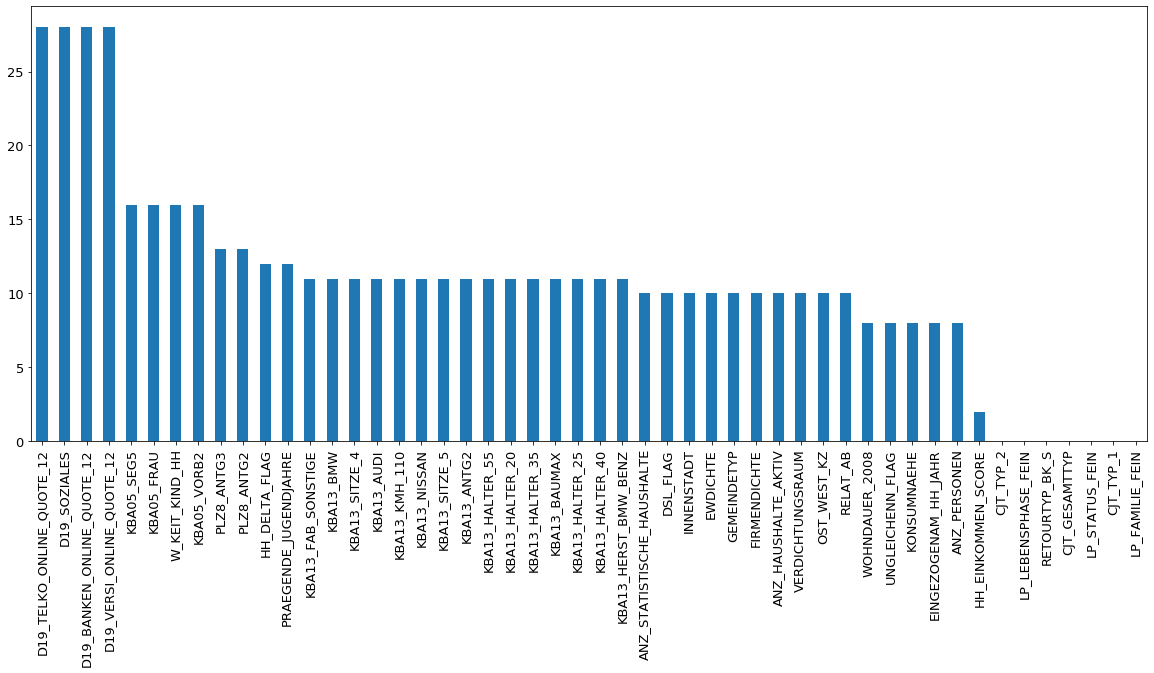

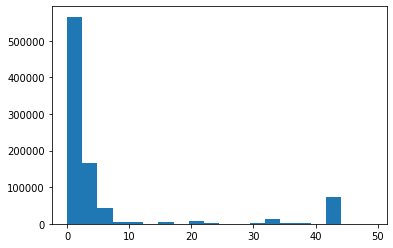

In [10]:
plot_null_counts(azdias_clean,50)

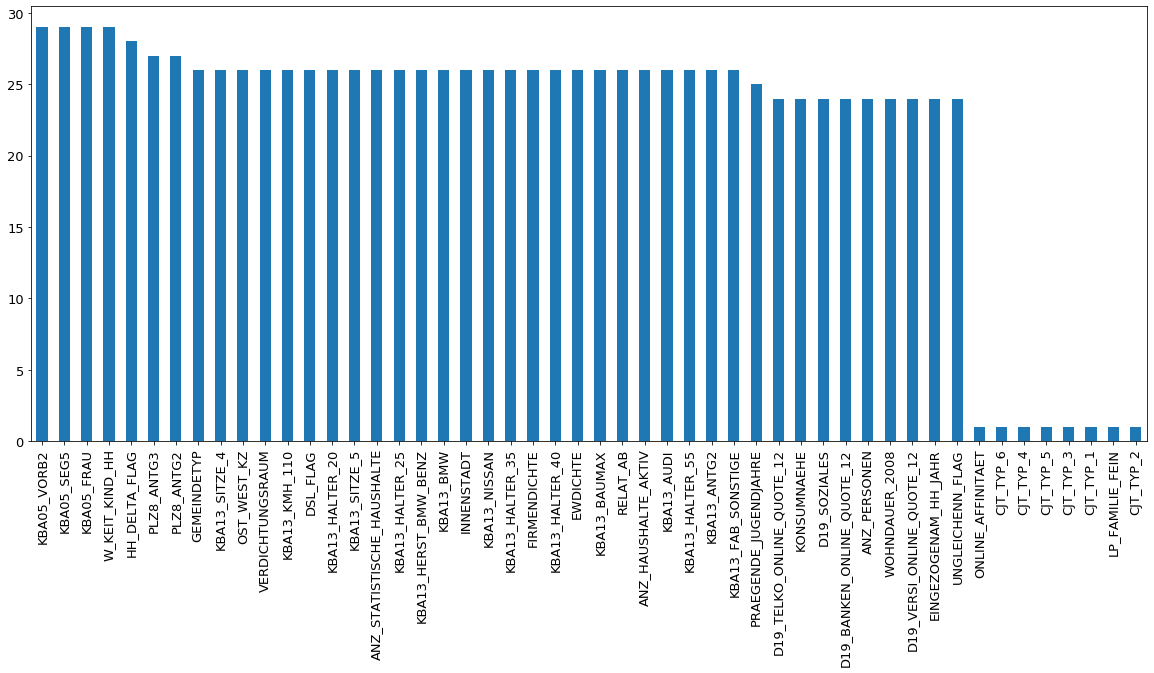

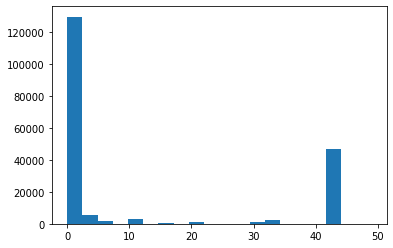

In [11]:
plot_null_counts(customers_clean,50)

There's still a high proportion of the customer dataset that are missing ~45 features, about 50% sparsity. 

I'm going to investigate which features these were and how low ranked they were in the previous notebook. Maybe I can reduce the number of features further

In [12]:
customers_high_null = customers_clean[customers_clean.isnull().sum(axis=1)>=30]
cols_null = customers_high_null.columns[customers_high_null.isnull().any()]
null_counts = customers_high_null[cols_null].isnull().sum()
null_counts_perc = np.floor((null_counts*100/len(customers_high_null.index)))
null_counts_perc.sort_values(ascending=False)

KBA13_HALTER_35               100.0
KBA13_SITZE_5                 100.0
KBA05_VORB2                   100.0
KBA13_KMH_110                 100.0
KBA13_NISSAN                  100.0
KBA13_AUDI                    100.0
KBA13_ANTG2                   100.0
KBA13_HALTER_55               100.0
KBA13_FAB_SONSTIGE            100.0
KBA13_HALTER_20               100.0
PLZ8_ANTG2                    100.0
KBA13_SITZE_4                 100.0
KBA13_BAUMAX                  100.0
KBA13_BMW                     100.0
KBA13_HALTER_40               100.0
PLZ8_ANTG3                    100.0
KBA13_HALTER_25               100.0
KBA05_FRAU                    100.0
KBA13_HERST_BMW_BENZ          100.0
KBA05_SEG5                    100.0
ANZ_STATISTISCHE_HAUSHALTE     99.0
GEMEINDETYP                    99.0
VERDICHTUNGSRAUM               99.0
DSL_FLAG                       99.0
INNENSTADT                     99.0
OST_WEST_KZ                    99.0
RELAT_AB                       99.0
FIRMENDICHTE                

In [13]:
null_counts_perc.ge(1).sort_values(ascending=False)

DSL_FLAG                       True
KBA05_VORB2                    True
OST_WEST_KZ                    True
PLZ8_ANTG2                     True
VERDICHTUNGSRAUM               True
KBA13_KMH_110                  True
GEMEINDETYP                    True
KBA13_HALTER_20                True
UNGLEICHENN_FLAG               True
KBA13_SITZE_5                  True
HH_EINKOMMEN_SCORE             True
EINGEZOGENAM_HH_JAHR           True
D19_VERSI_ONLINE_QUOTE_12      True
KBA13_BMW                      True
W_KEIT_KIND_HH                 True
D19_BANKEN_ONLINE_QUOTE_12     True
PRAEGENDE_JUGENDJAHRE          True
ANZ_STATISTISCHE_HAUSHALTE     True
KBA13_HALTER_25                True
KBA13_HERST_BMW_BENZ           True
D19_SOZIALES                   True
KBA13_SITZE_4                  True
INNENSTADT                     True
KONSUMNAEHE                    True
RELAT_AB                       True
KBA05_SEG5                     True
FIRMENDICHTE                   True
KBA05_FRAU                  

In [14]:
sparse_customer_features = null_counts_perc.where(lambda x: x>0).dropna().sort_values(ascending=False).index

In [15]:
def get_feature_importances():
    
    X = pickler.load('labeled_azdias_and_customers_df').drop('RESPONSE',axis=1)
    xgb_model = pickler.load('model_xgb_base_model_for_feature_selection')
    
    feature_importance = pd.DataFrame(np.array([X.columns.values,xgb_model.feature_importances_]).transpose(),\
    columns=['feature','importance'])
    
    feature_importance_sorted = feature_importance.loc[feature_importance.importance > 0].sort_values(by=['importance'],ascending=False)
    
    return(feature_importance_sorted)

In [16]:
#Need to clear memory
azdias = None
azdias_clean = None

In [17]:
%%time
feature_importance_sorted = get_feature_importances()

Wall time: 10.5 s


In [18]:
azdias = pd.read_csv('./Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('./Udacity_CUSTOMERS_052018.csv', sep=';')

In [19]:
azdias_clean = clean_df.etl_pipeline(azdias,cols_keep=cols_keep)
customers_clean = clean_df.etl_pipeline(customers,cols_keep=cols_keep)

In [20]:
feature_importance_sorted

,feature,importance
7,ANZ_PERSONEN,0.212315
18,CJT_TYP_6,0.0830784
57,D19_SOZIALES,0.0810815
16,CJT_TYP_4,0.0798488
17,CJT_TYP_5,0.0656554
15,CJT_TYP_3,0.060626
283,KOMBIALTER,0.0380417
294,ONLINE_AFFINITAET,0.0289777
286,LP_FAMILIE_FEIN,0.0278188
332,ALTERSKATEGORIE_GROB,0.0218072


In [21]:
feature_importance_sorted.shape
importance_cutoff = 0.001

print("Sparse and low importance customer features")
for fe in sparse_customer_features:
    if feature_importance_sorted.loc[feature_importance_sorted.feature==fe].importance.values < importance_cutoff:
        print(f"'{fe}',")

Sparse and low importance customer features
'KBA13_HALTER_35',
'KBA13_KMH_110',
'KBA13_BAUMAX',
'KBA13_HALTER_40',
'PLZ8_ANTG3',
'KBA05_FRAU',
'KBA05_SEG5',
'DSL_FLAG',
'EWDICHTE',
'FIRMENDICHTE',
'ANZ_HAUSHALTE_AKTIV',
'RELAT_AB',


In [22]:
cols_to_drop = [
'KBA13_HALTER_35',
'KBA13_KMH_110',
'KBA13_BAUMAX',
'KBA13_HALTER_40',
'PLZ8_ANTG3',
'DSL_FLAG',
'KBA05_SEG5',
'RELAT_AB',
'FIRMENDICHTE',
'EWDICHTE',
'KBA05_FRAU',
'ANZ_HAUSHALTE_AKTIV']

In [23]:
cols_keep = [col for col in cols_keep if col not in cols_to_drop]

In [24]:
azdias_clean = clean_df.etl_pipeline(azdias,cols_keep=cols_keep,verbosity=v.MED)
customers_clean = clean_df.etl_pipeline(customers,cols_keep=cols_keep,verbosity=v.MED)

Running etl_pipeline...
Running unknown_to_nan...
Finished unknown_to_nan...
Running onehot_encode_df...
Finished running onehot_encode_df...
Running remove_string_values...
Finished running remove_string_values.
Running binarize_nan...
Finishing binarize_nan.
Running standardise_binary_features...
Finished running standardise_binary_features.
Running bin_features_with_tails...
Finished running bin_features_with_tails
Running drop_sparse_samples.
0% of rows dropped: 0 out of 891,221
Finished running drop_sparse_samples.
Finished running etl_pipeline.

df shape before:(891221, 366), after:(891221, 87)
Running etl_pipeline...
Running unknown_to_nan...
Finished unknown_to_nan...
Running onehot_encode_df...
Finished running onehot_encode_df...
Running remove_string_values...
Finished running remove_string_values.
Running binarize_nan...
Finishing binarize_nan.
Running standardise_binary_features...
Finished running standardise_binary_features.
Running bin_features_with_tails...
Finished ru

In [25]:
def plot_hists(df,feature_list):
    
    for fe in feature_list:
        sns.set_style("darkgrid")
        sns.set_style("ticks")
        plt.figure(figsize=(16,6))
        plt.title("Histogram of {0}".format(fe))
        sns.distplot(df[fe].values,kde=False)
        plt.ylabel('Frequency',fontsize=12)
        plt.show()   

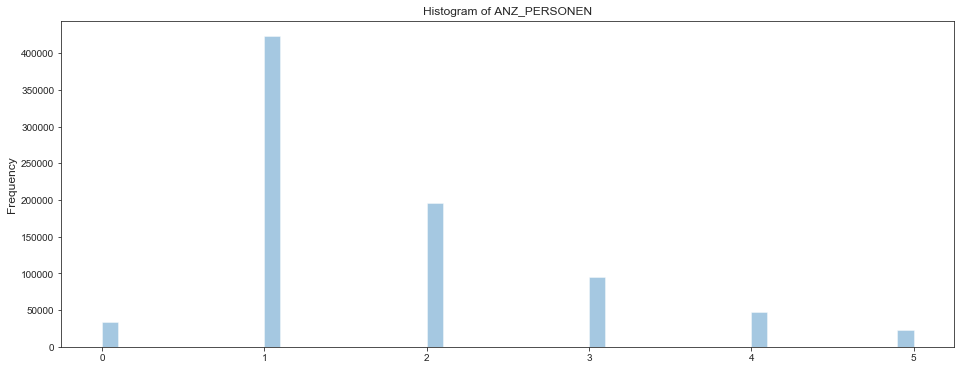

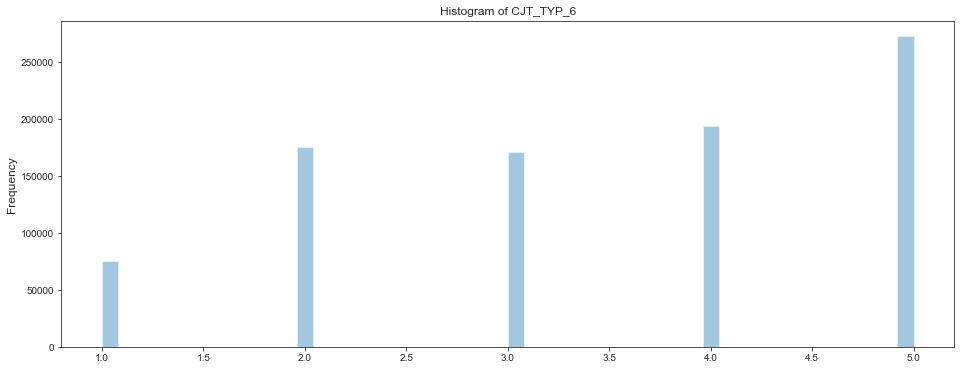

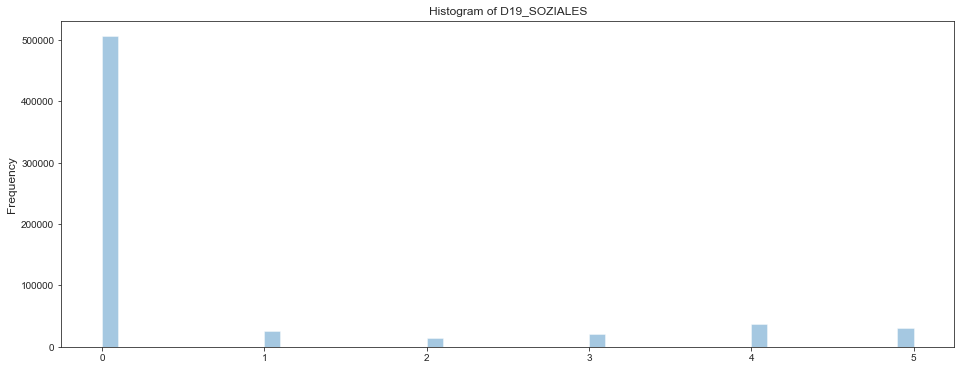

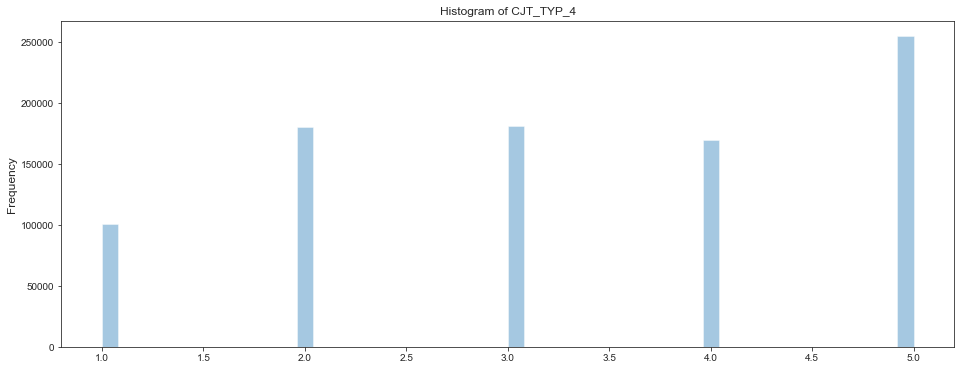

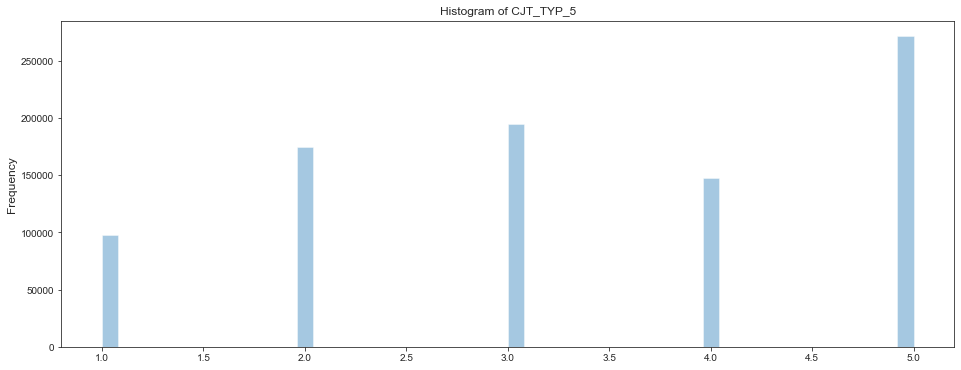

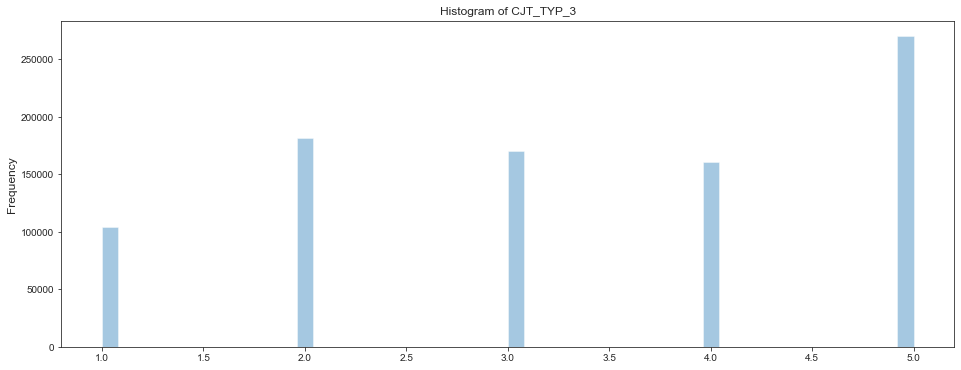

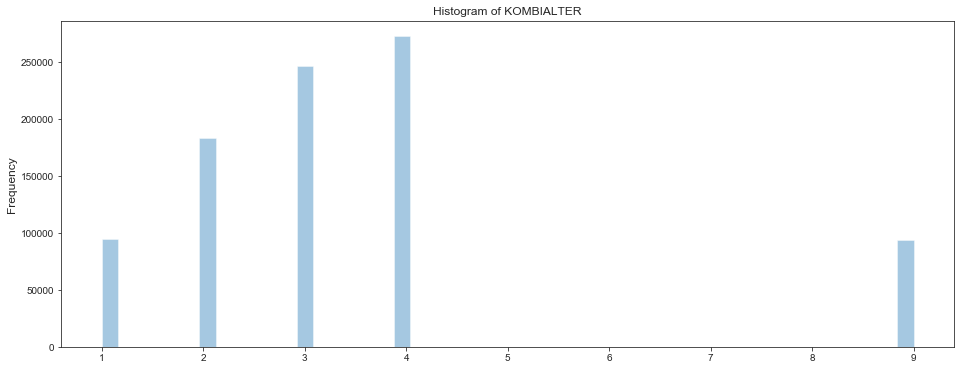

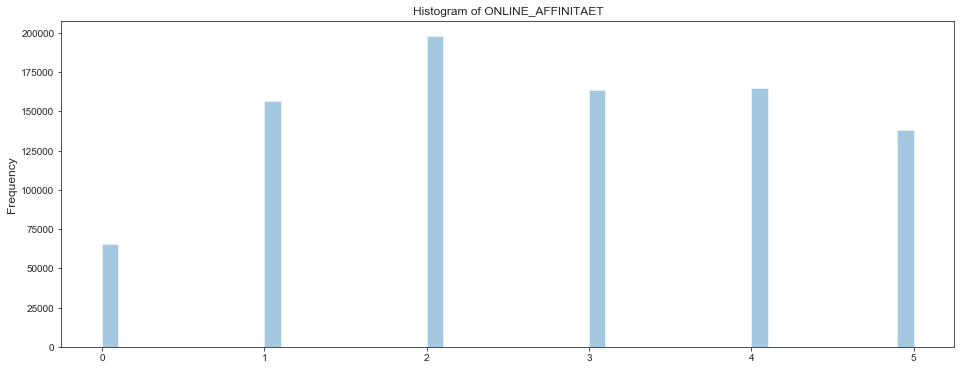

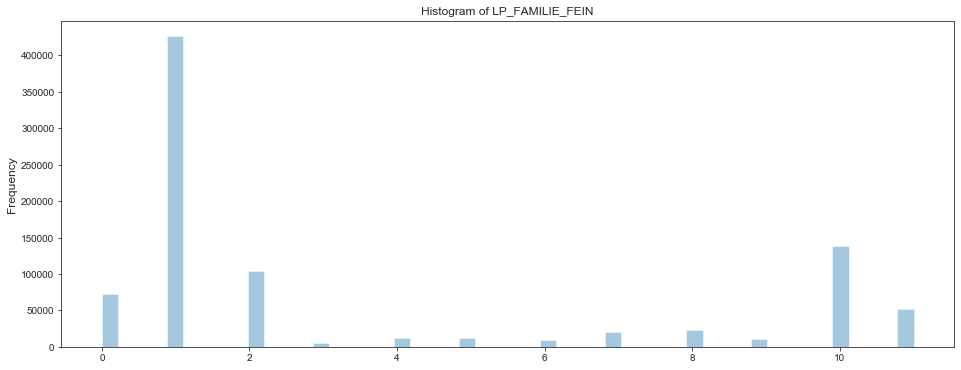

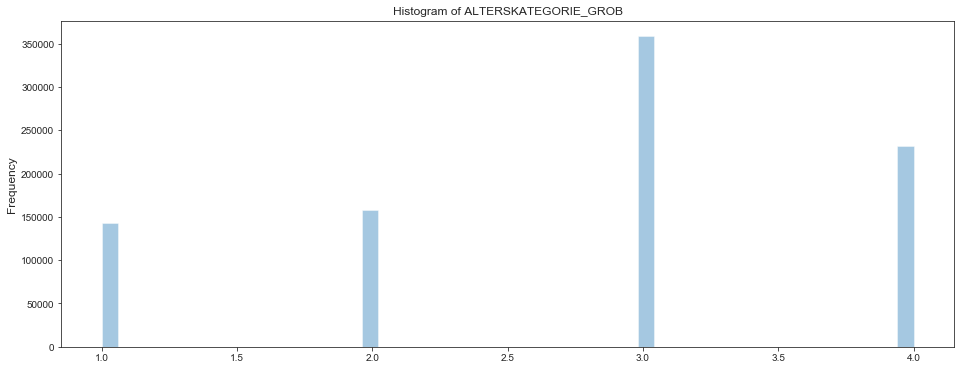

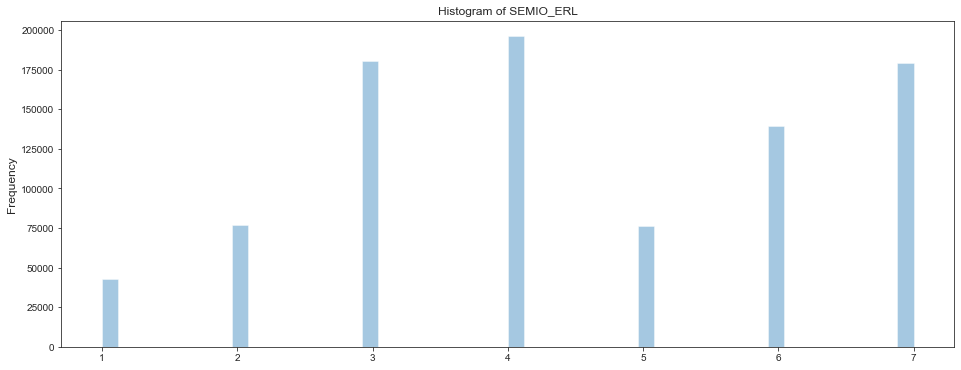

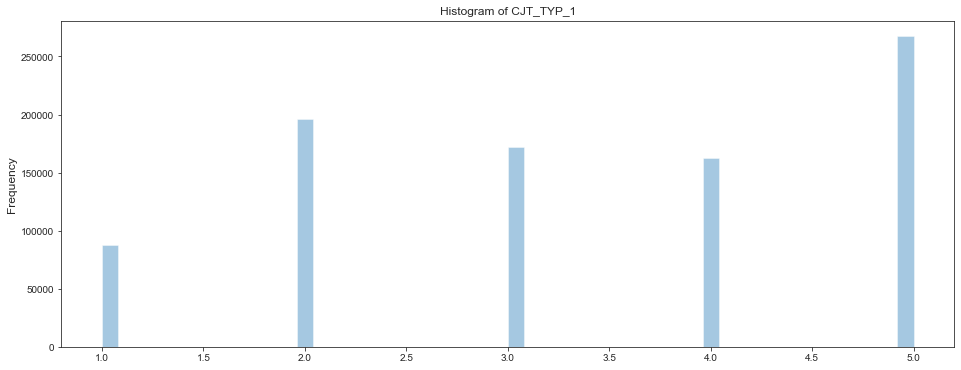

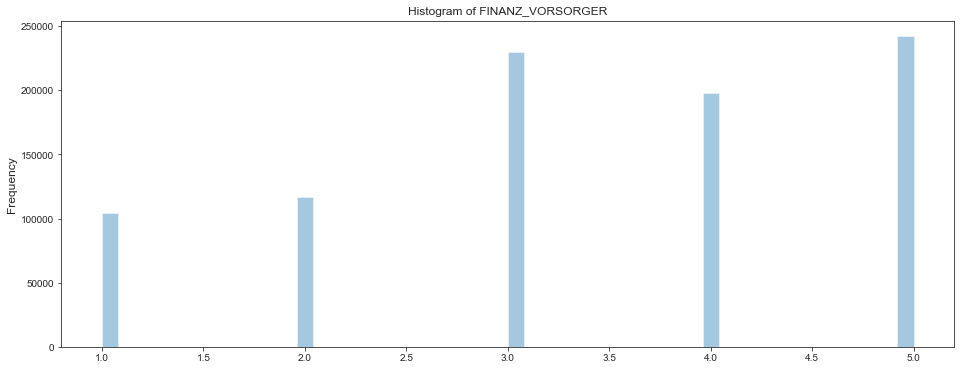

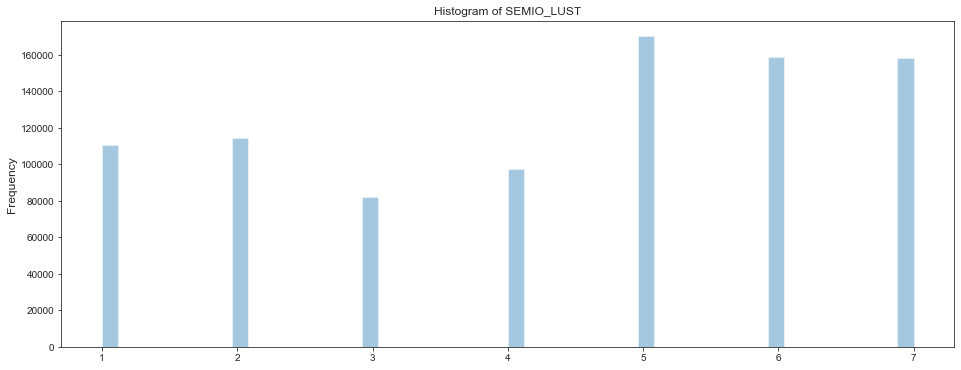

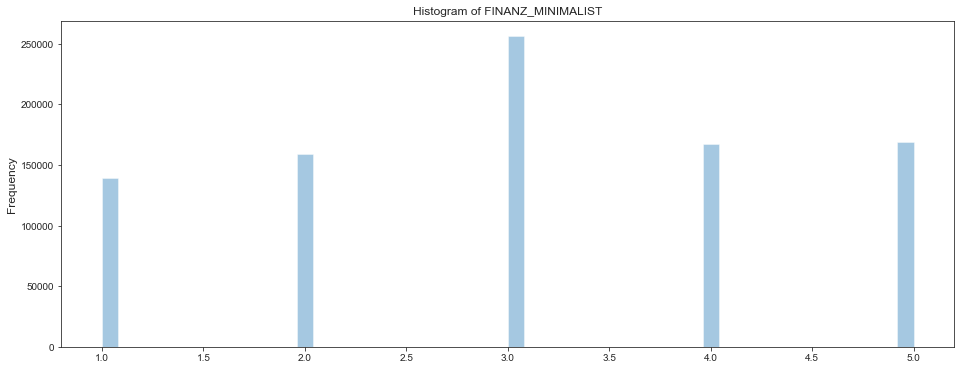

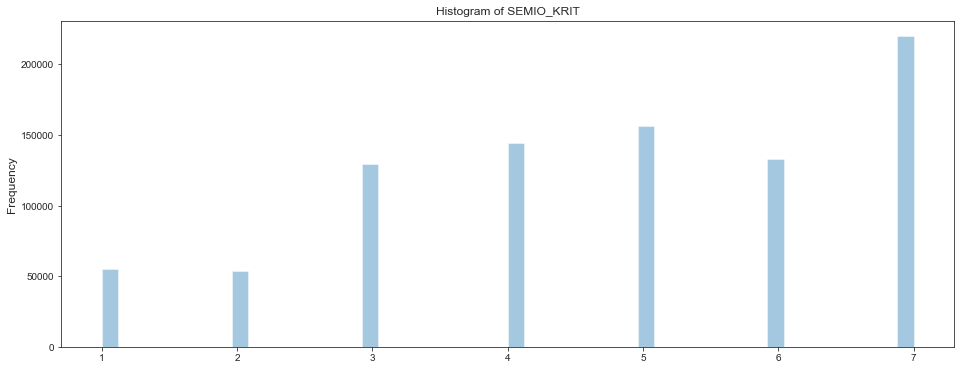

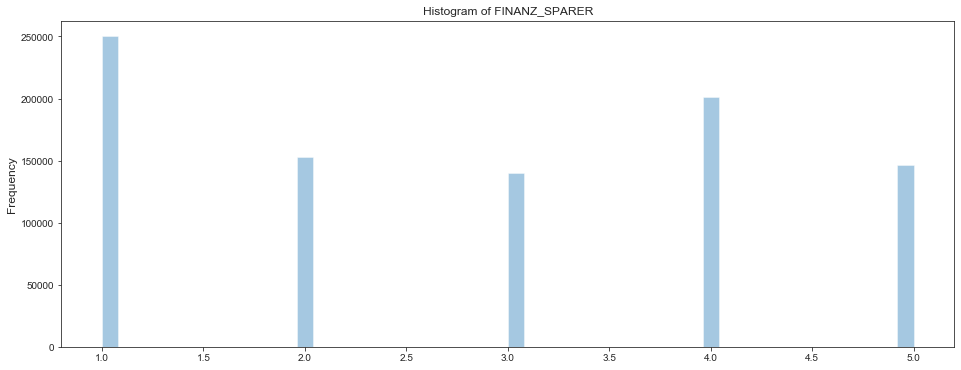

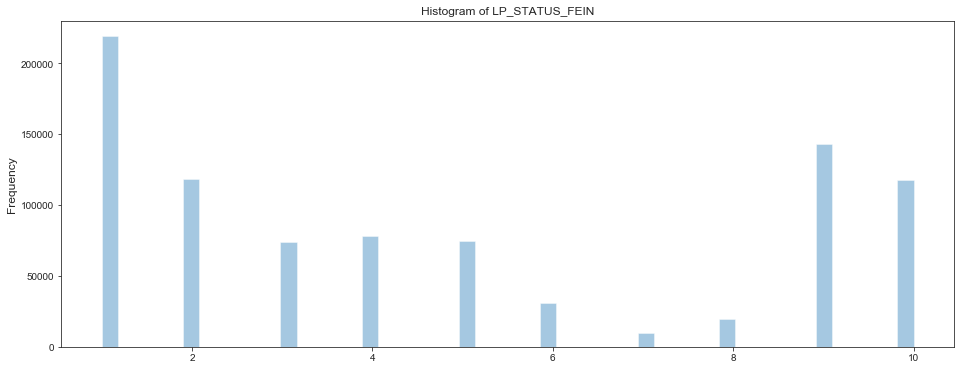

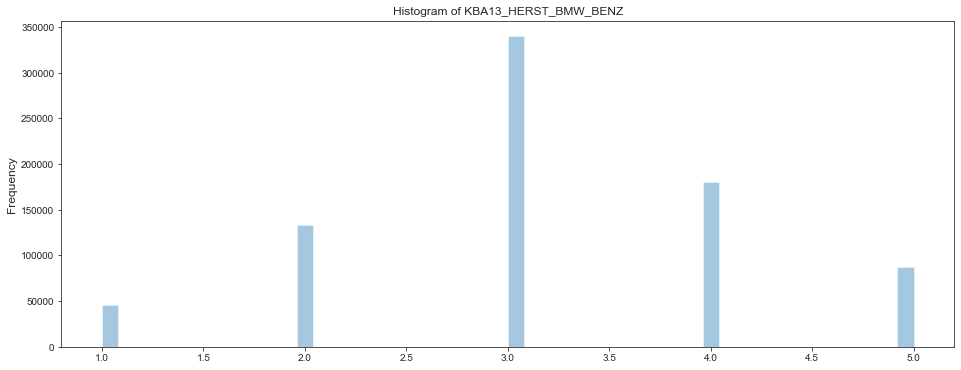

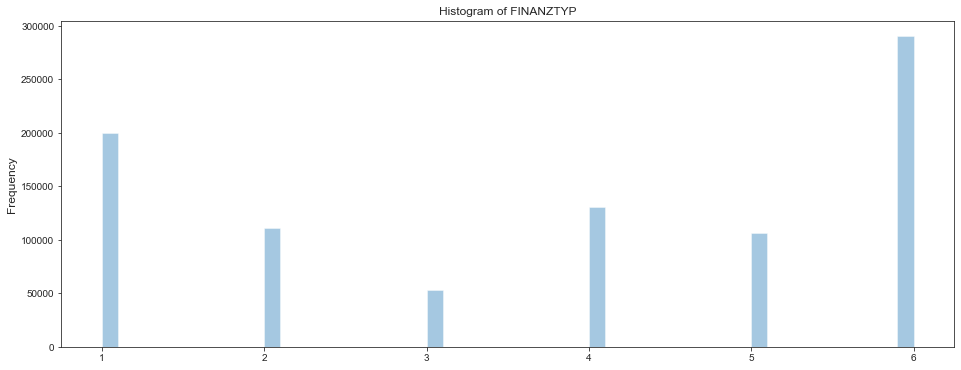

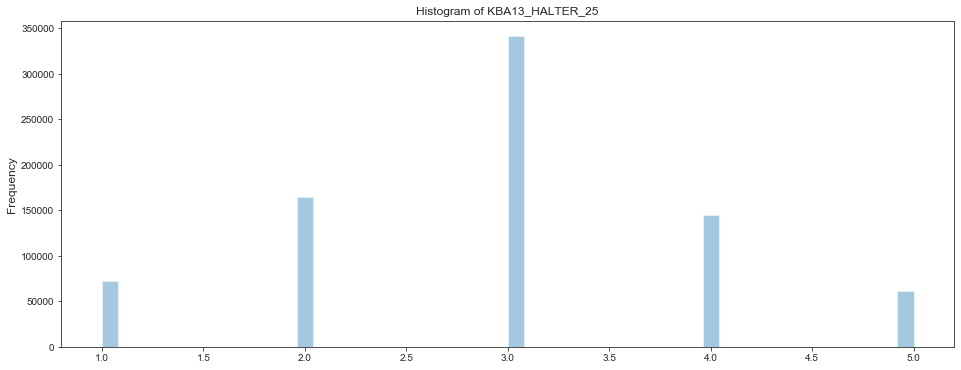

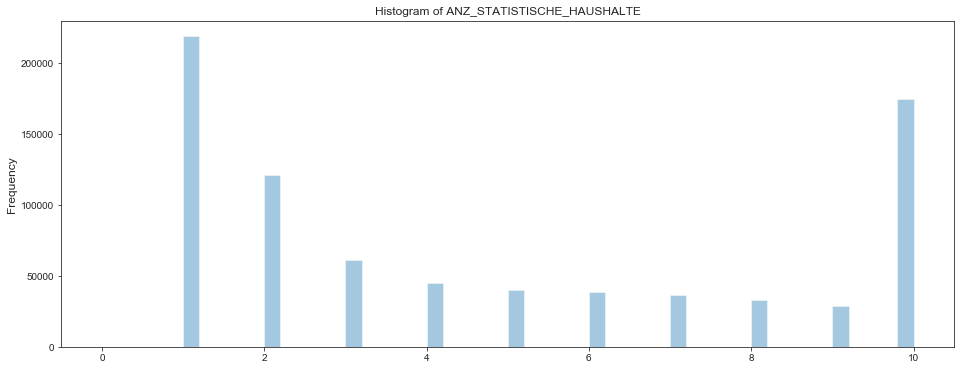

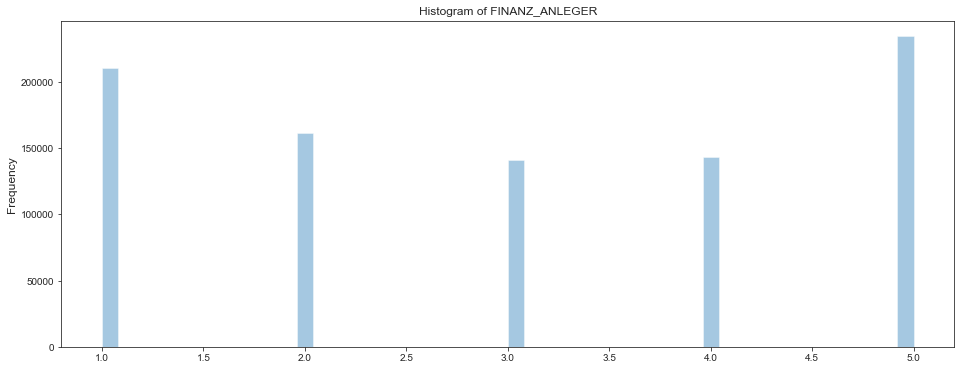

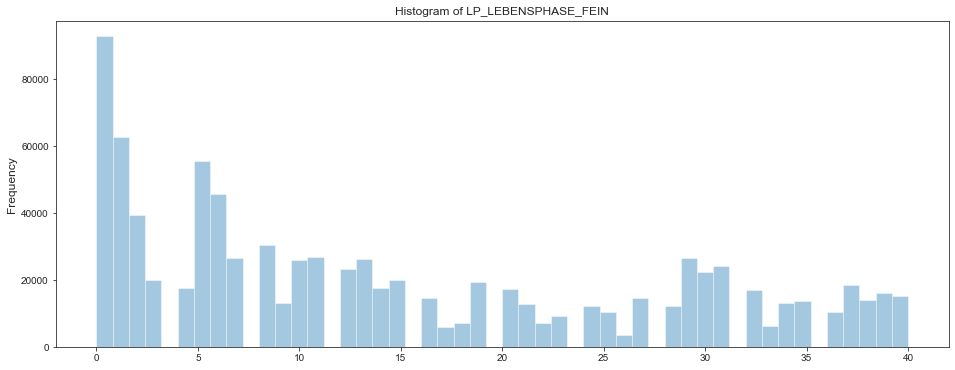

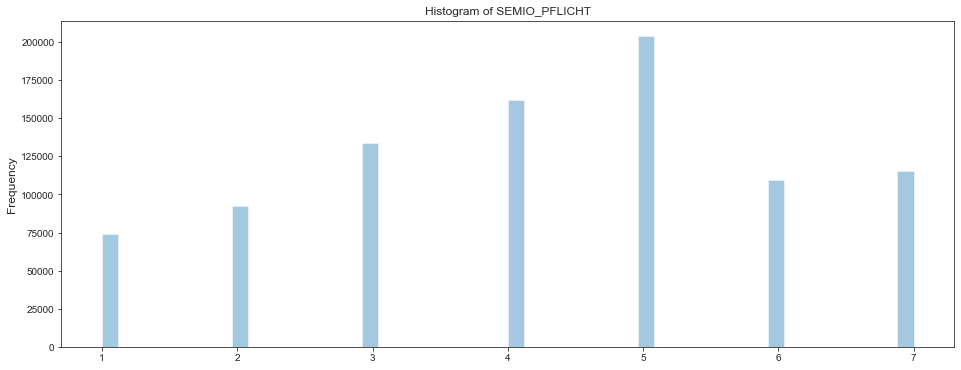

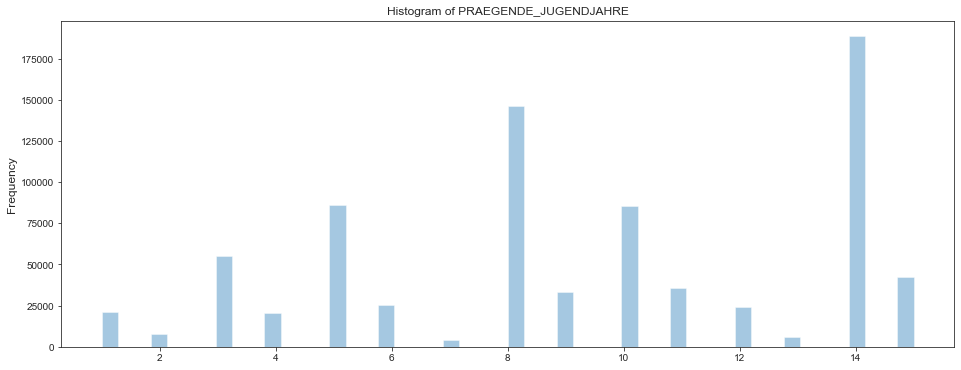

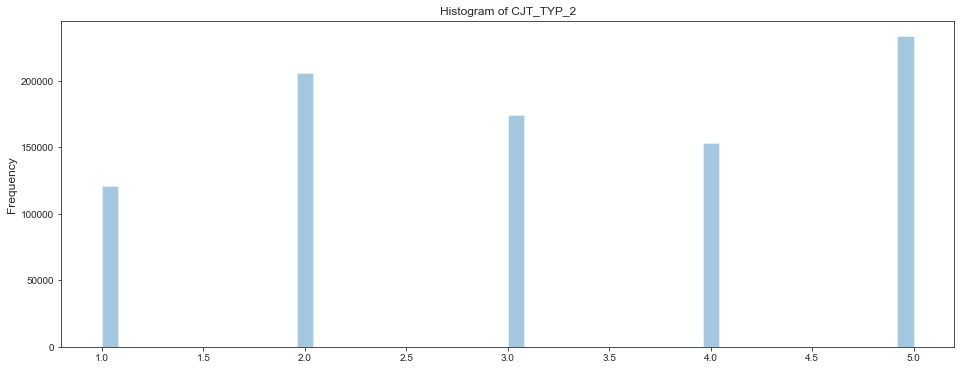

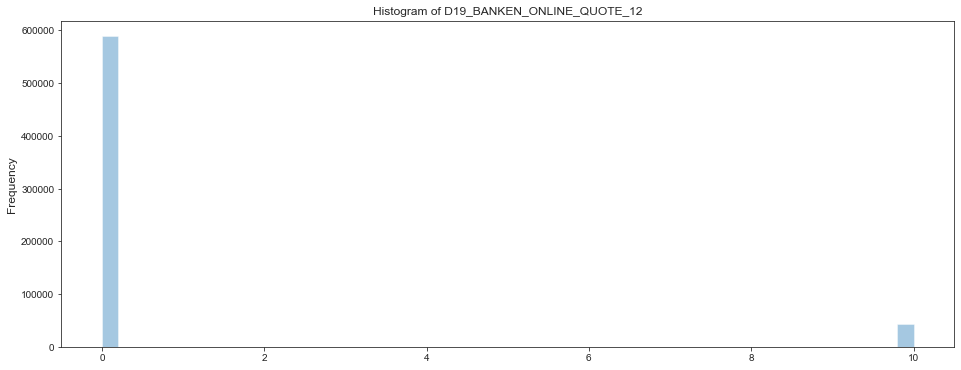

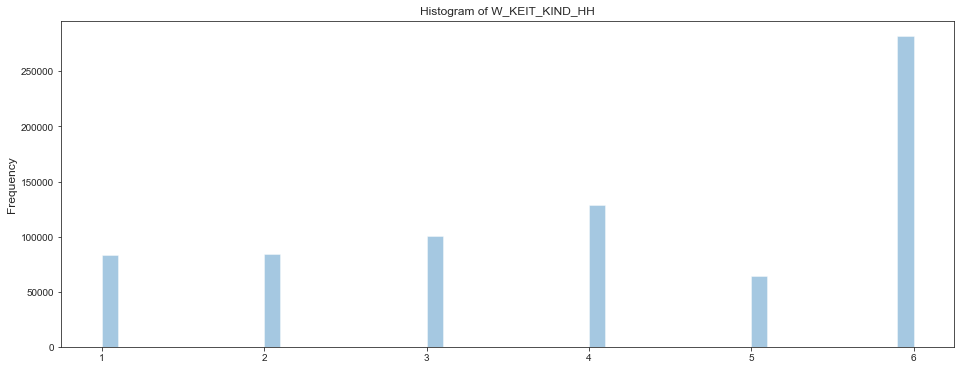

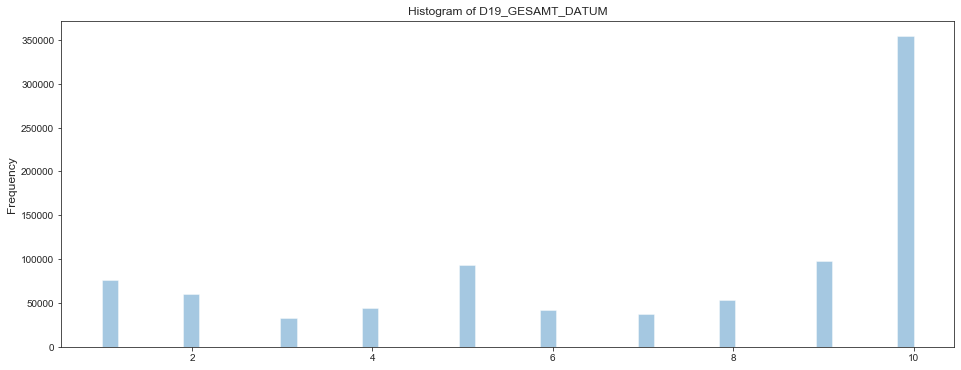

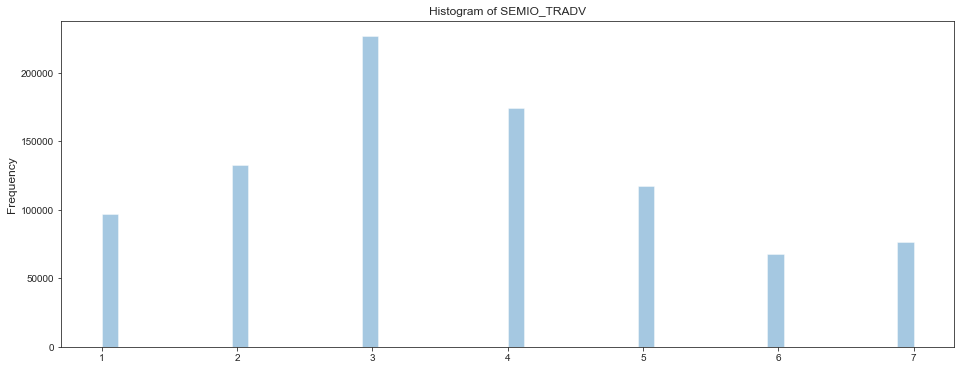

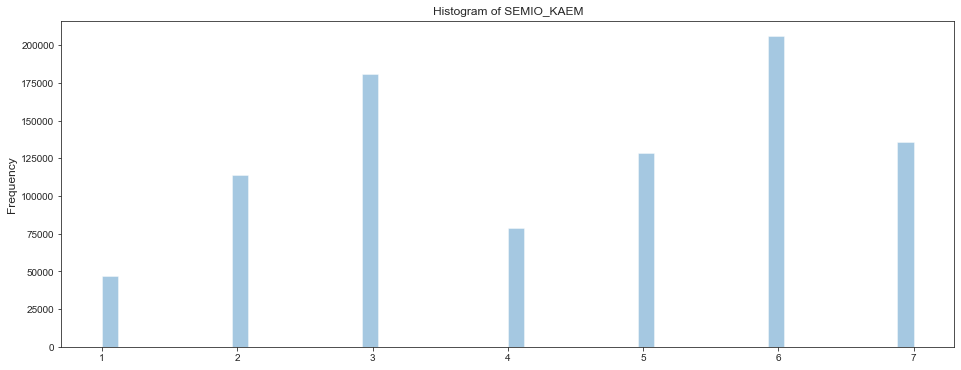

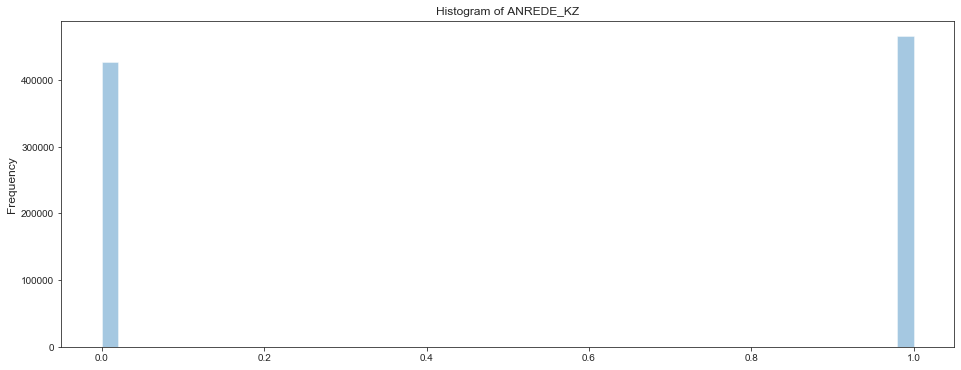

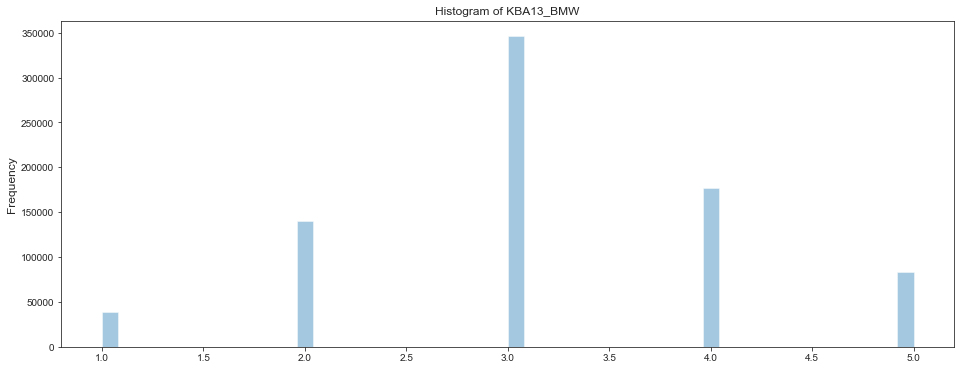

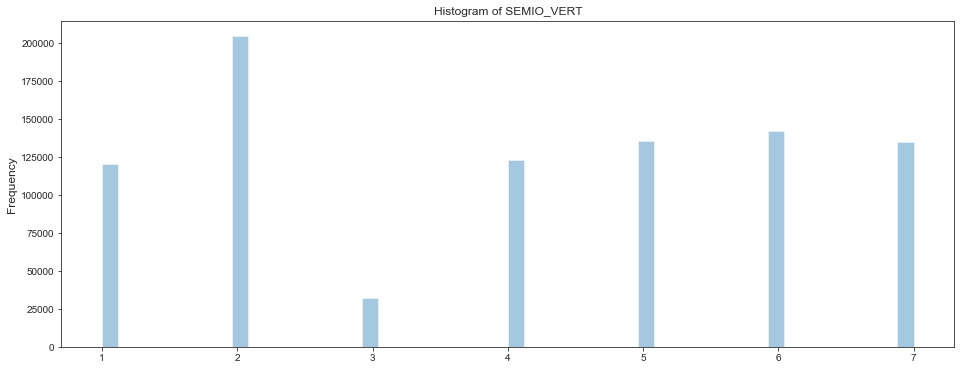

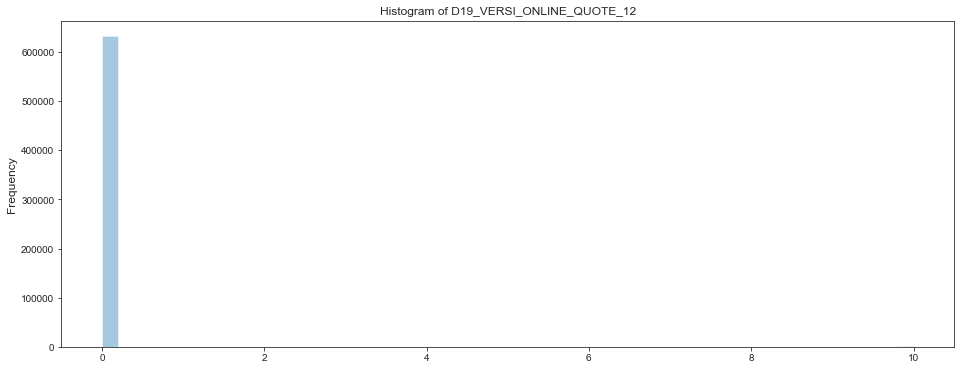

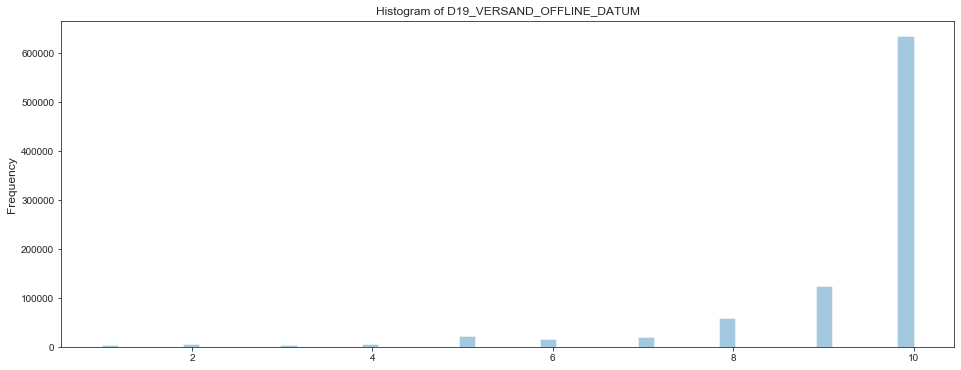

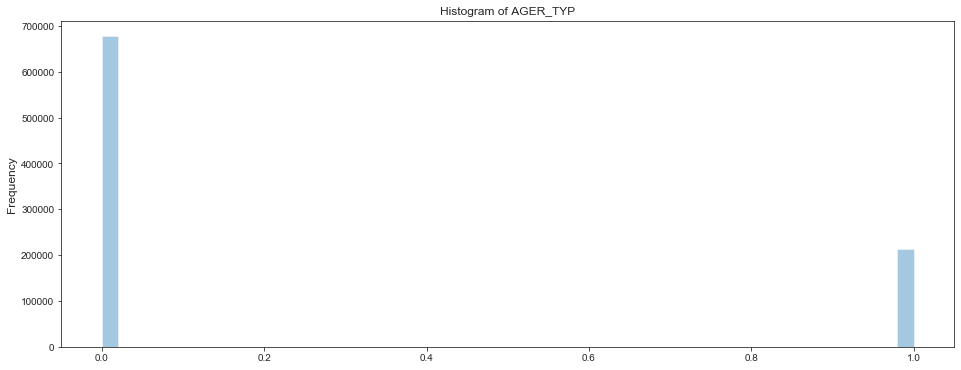

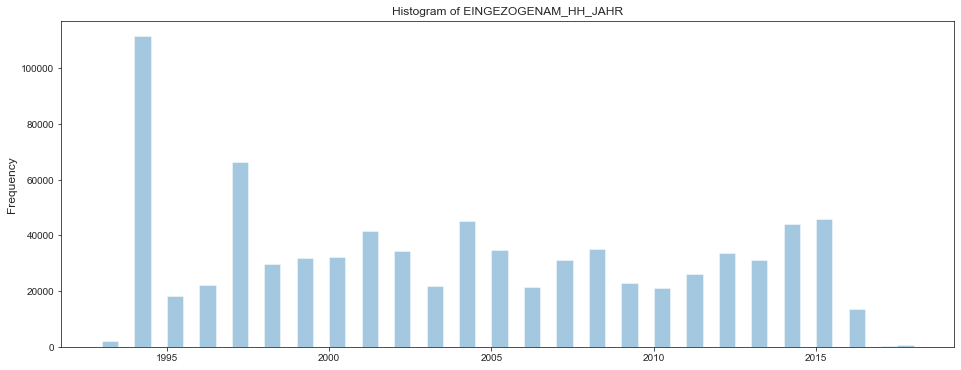

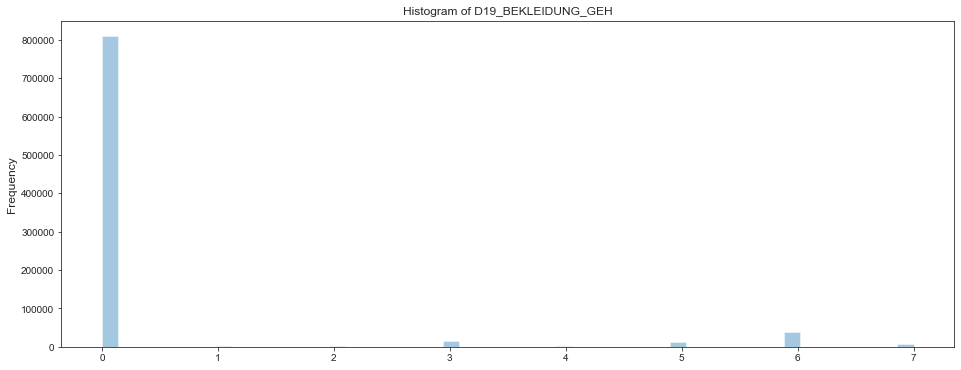

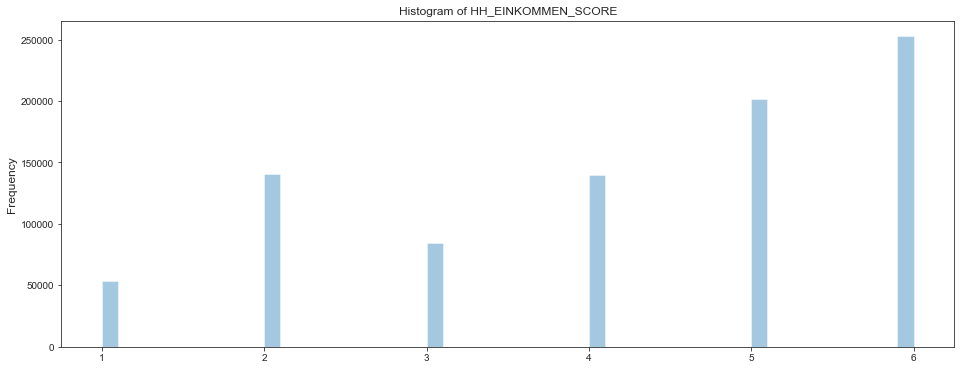

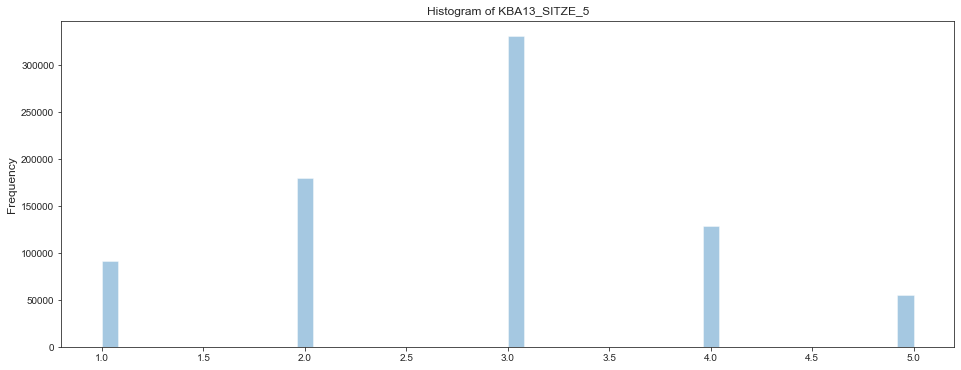

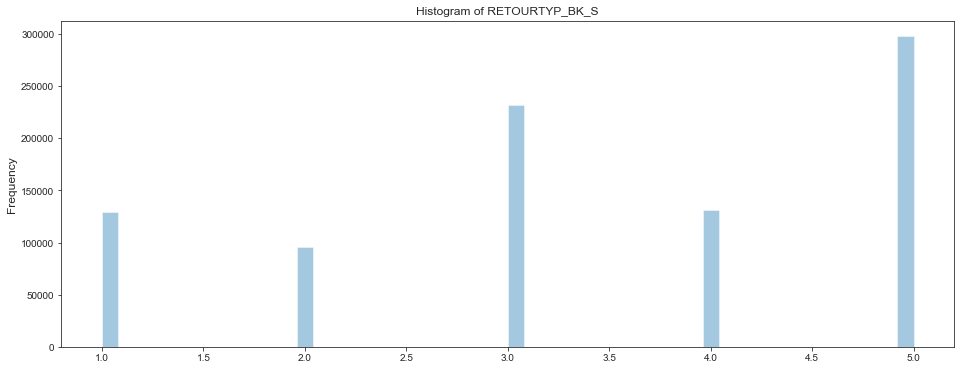

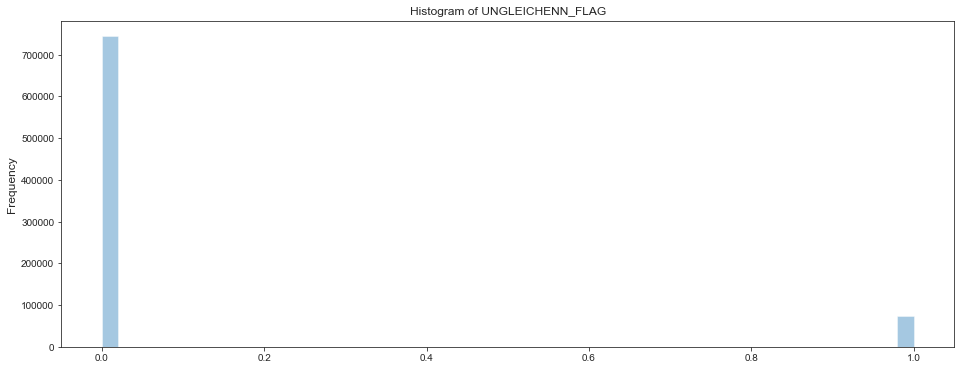

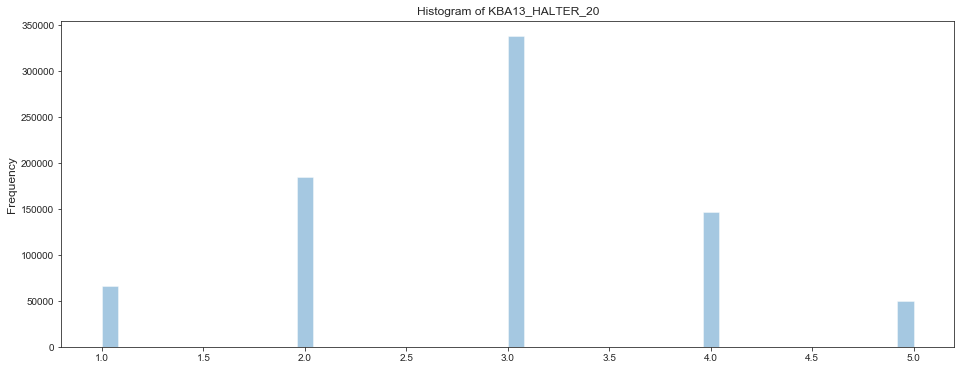

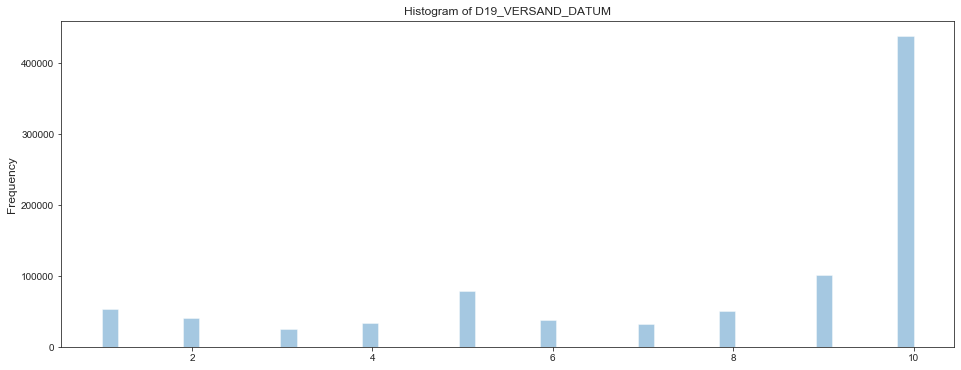

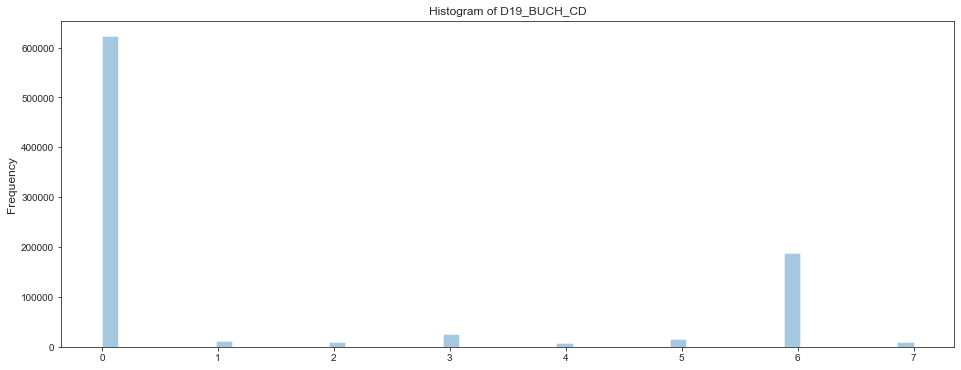

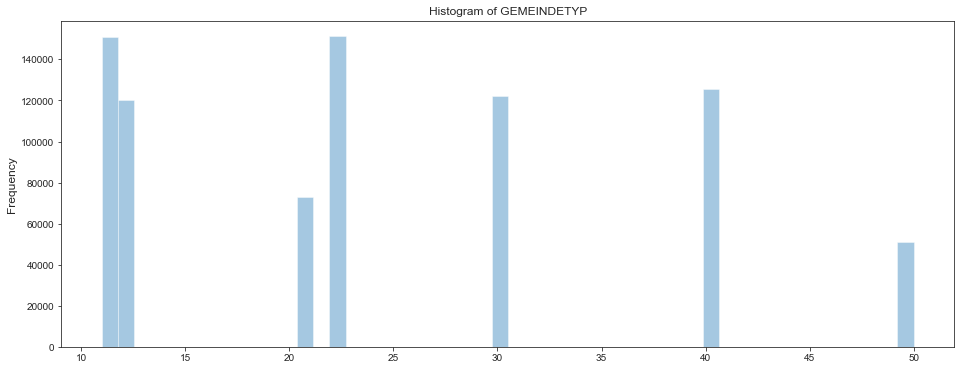

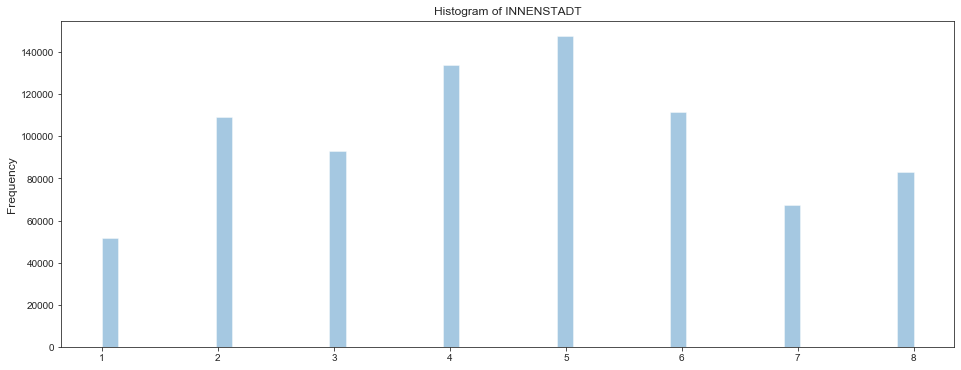

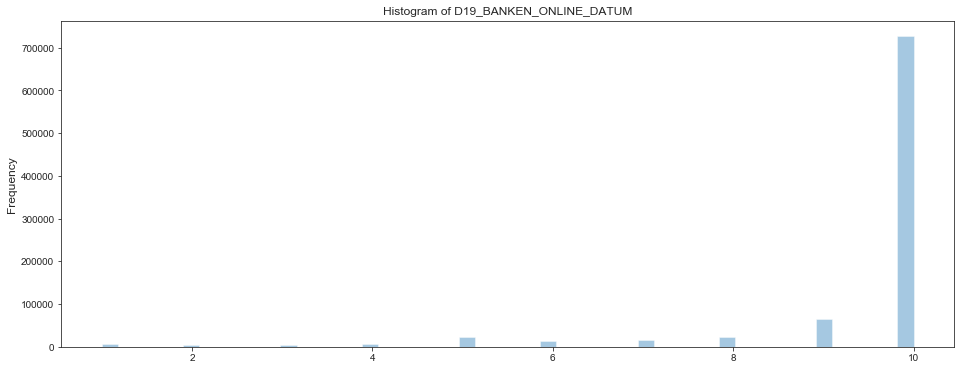

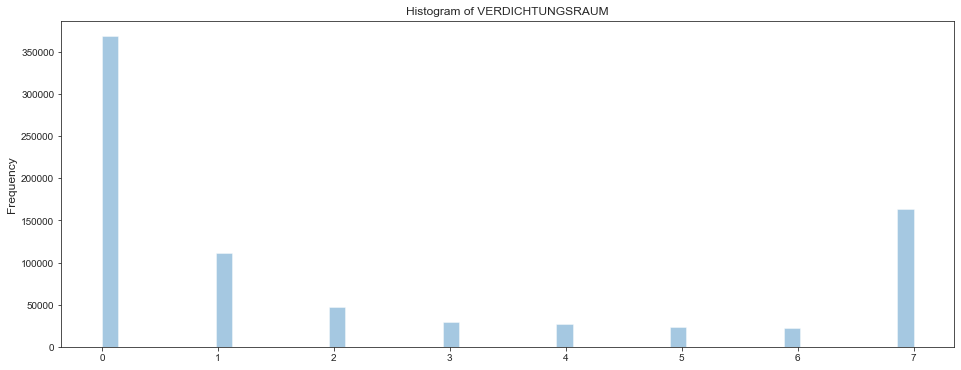

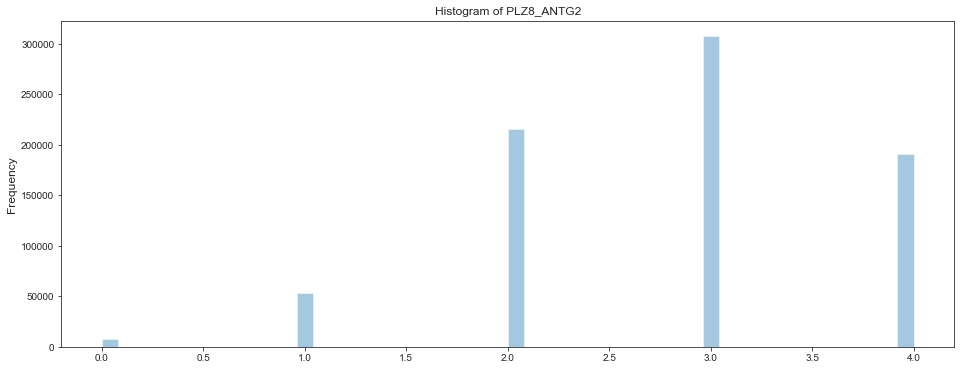

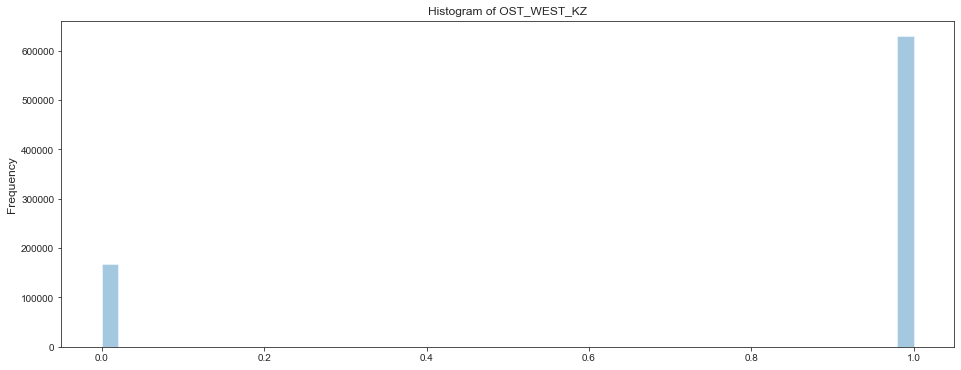

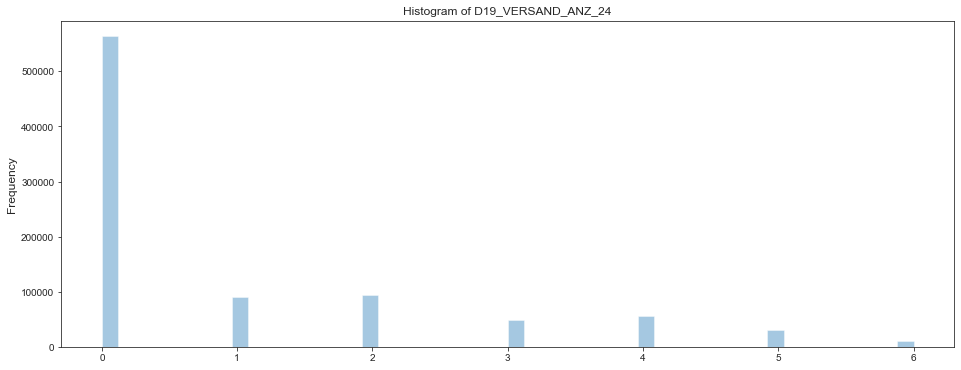

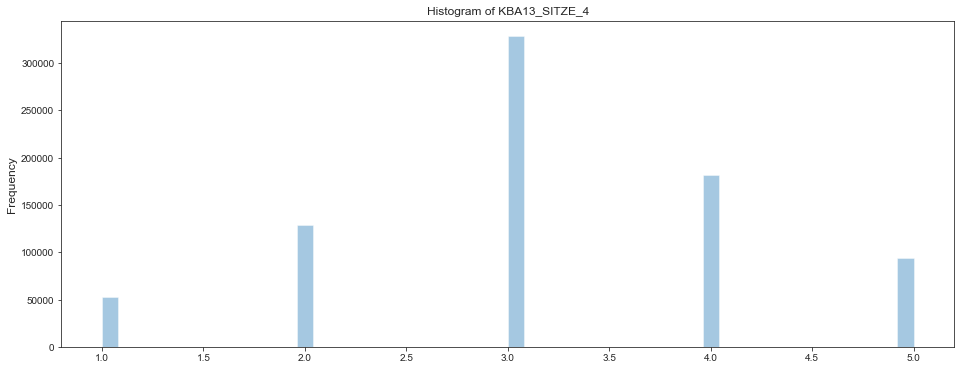

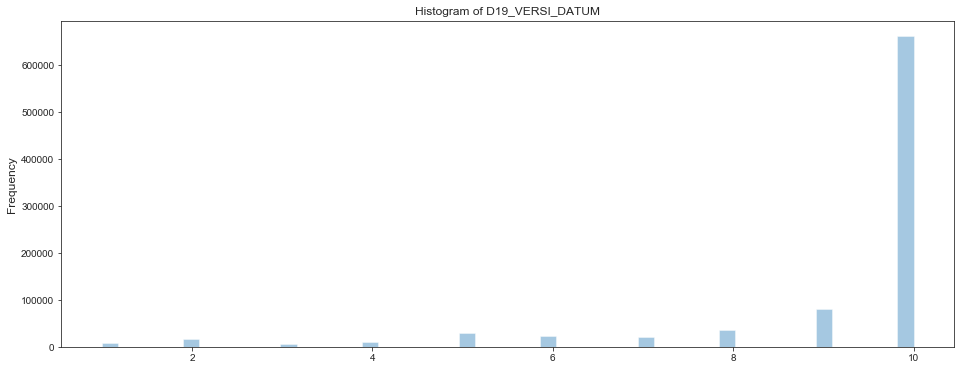

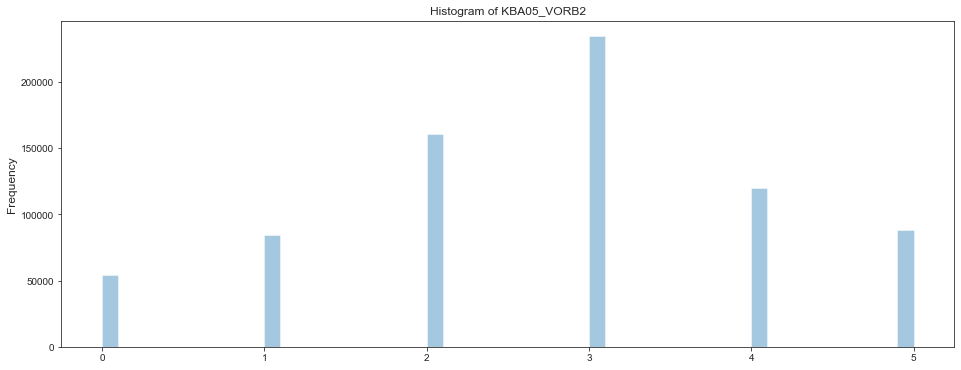

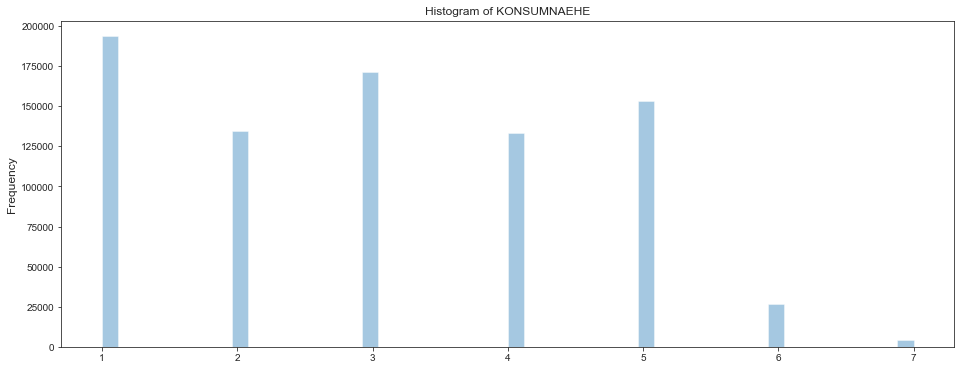

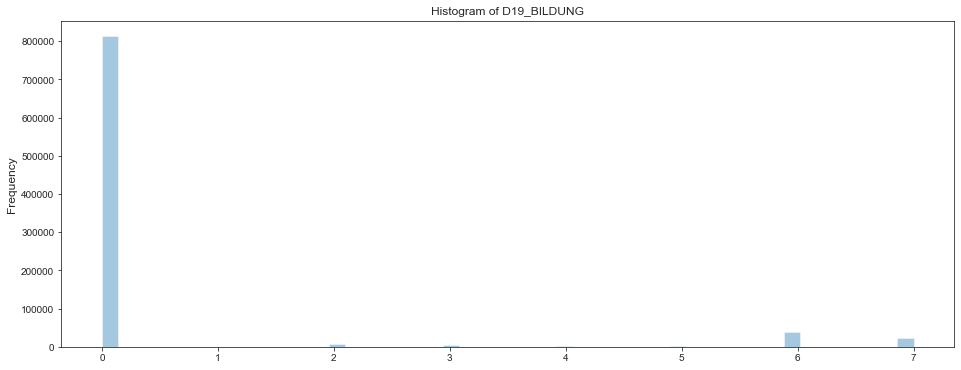

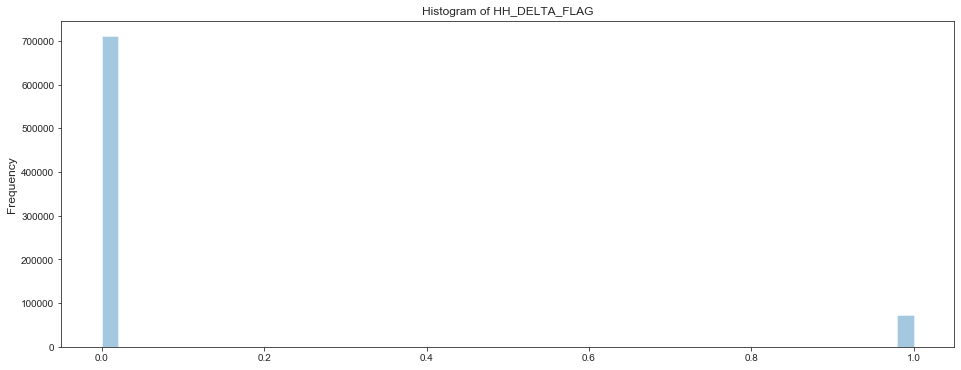

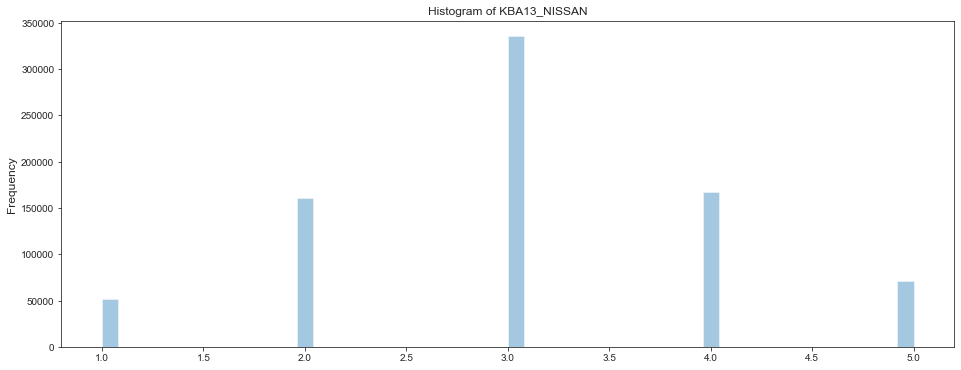

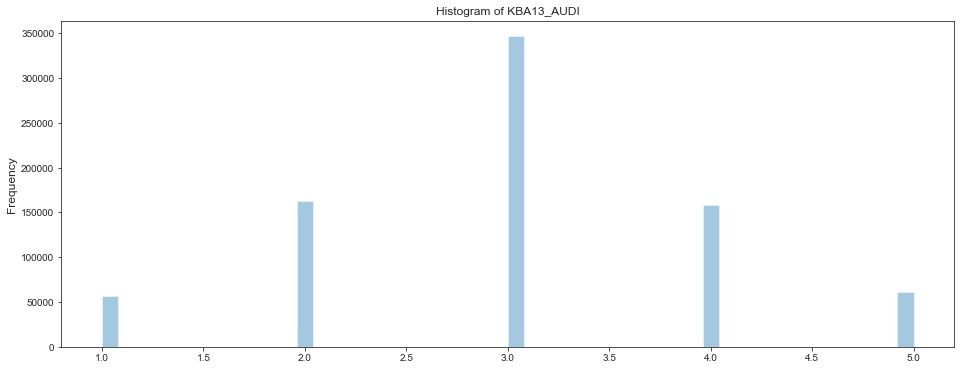

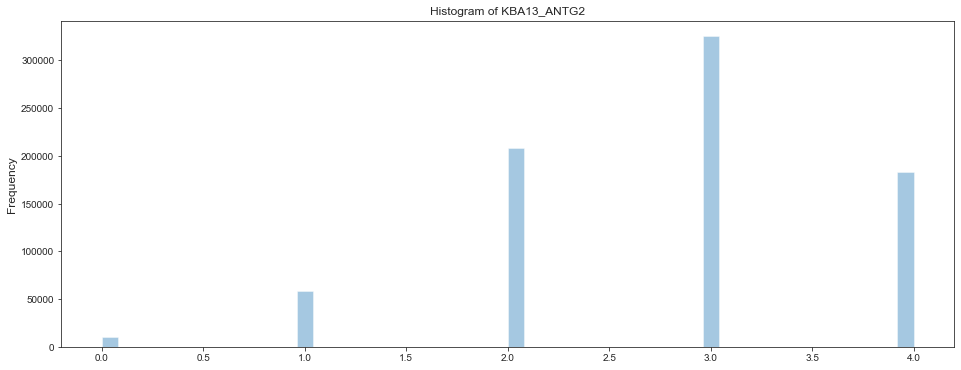

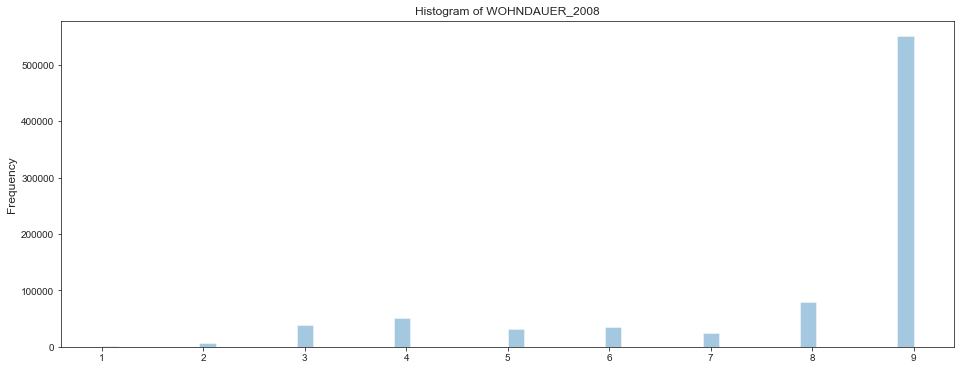

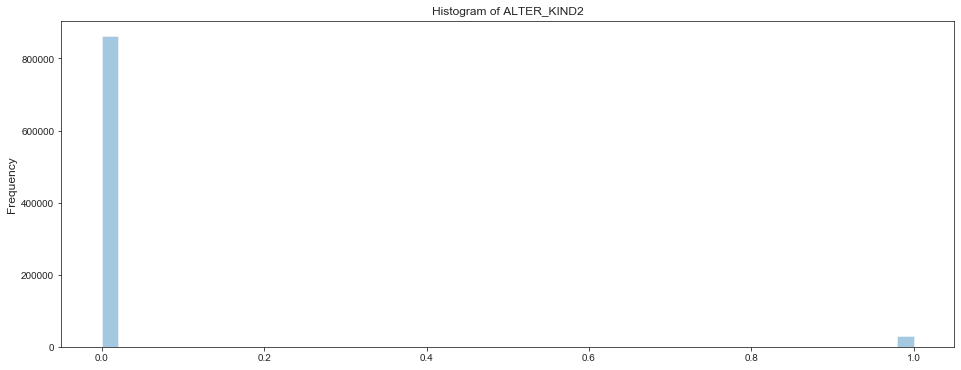

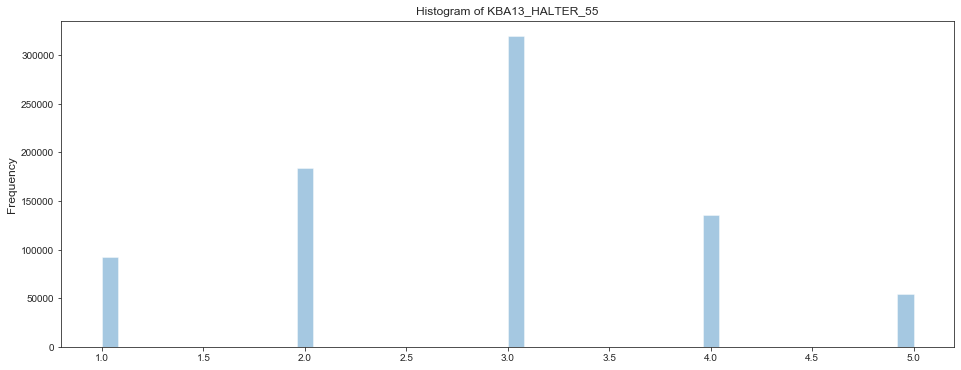

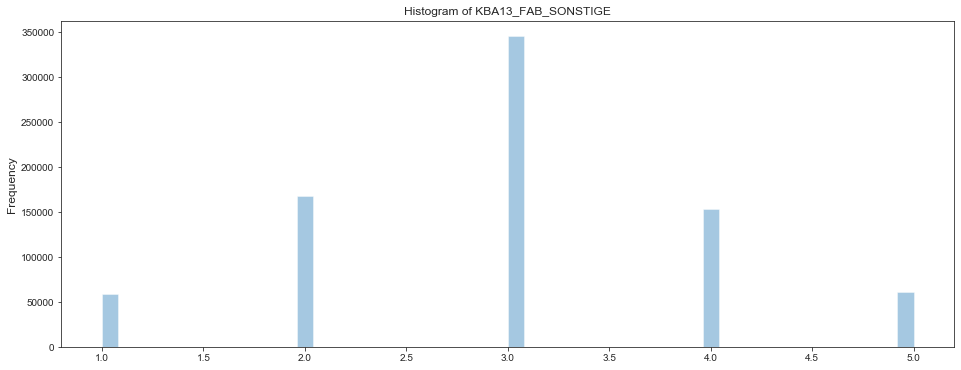

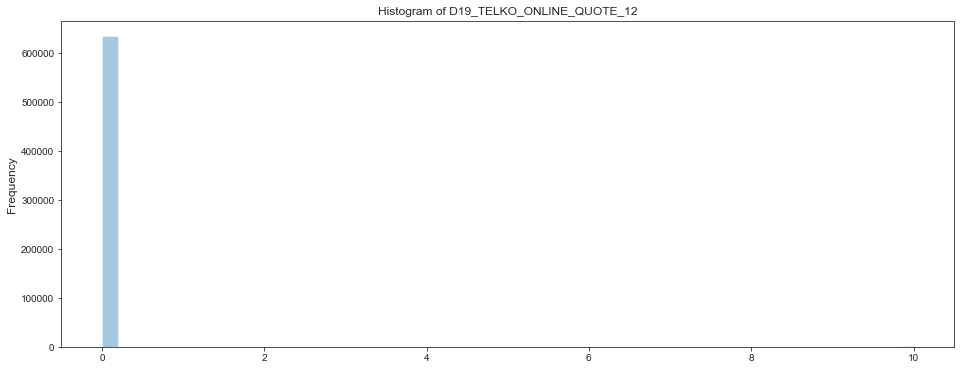

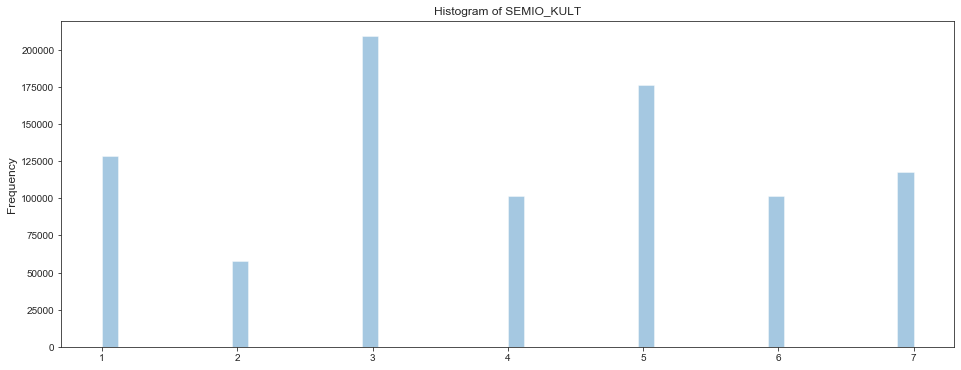

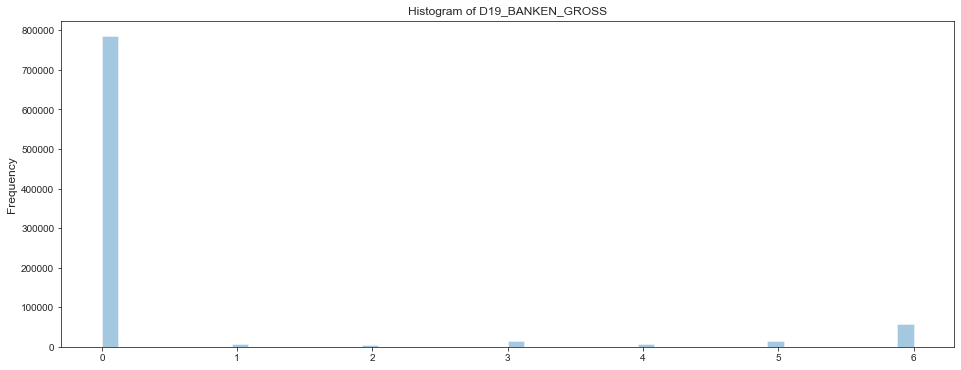

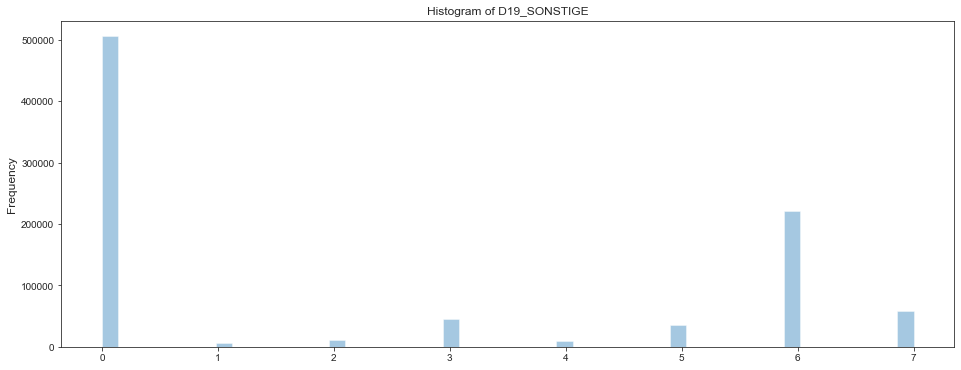

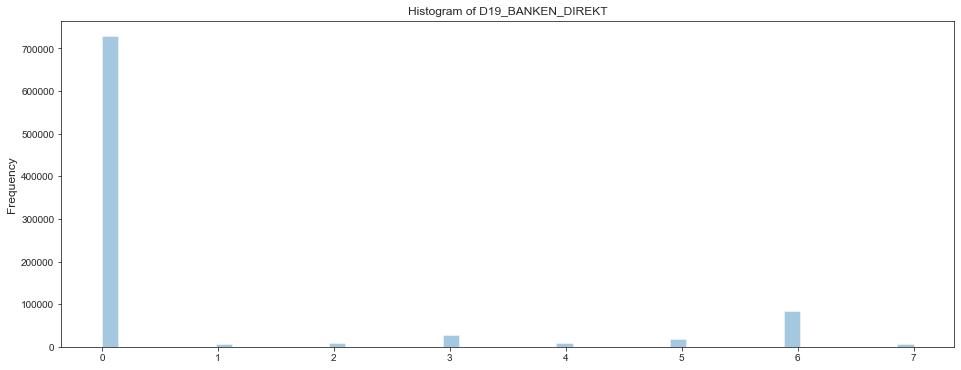

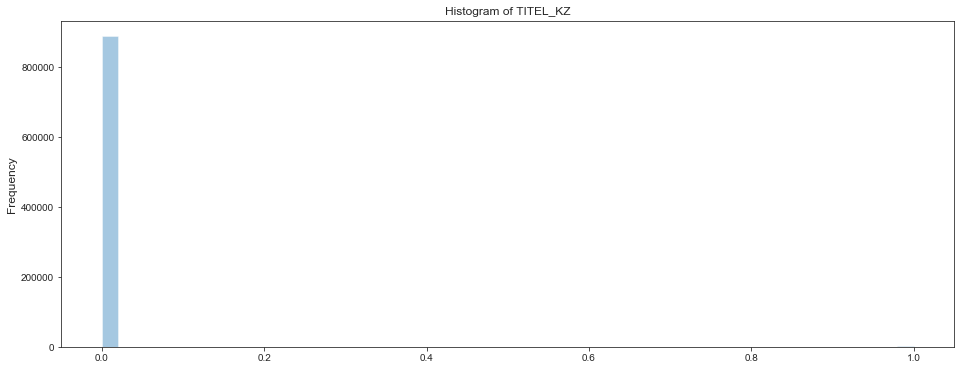

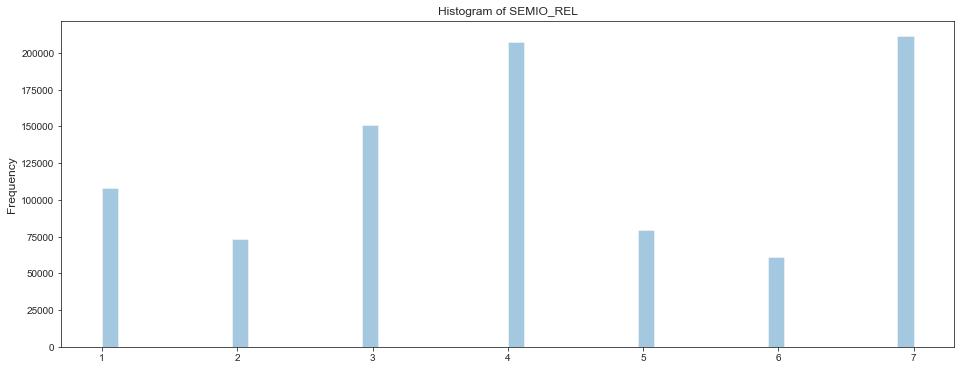

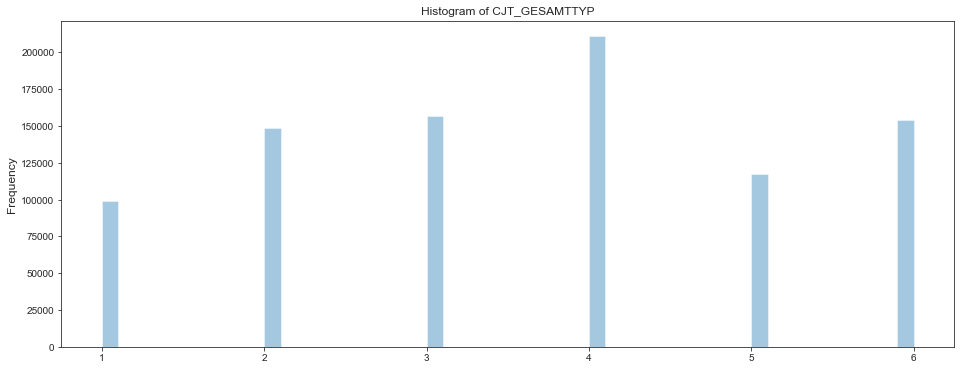

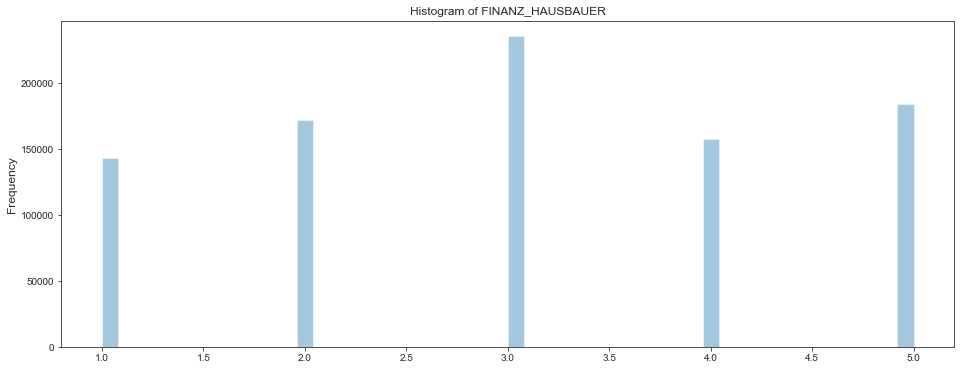

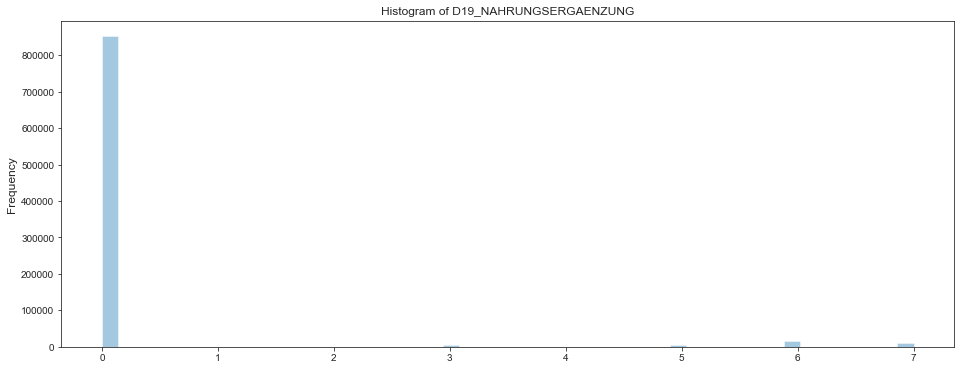

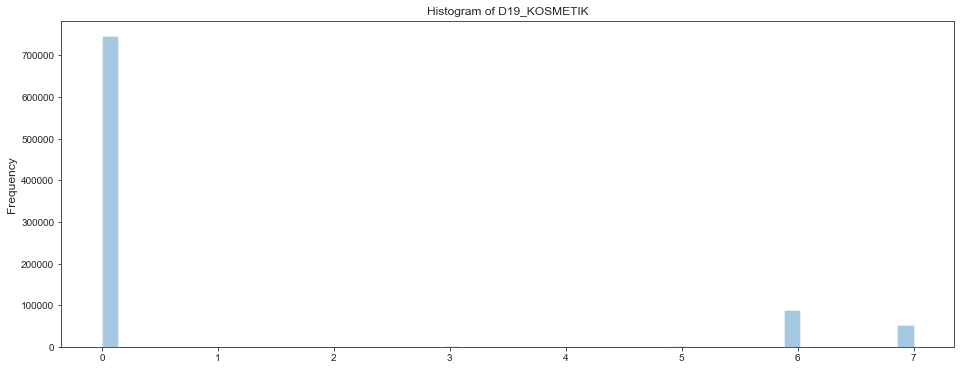

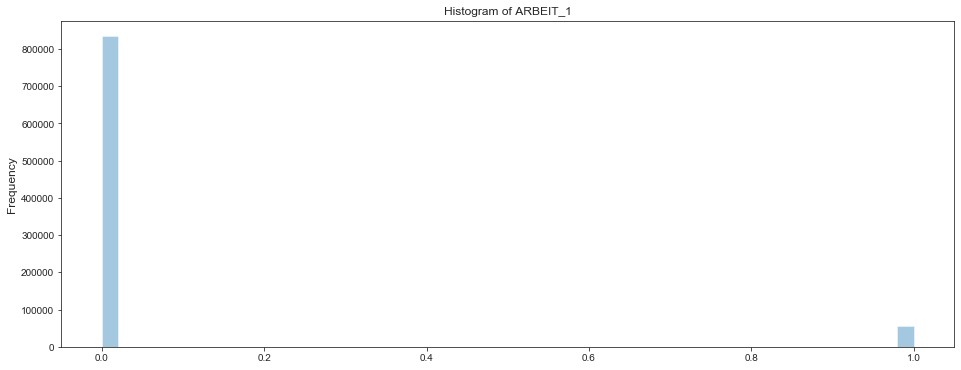

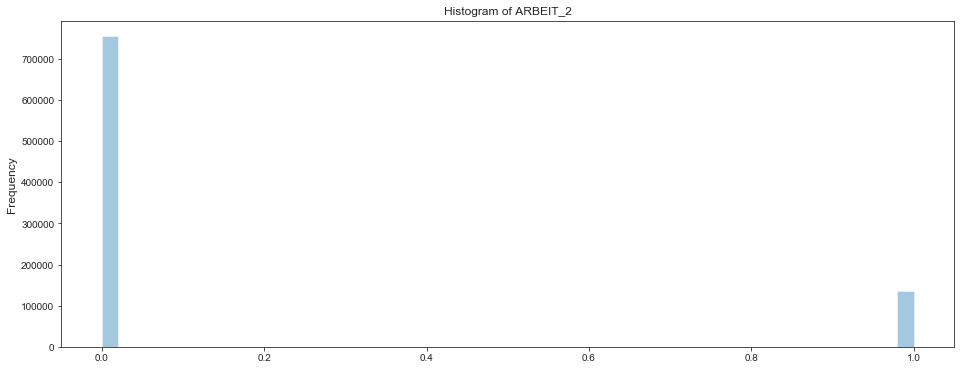

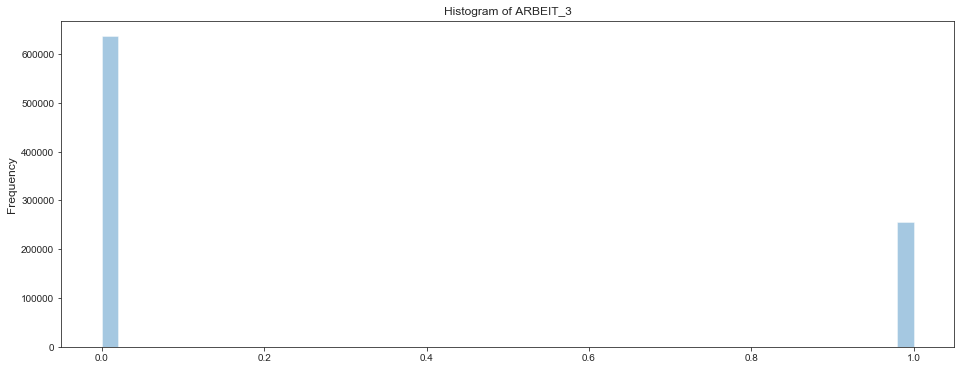

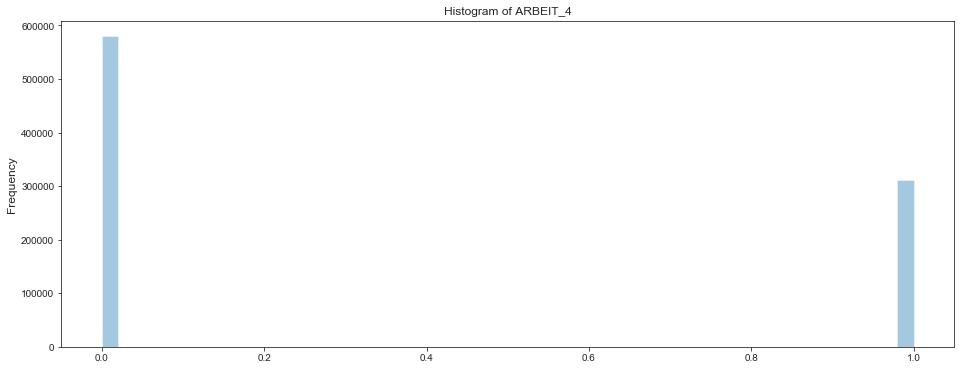

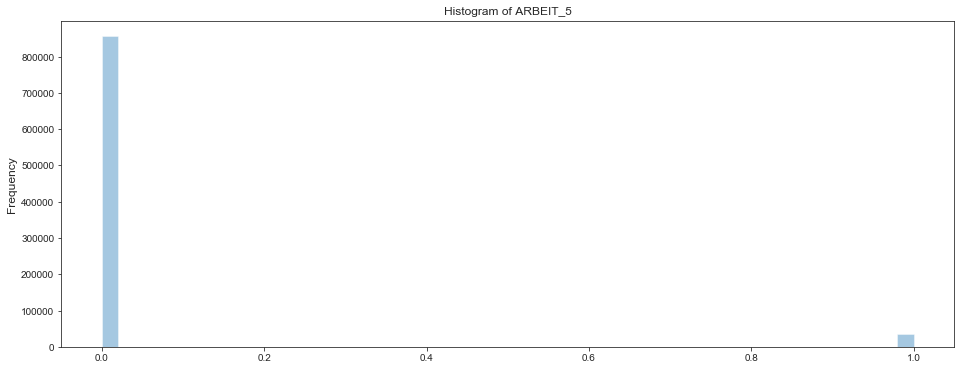

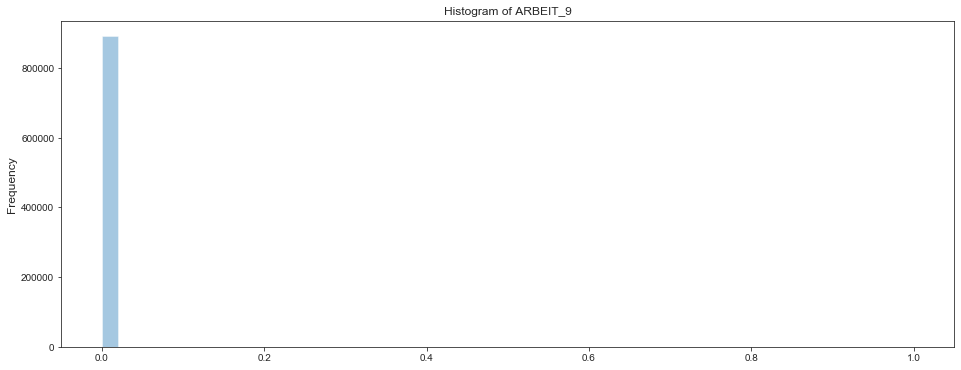

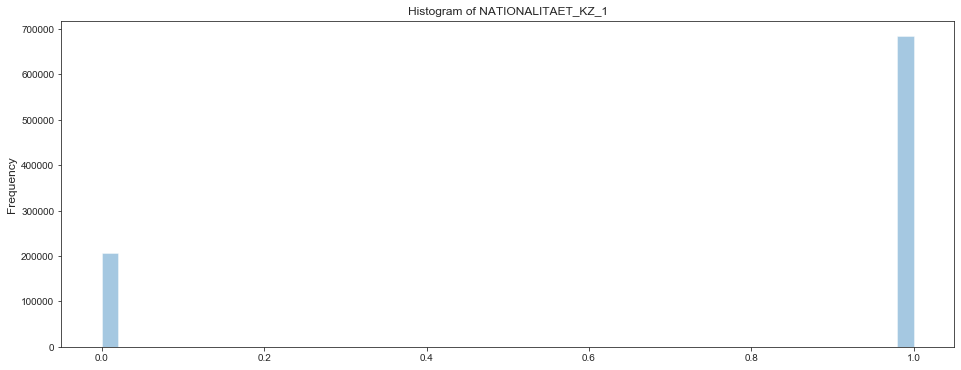

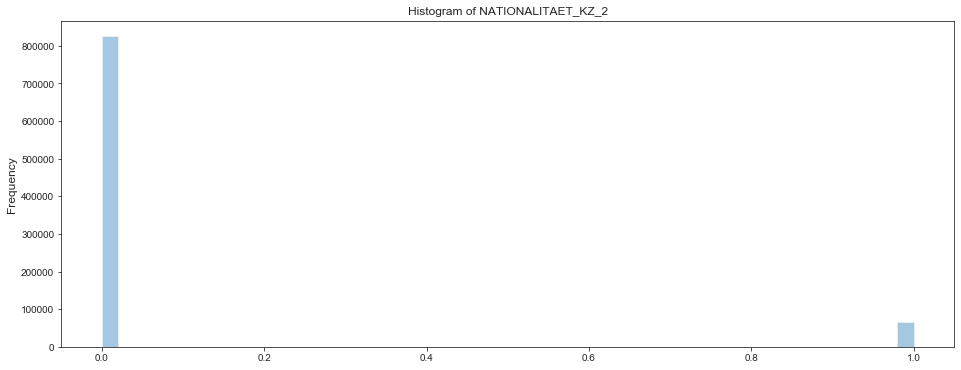

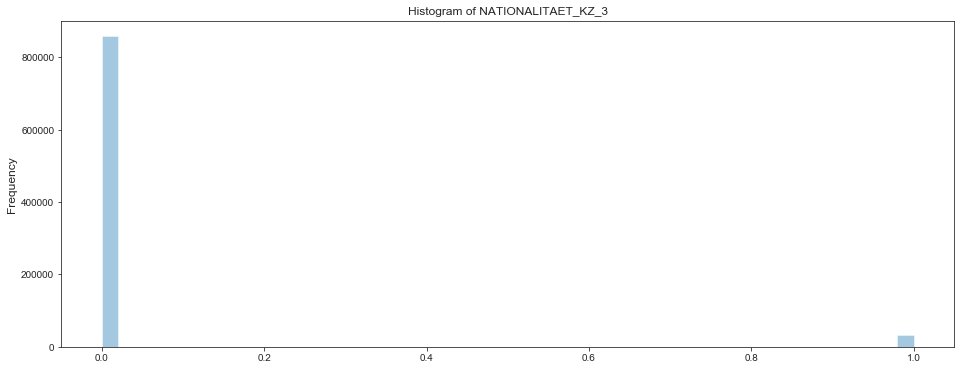

In [26]:
plot_hists(azdias_clean,azdias_clean.columns)

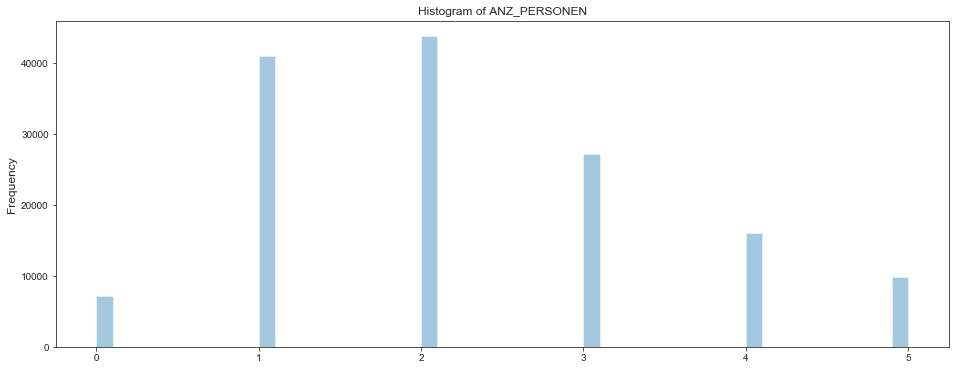

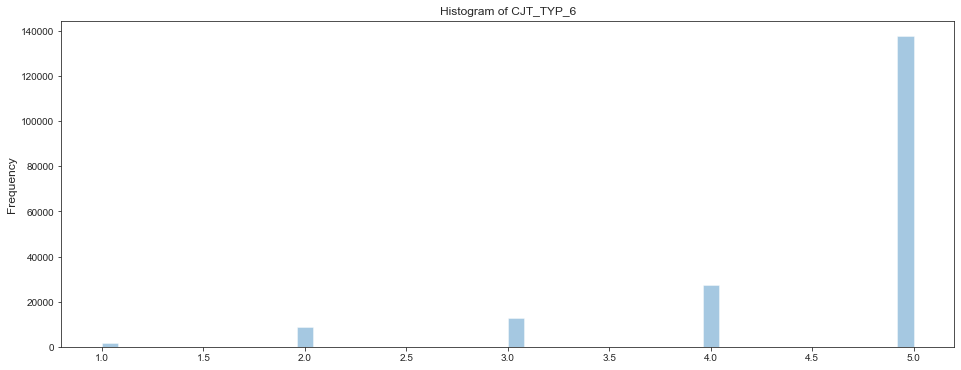

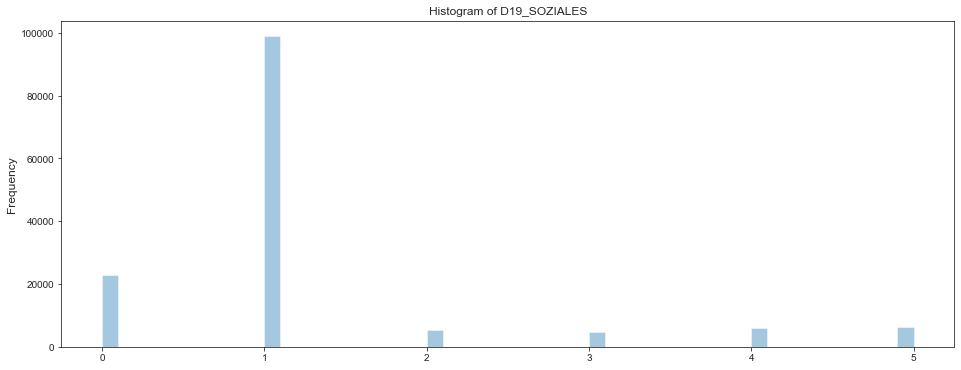

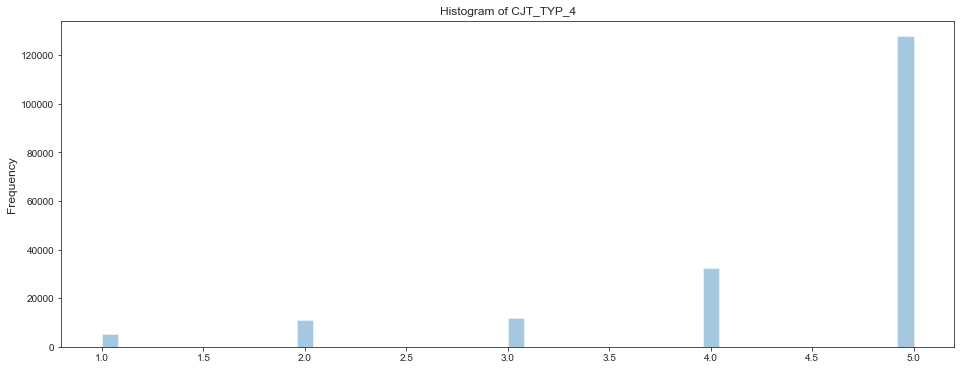

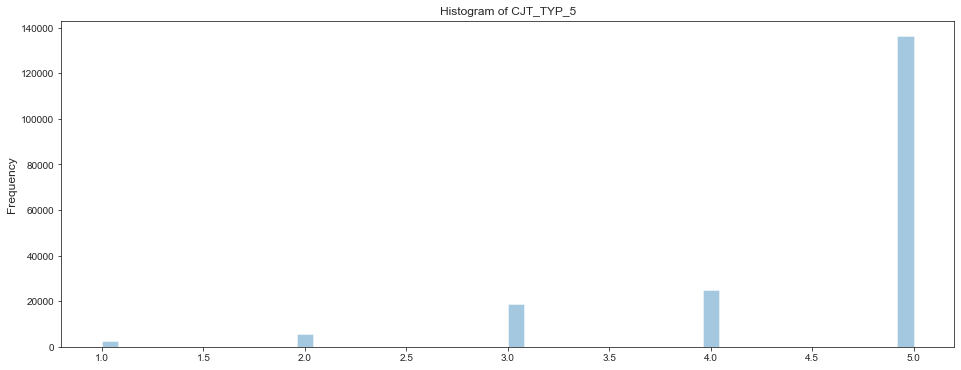

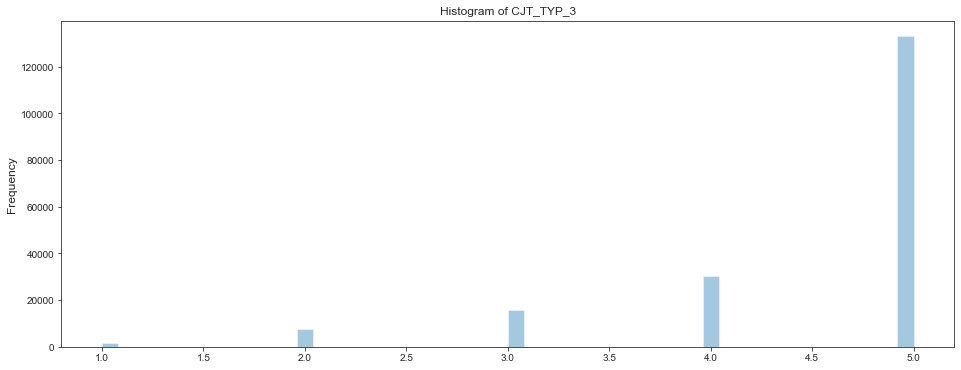

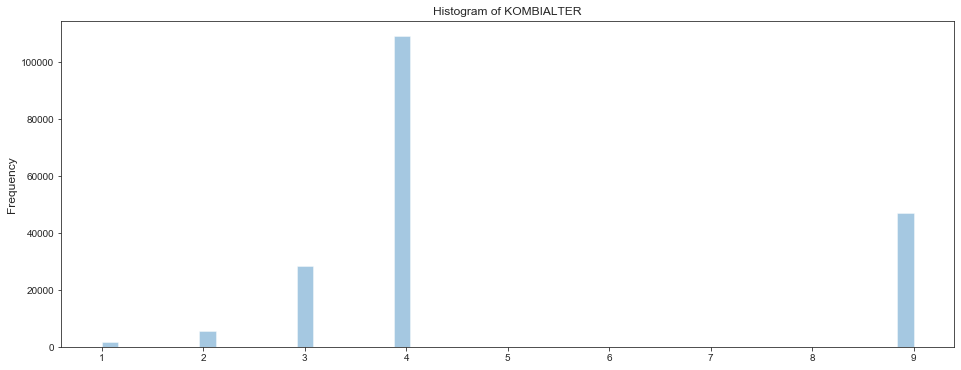

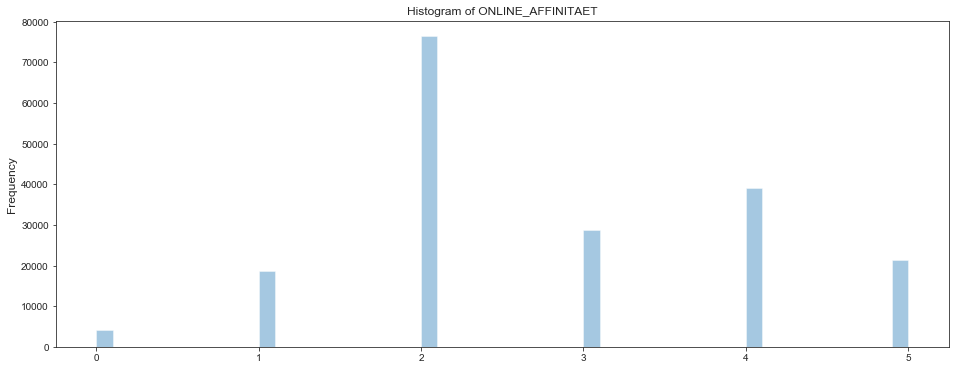

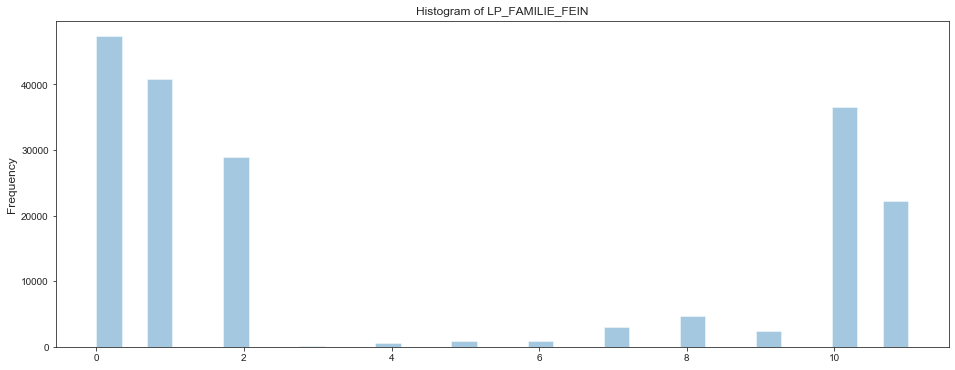

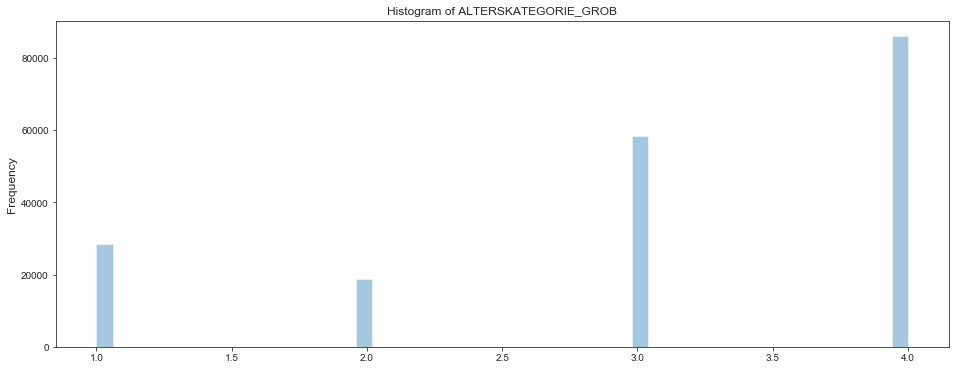

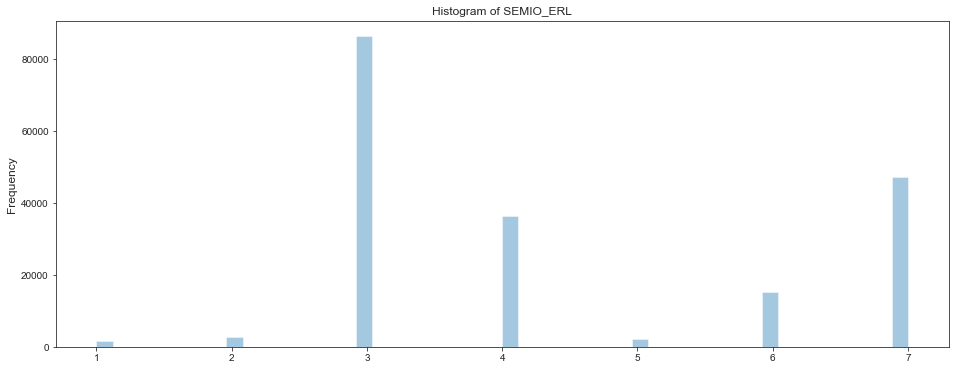

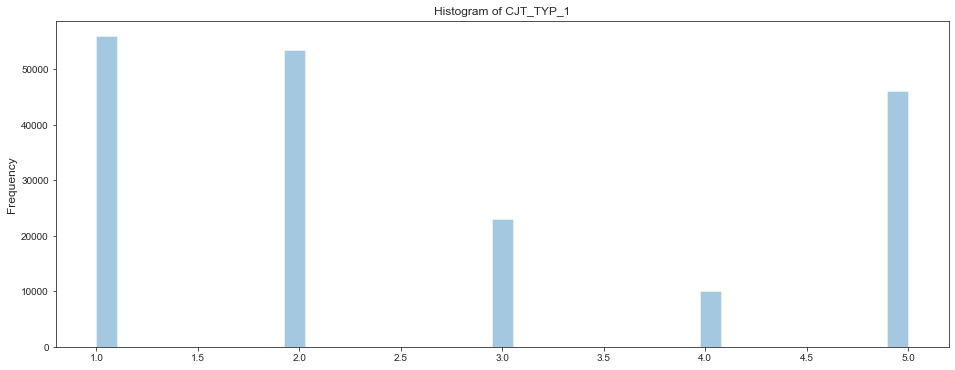

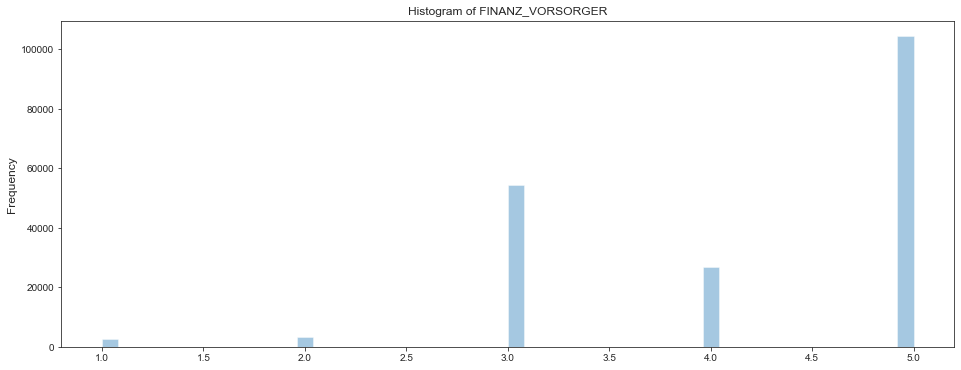

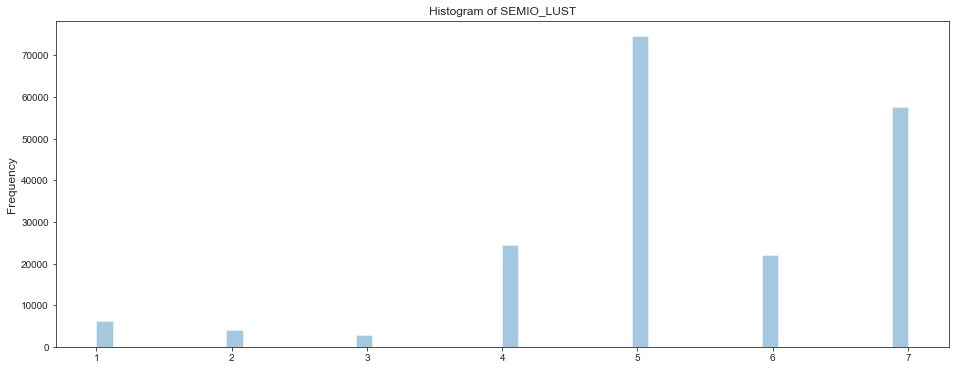

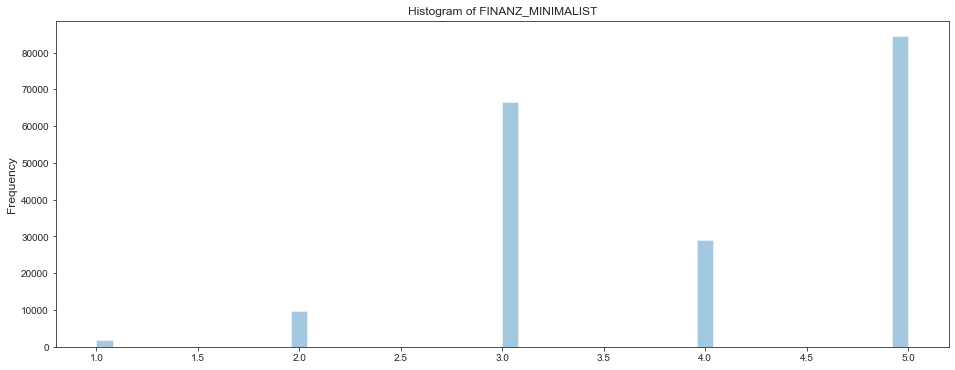

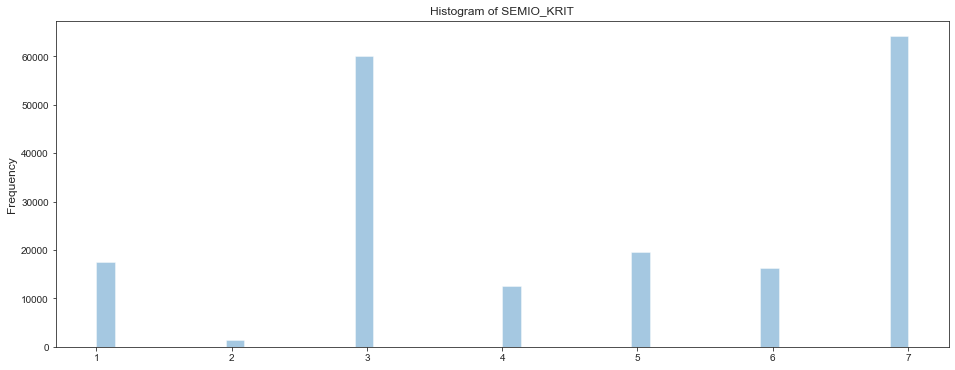

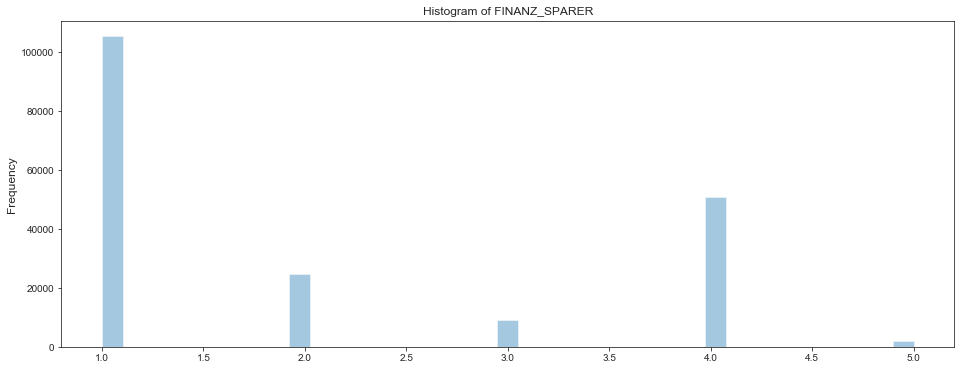

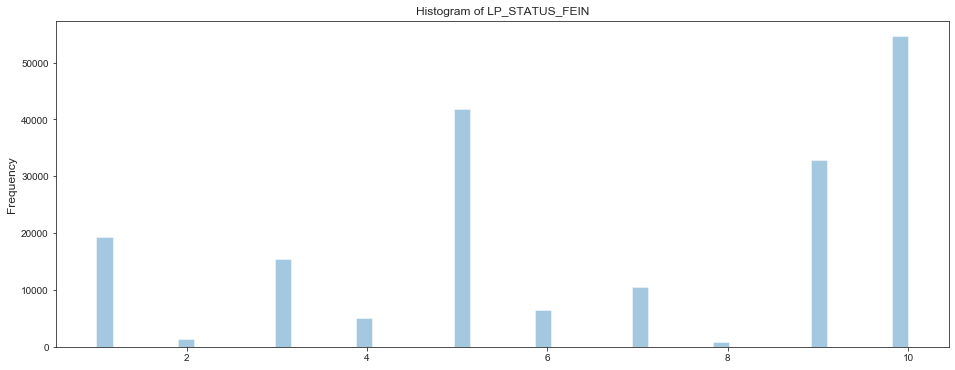

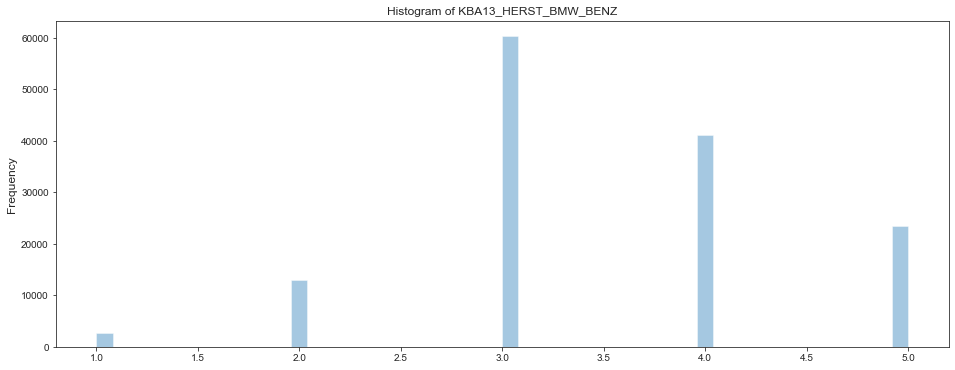

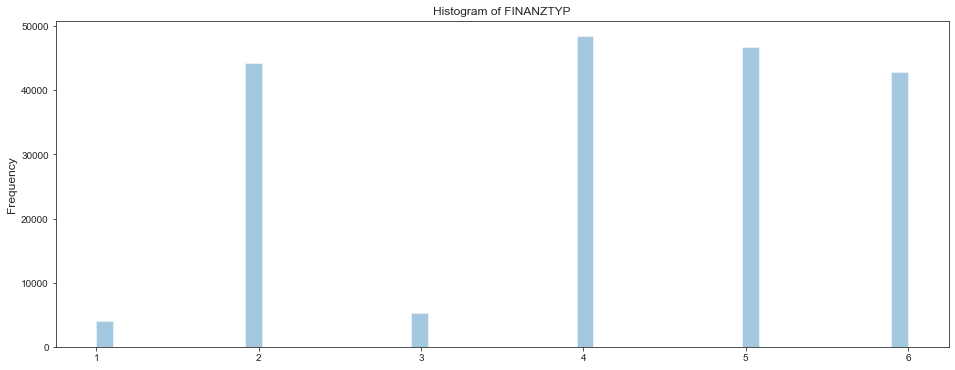

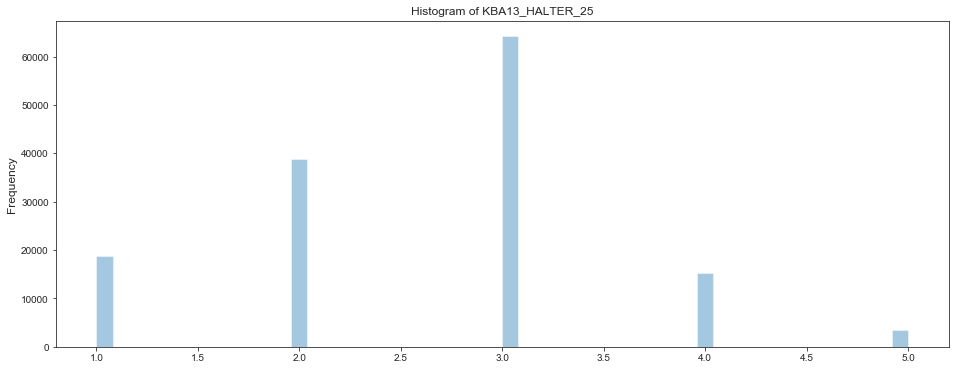

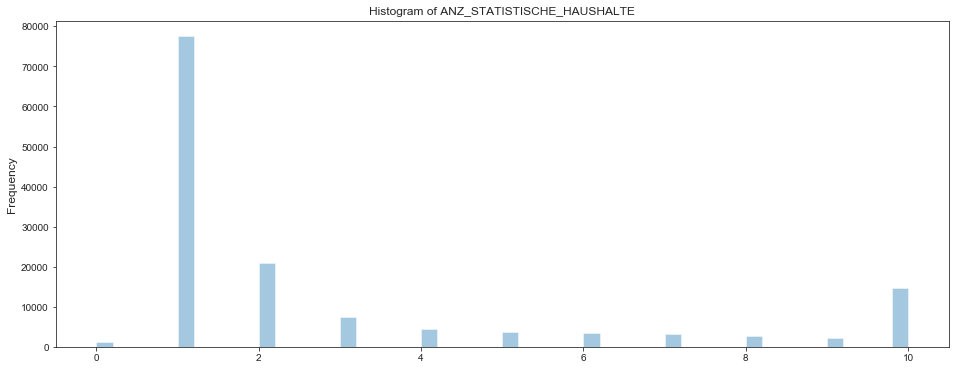

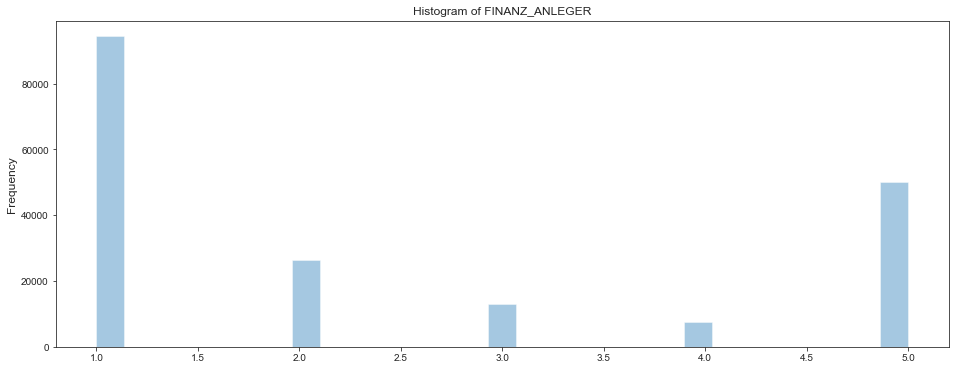

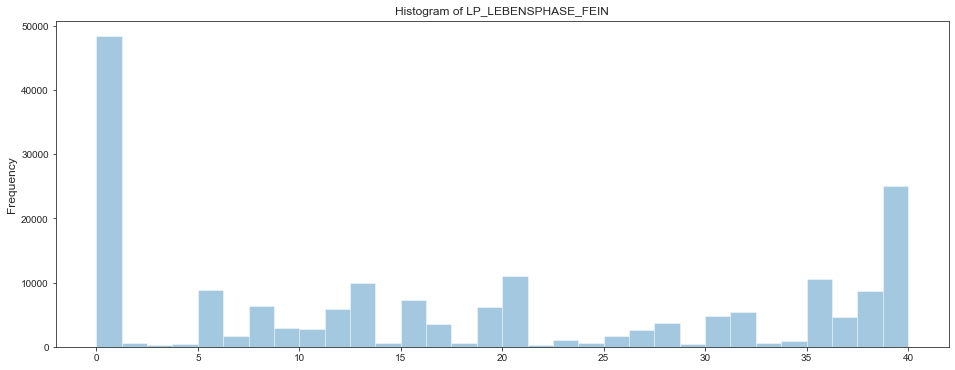

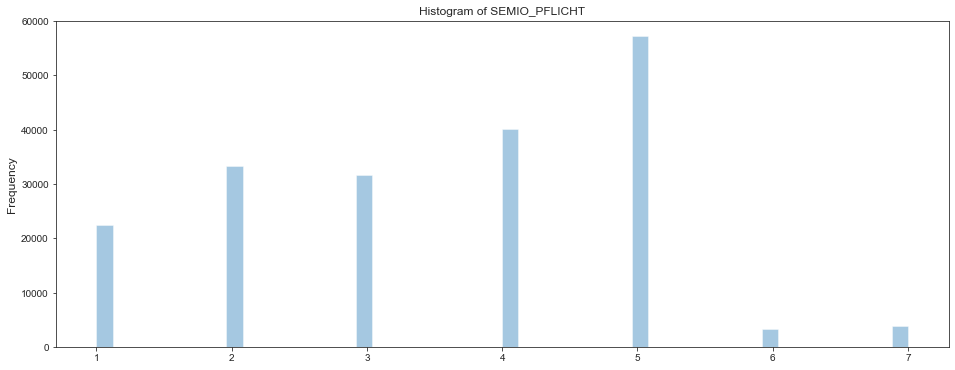

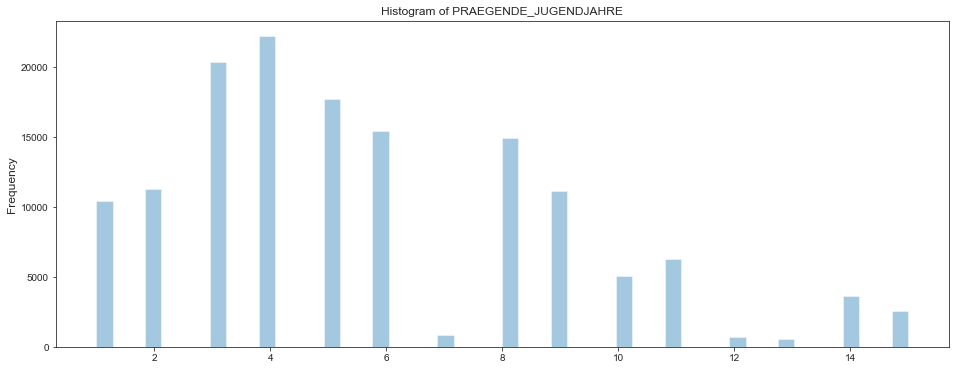

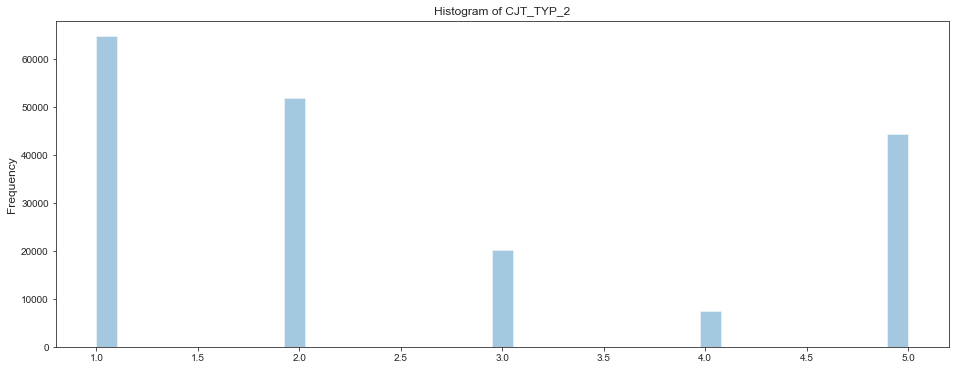

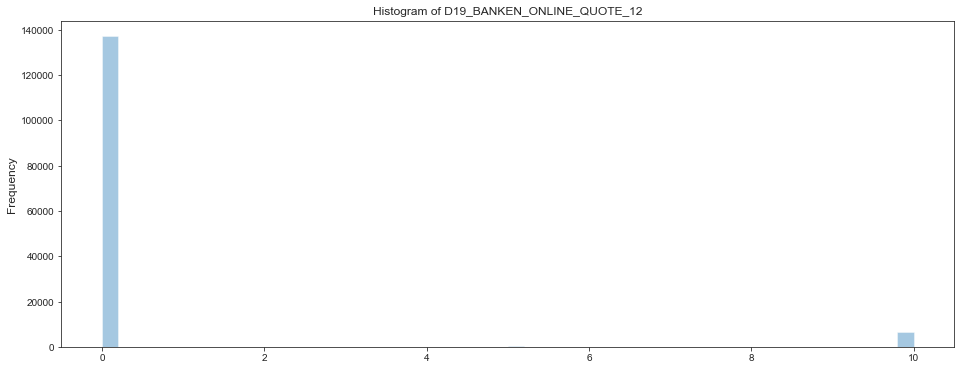

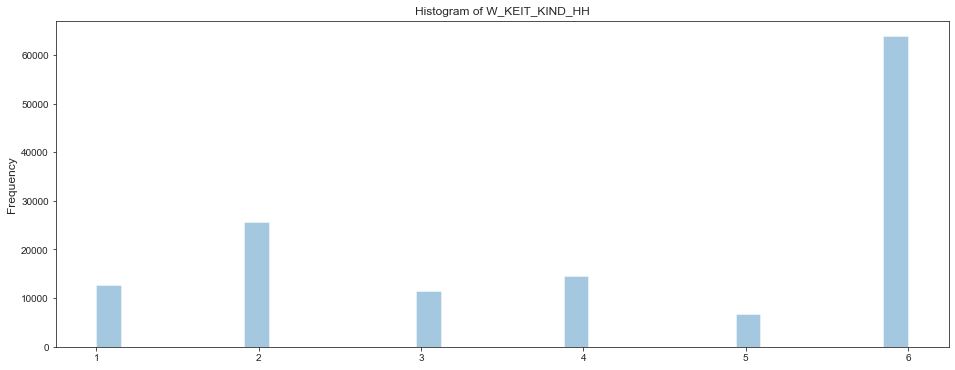

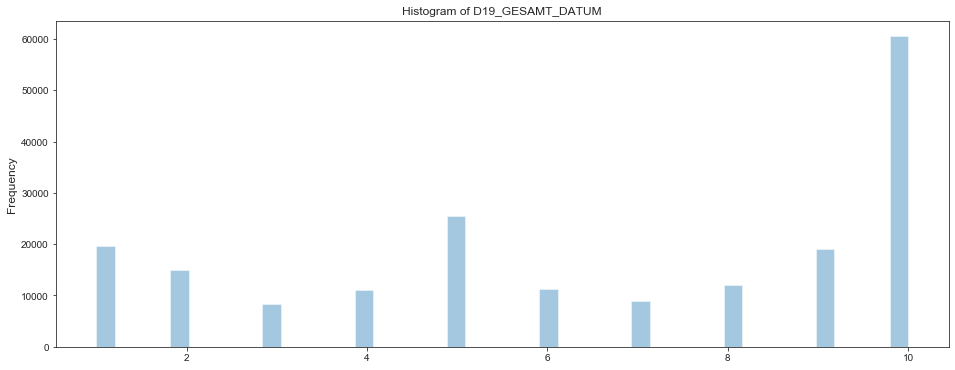

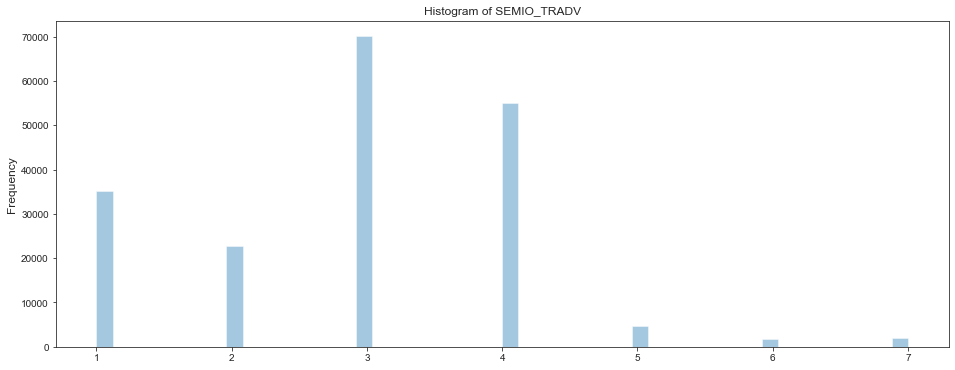

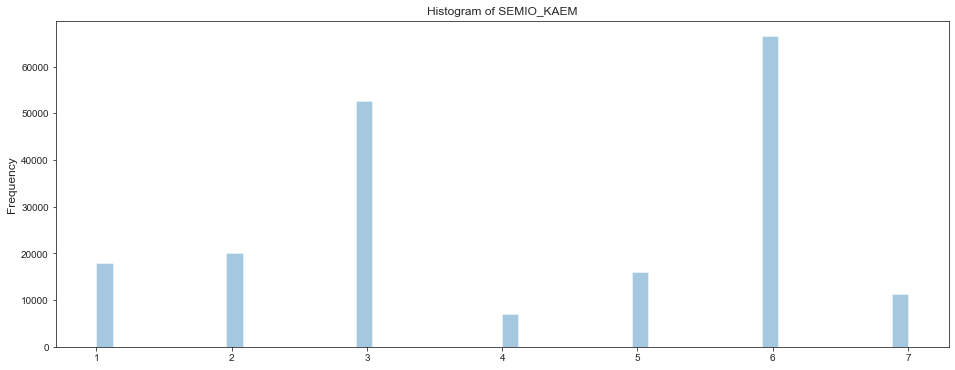

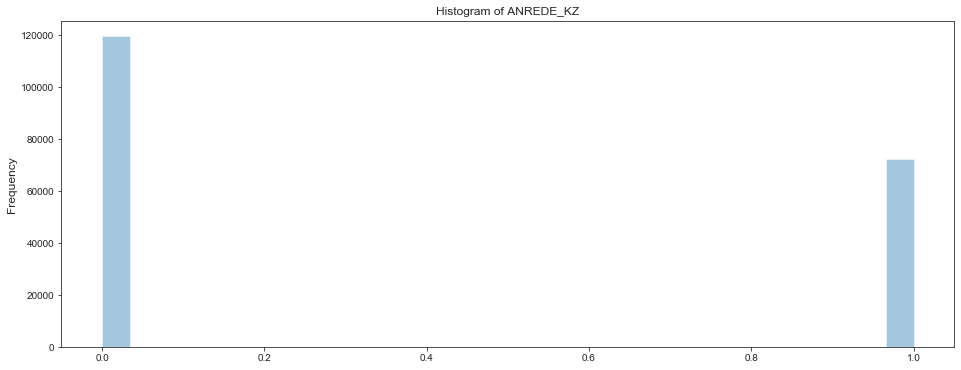

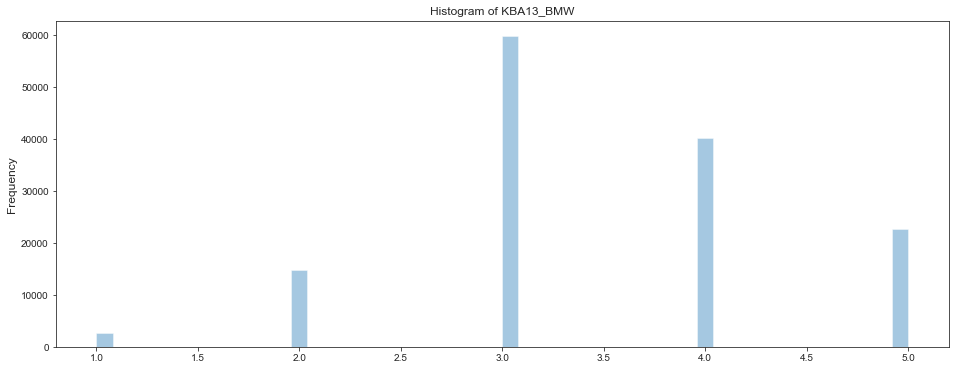

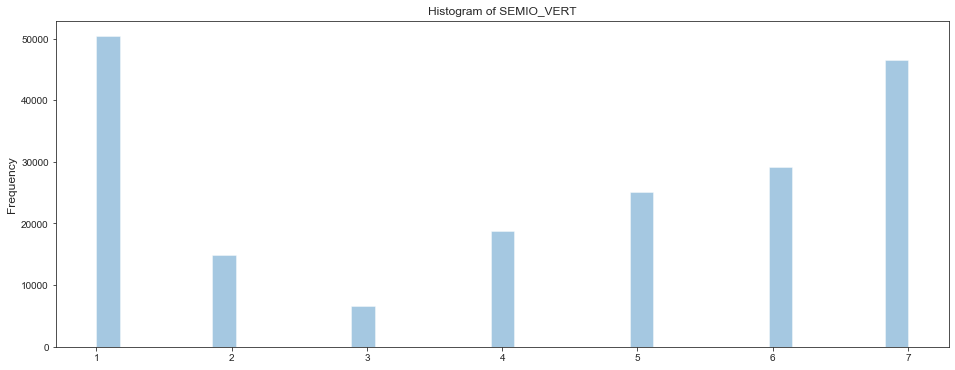

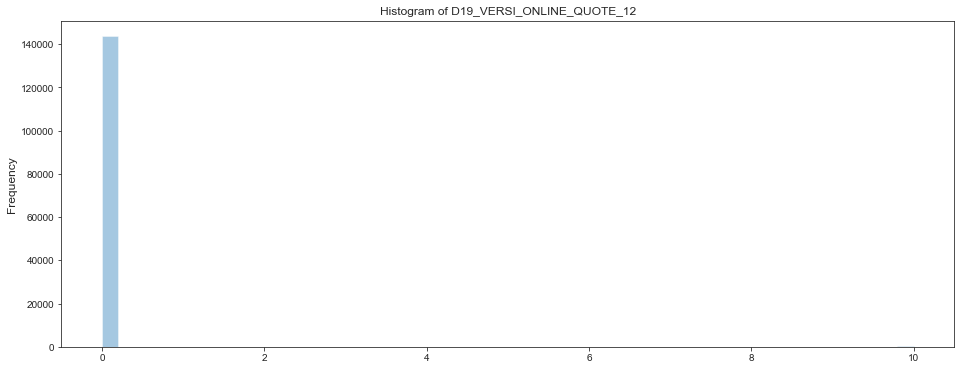

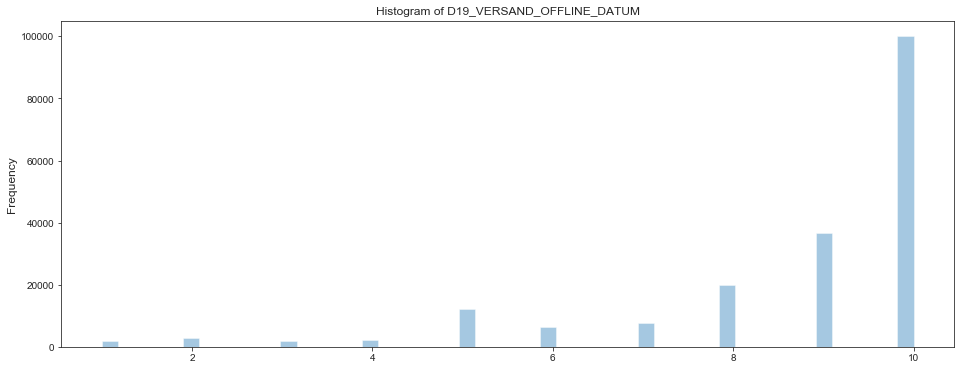

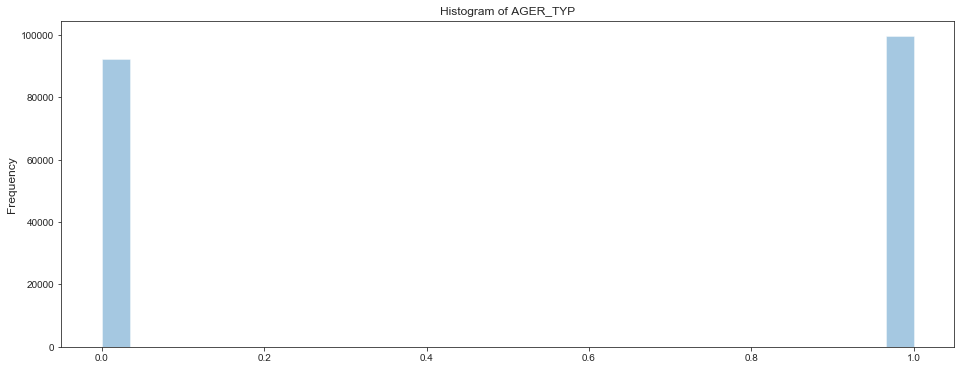

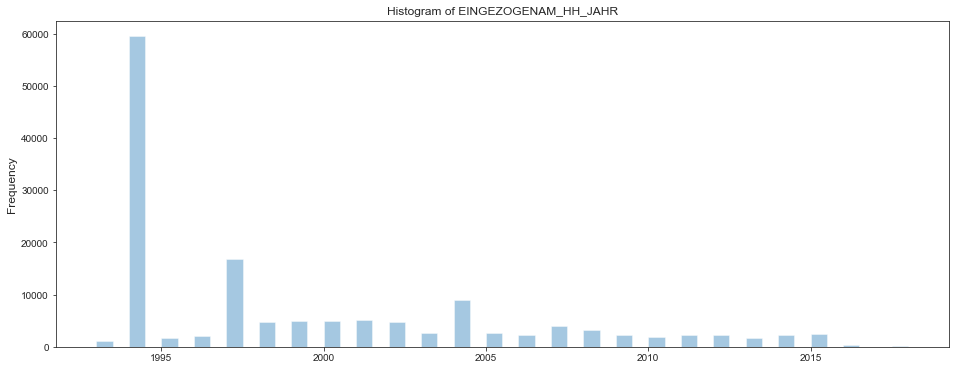

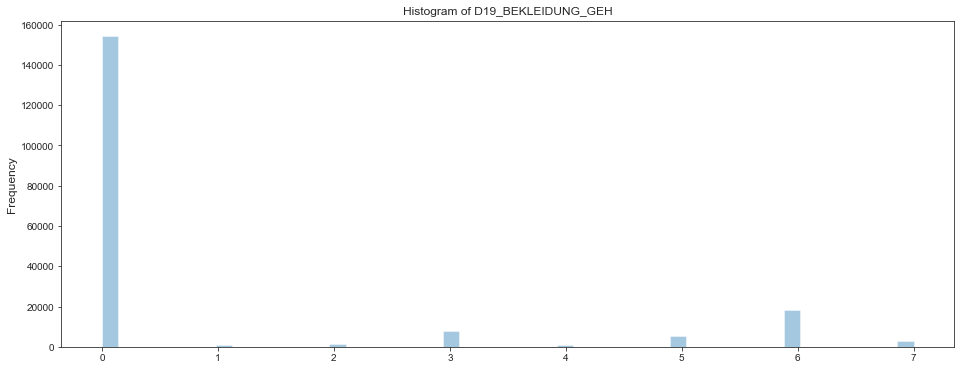

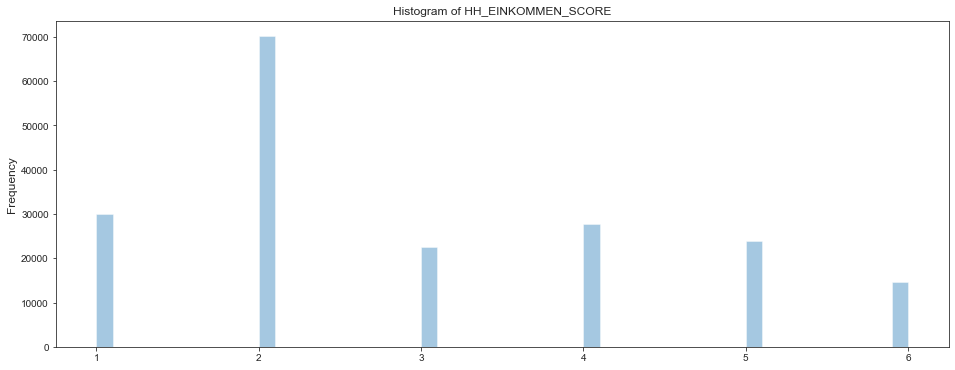

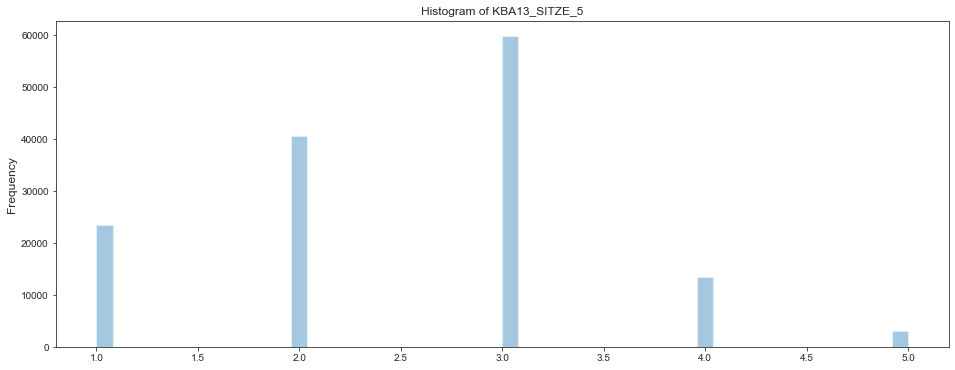

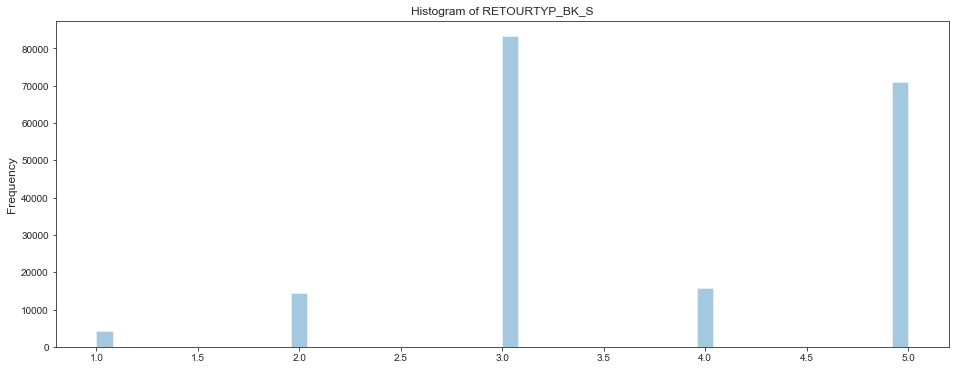

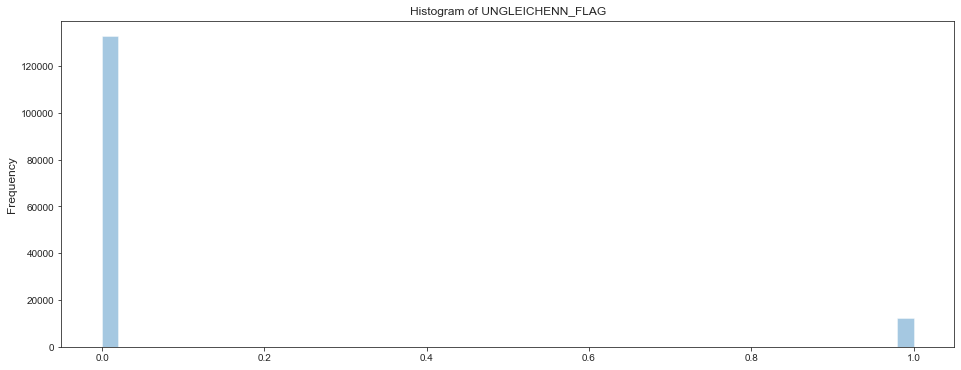

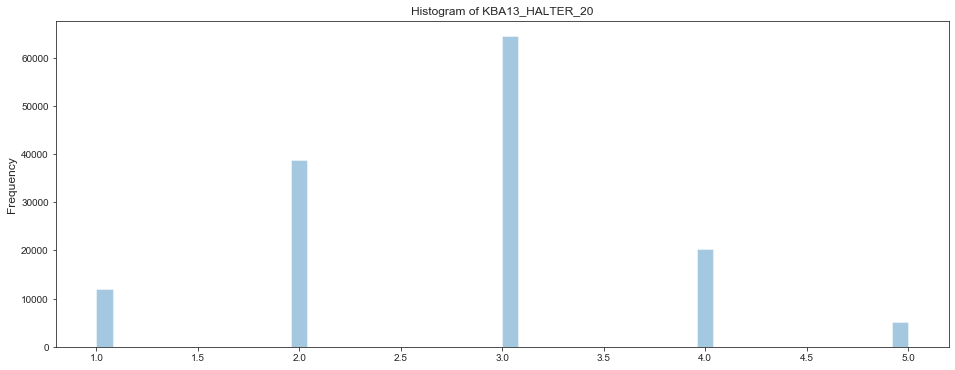

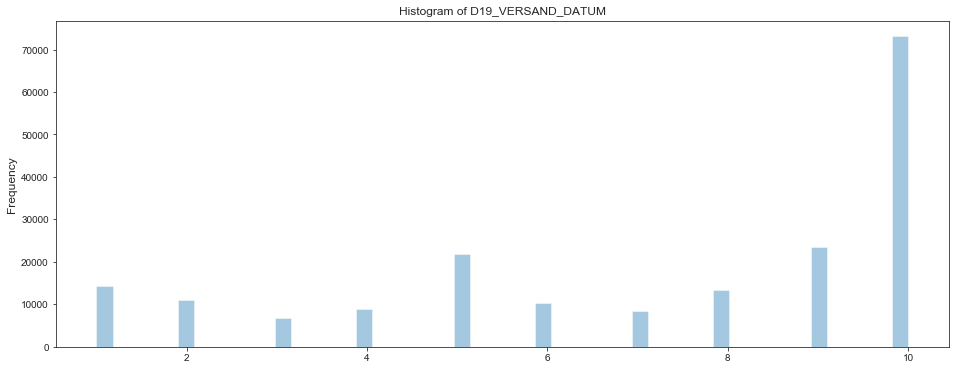

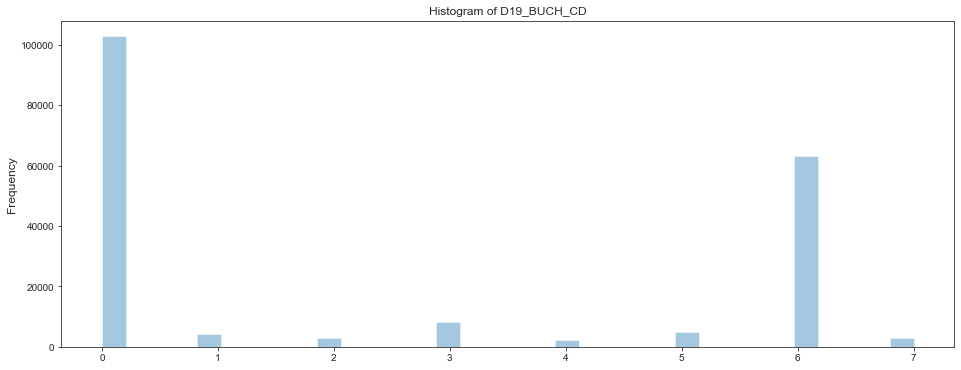

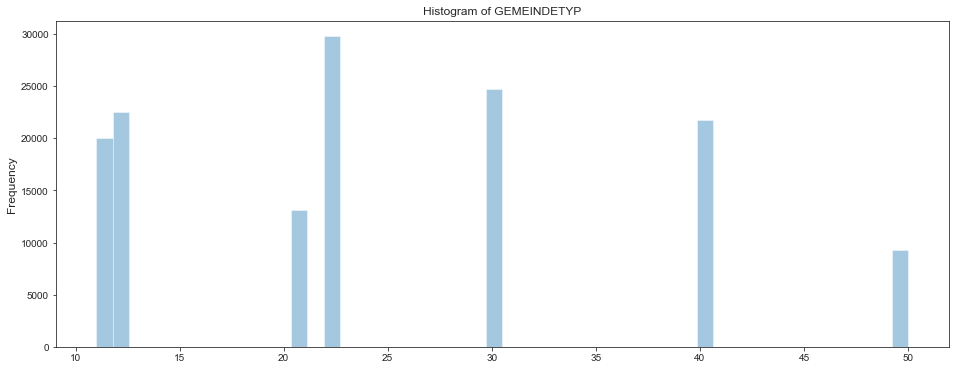

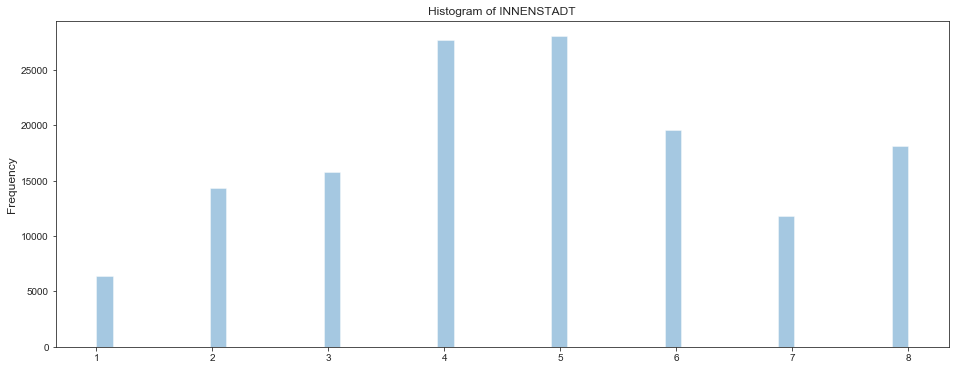

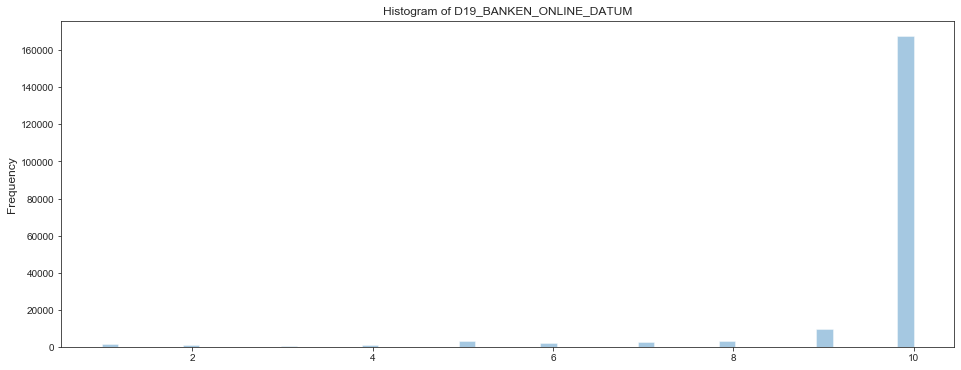

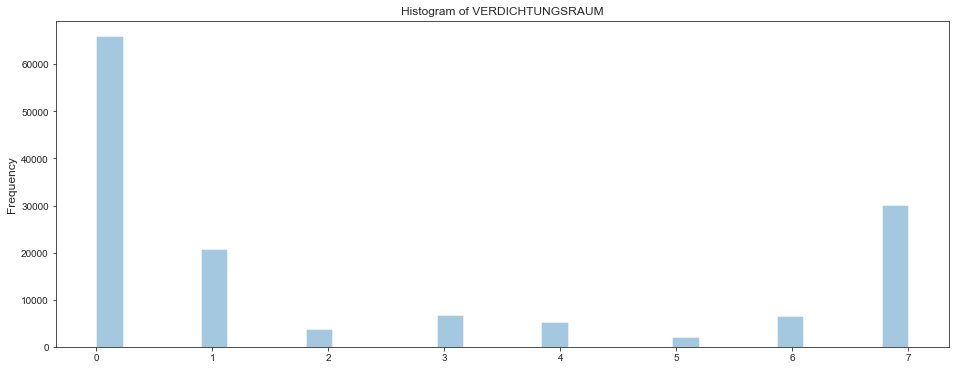

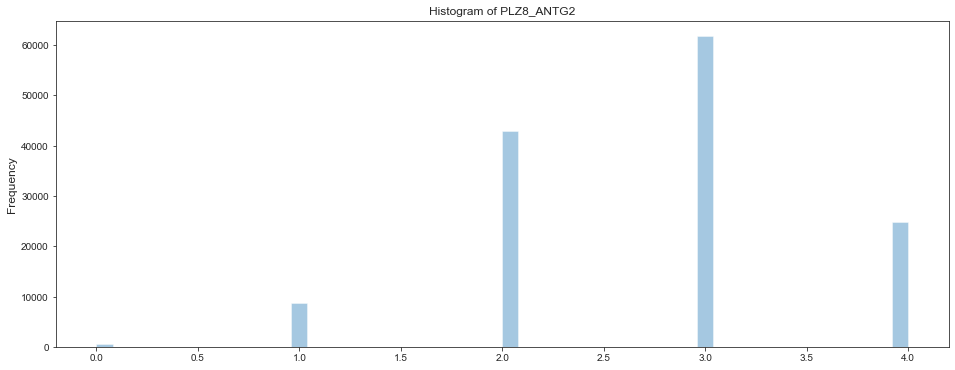

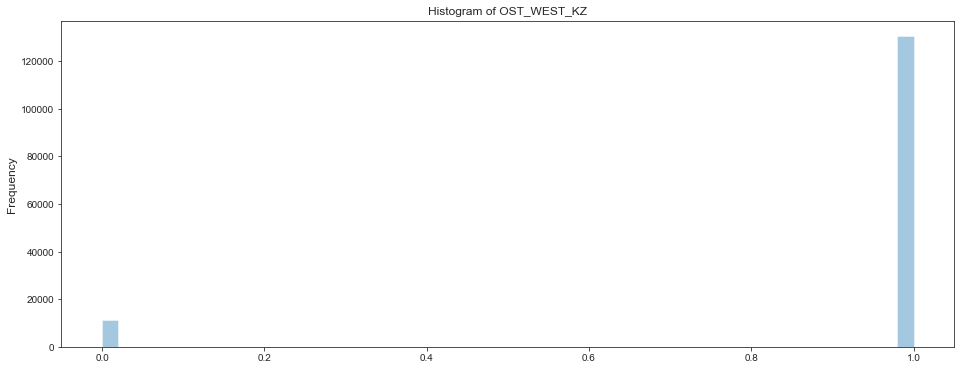

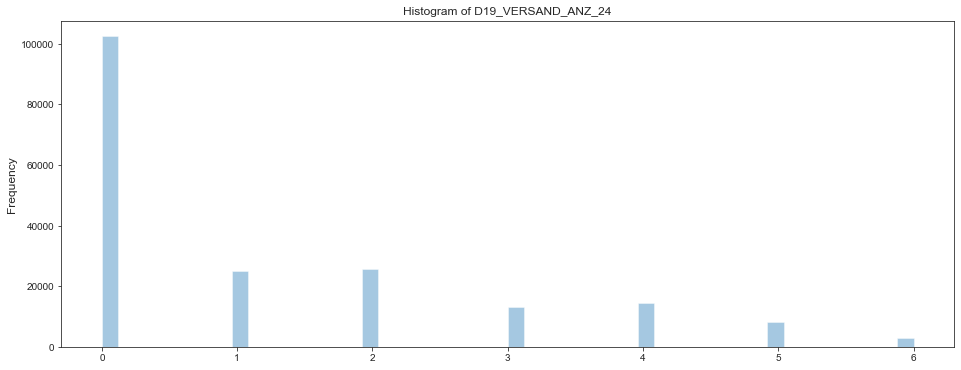

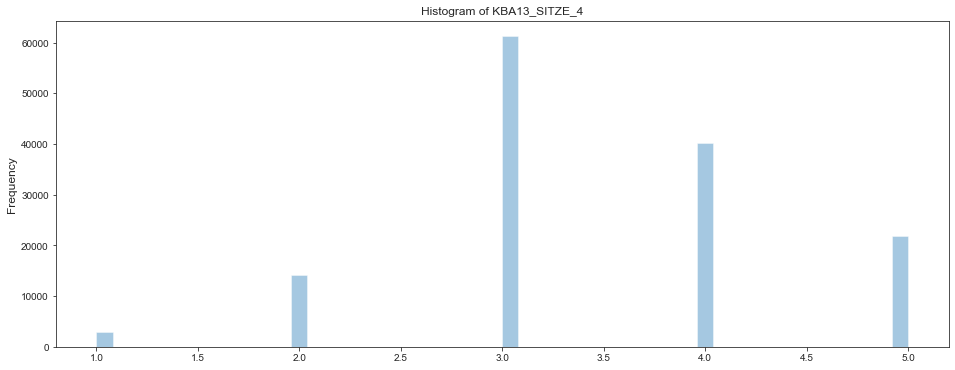

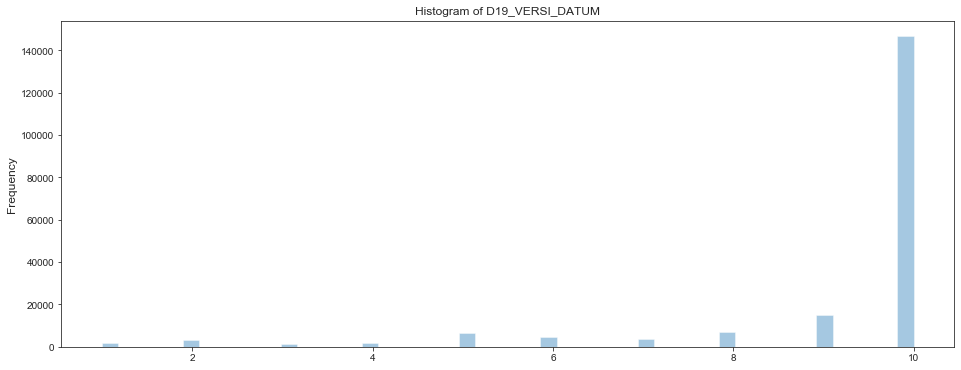

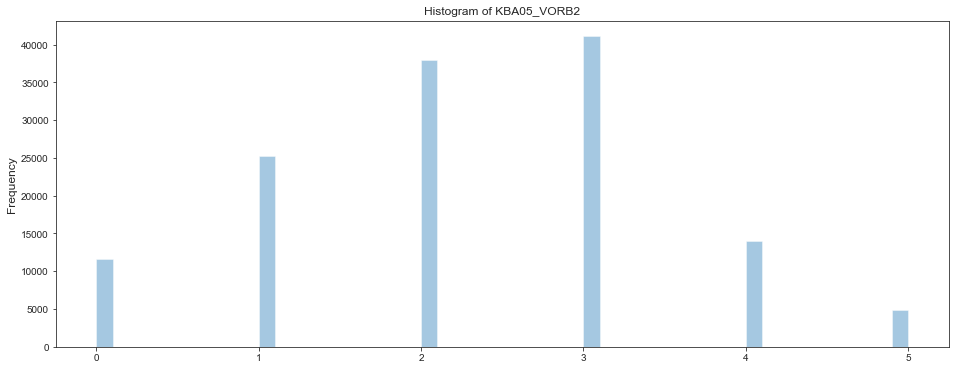

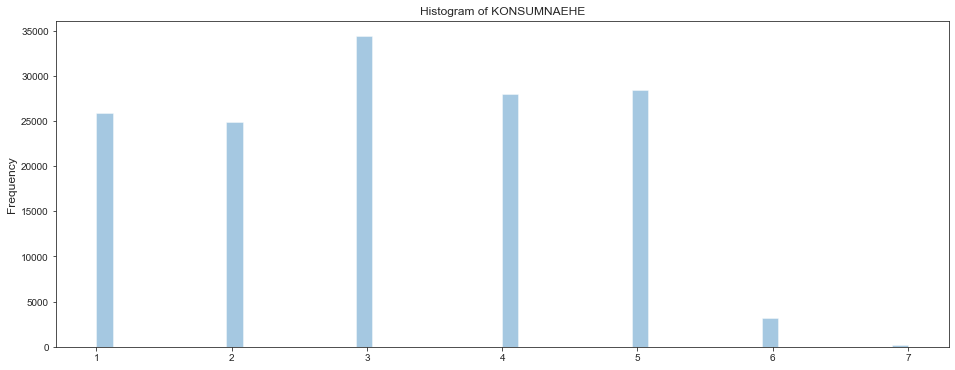

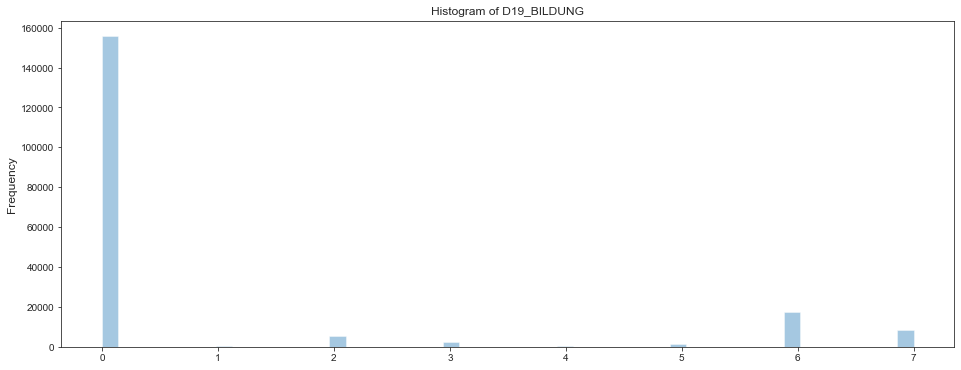

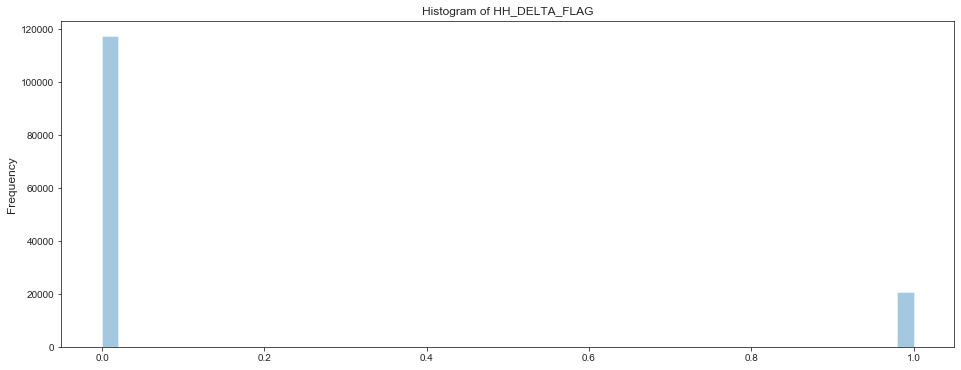

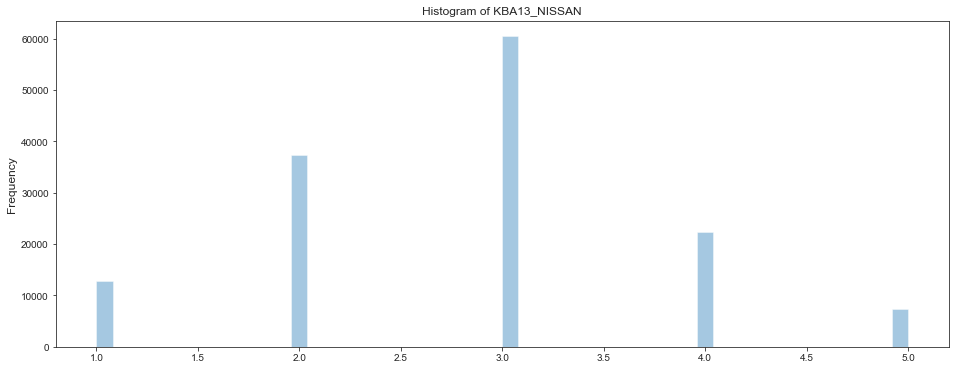

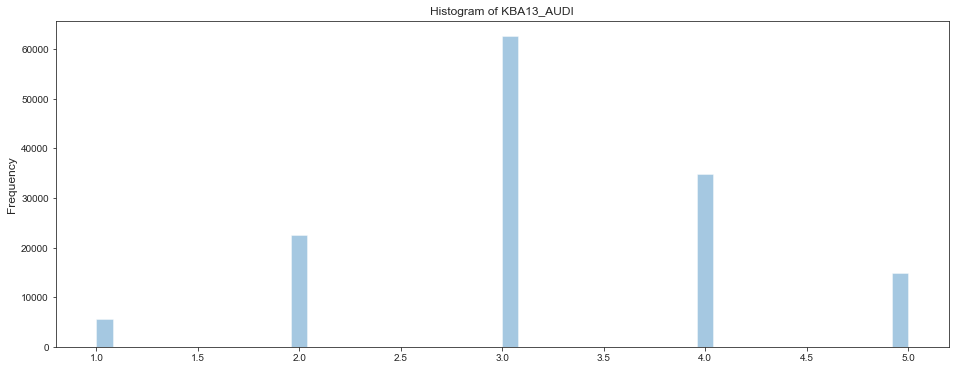

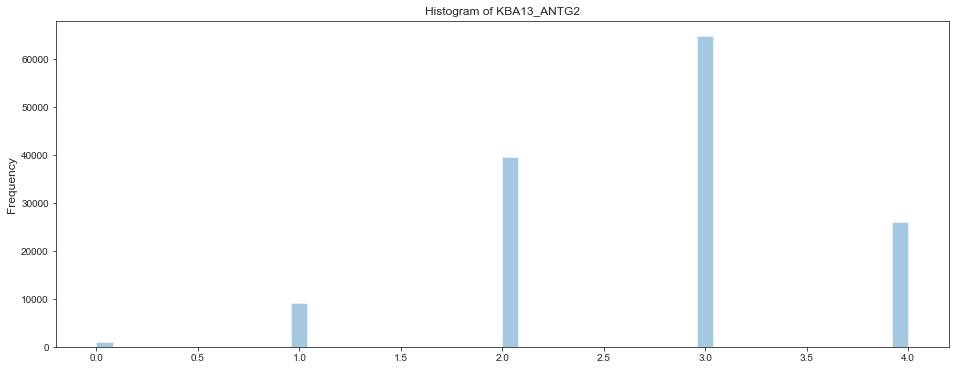

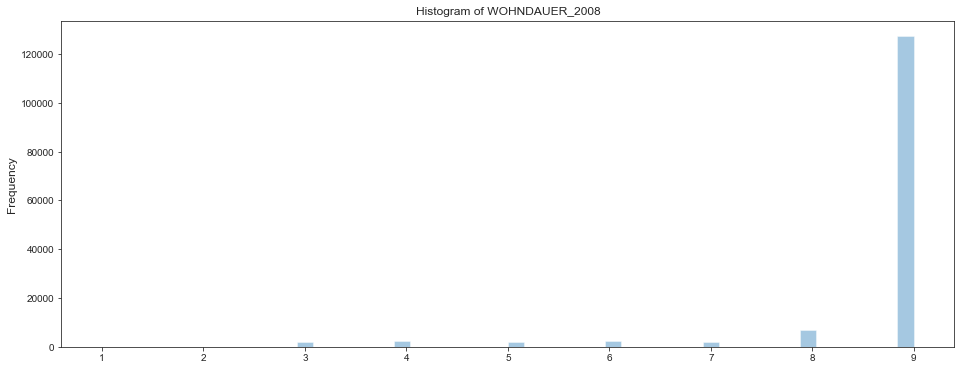

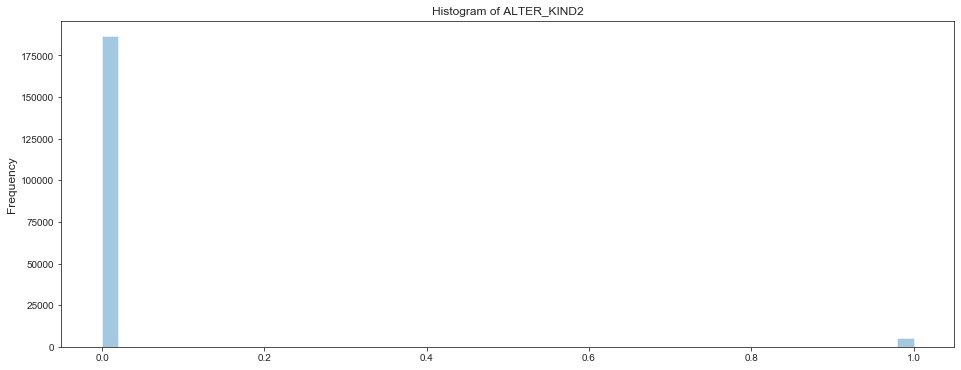

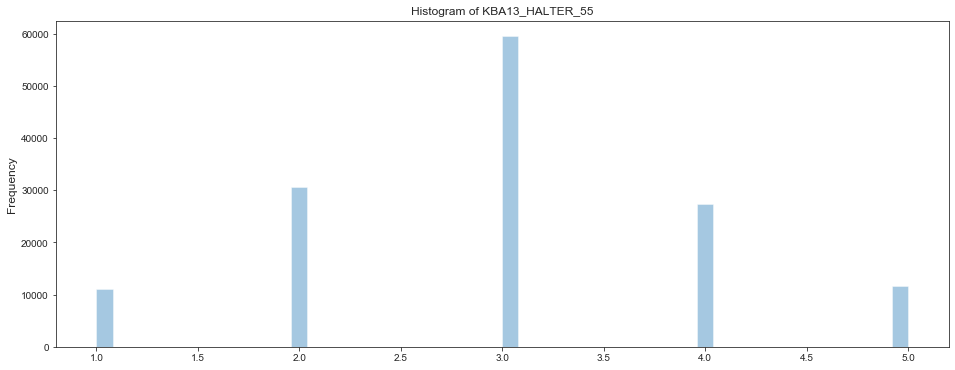

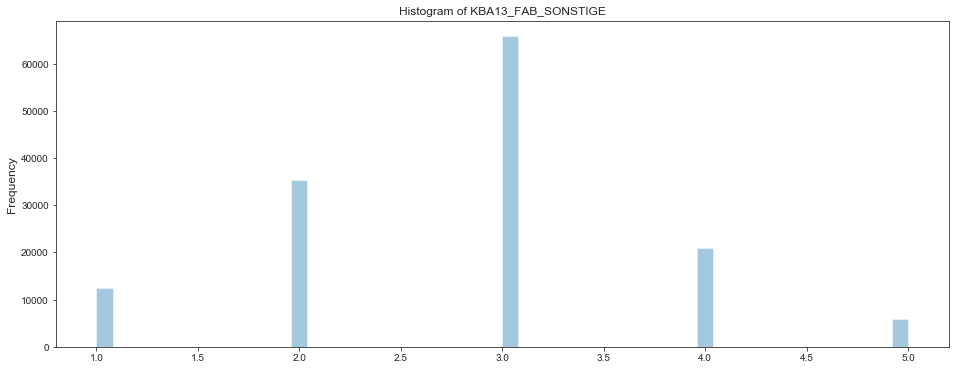

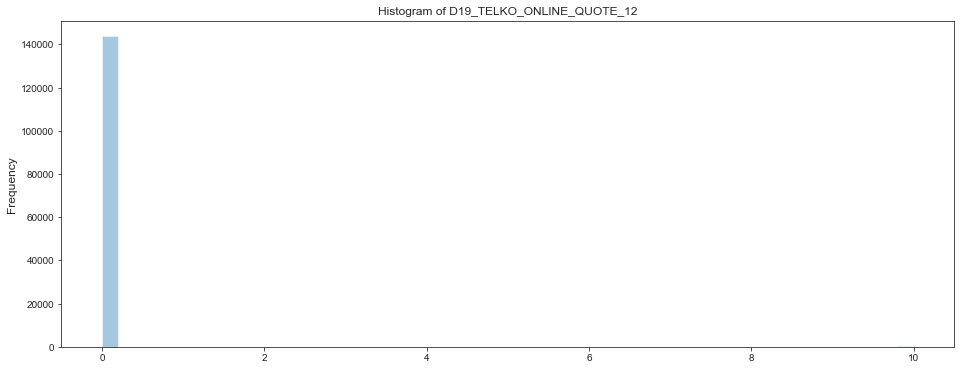

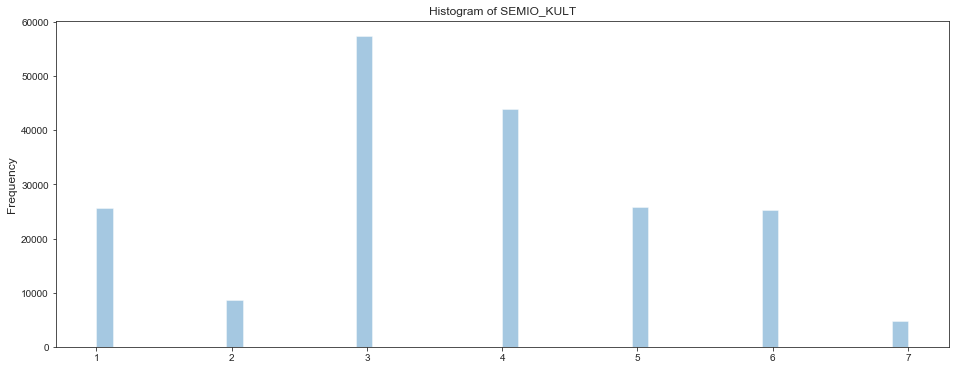

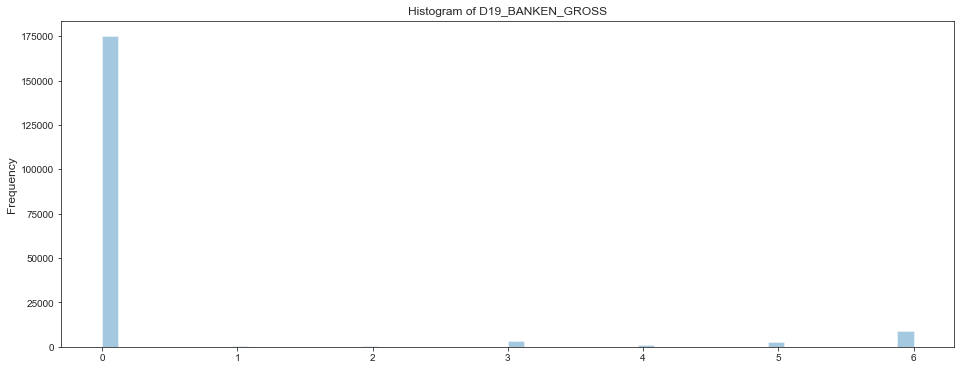

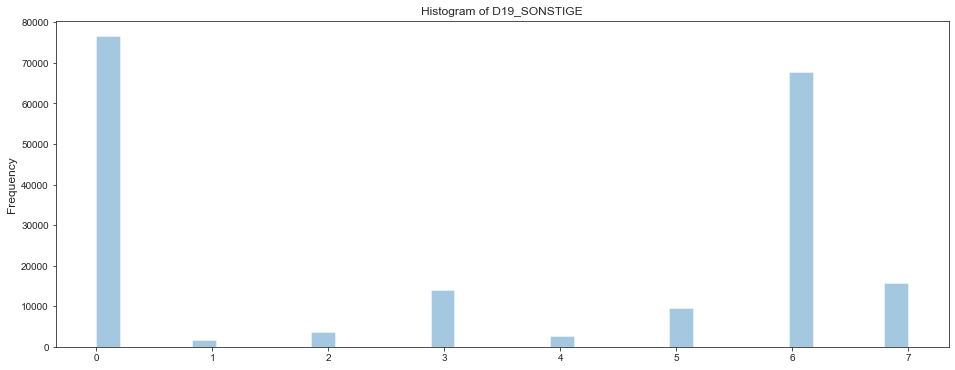

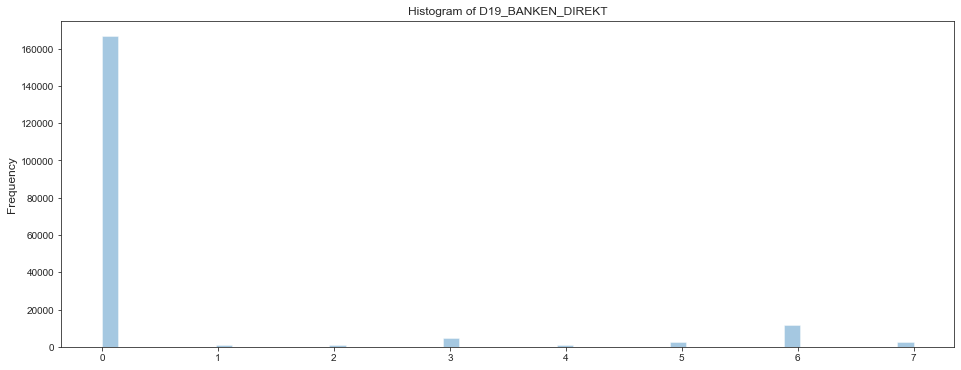

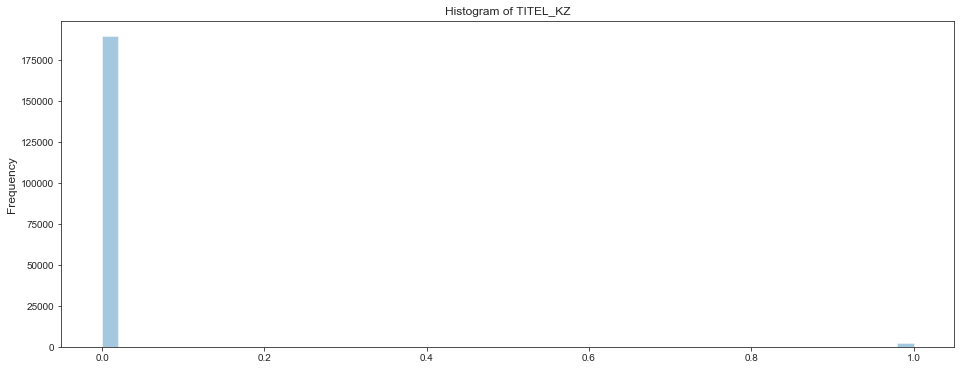

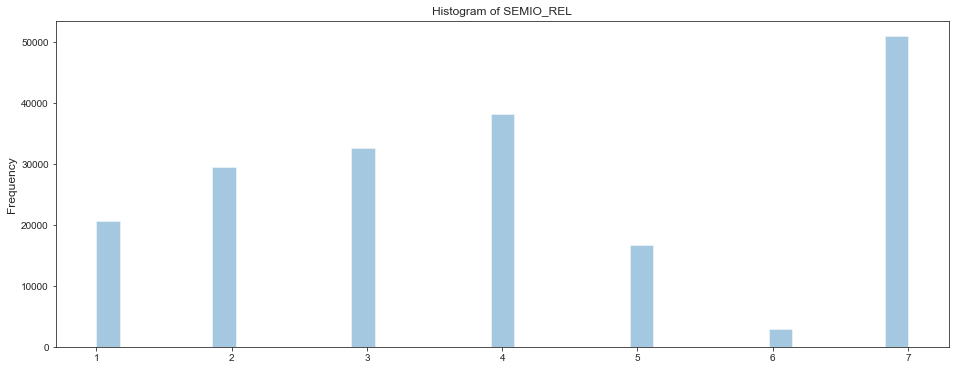

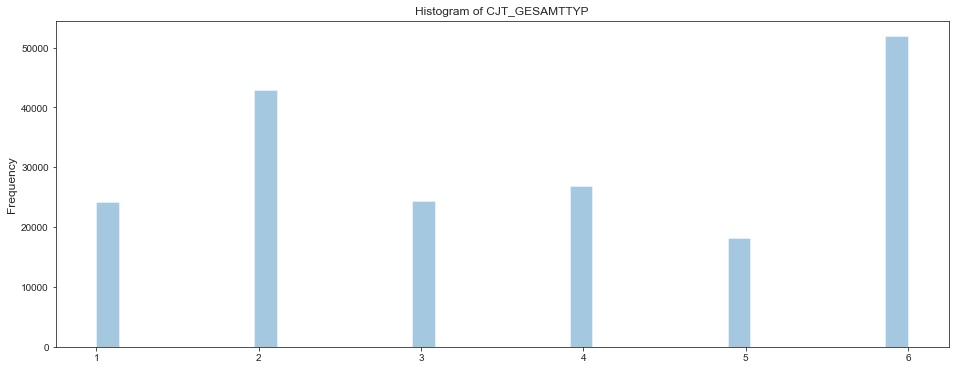

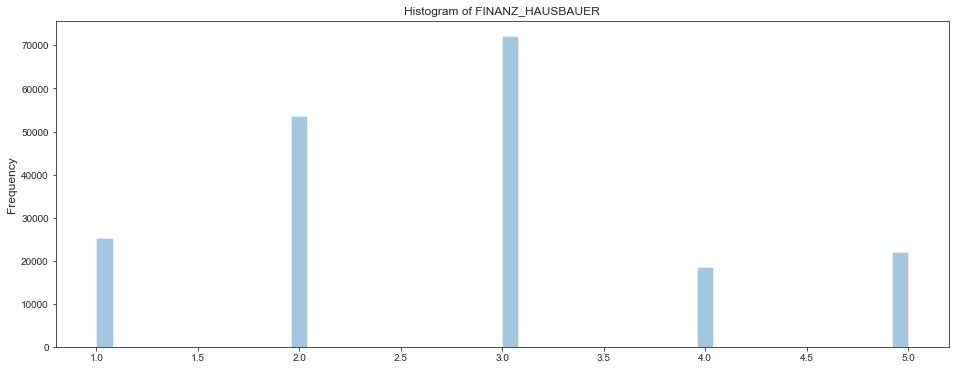

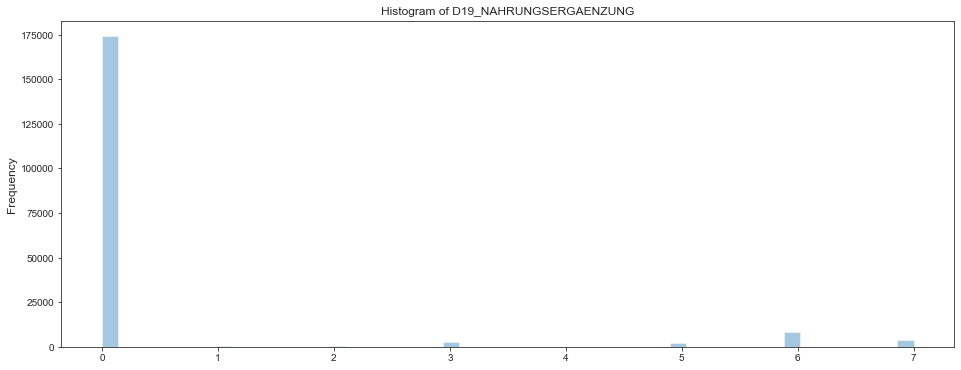

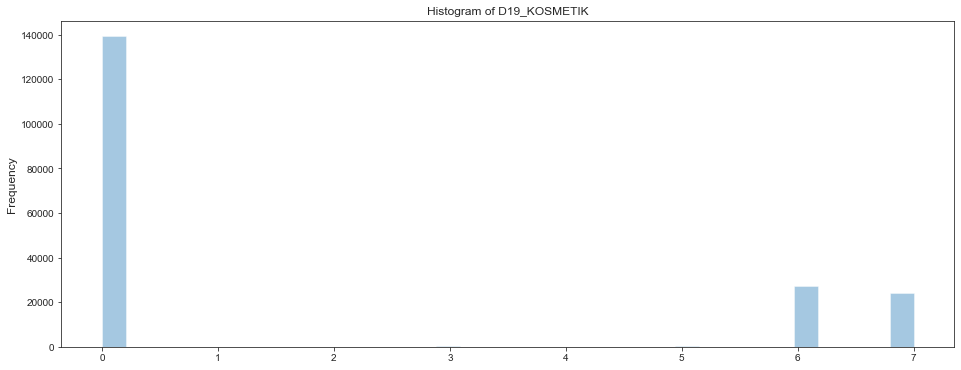

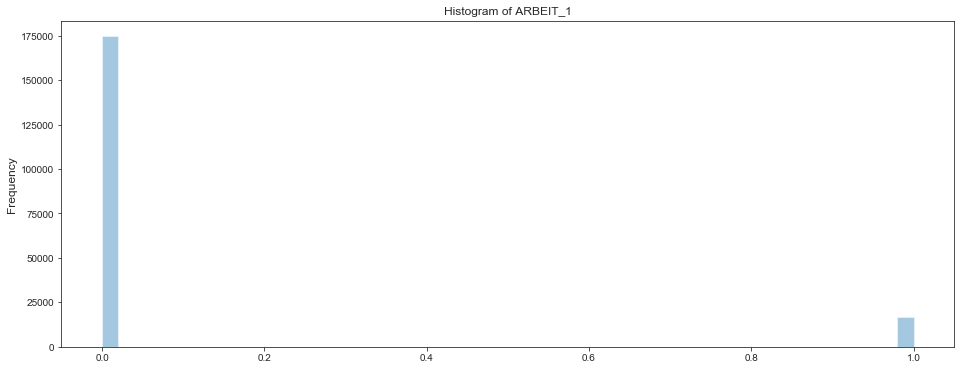

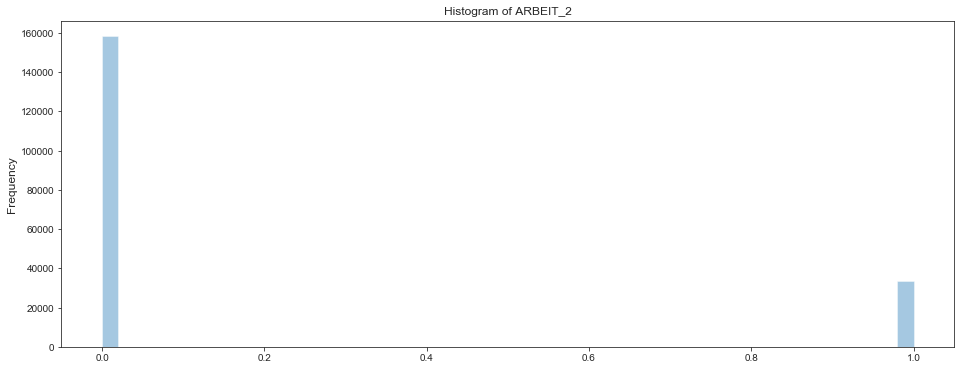

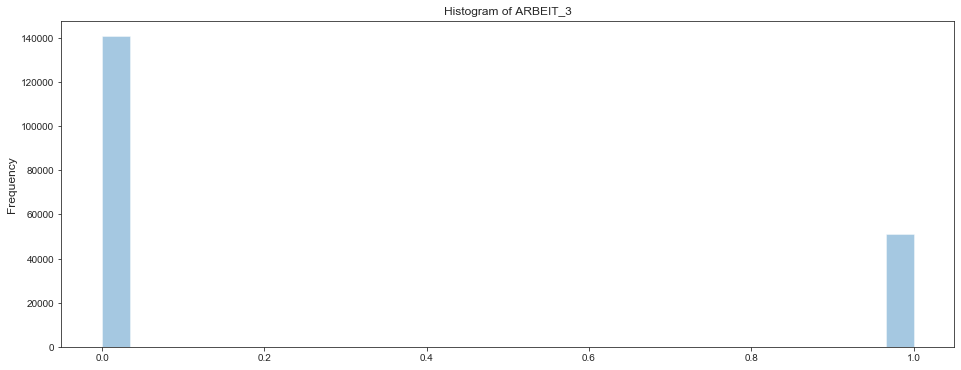

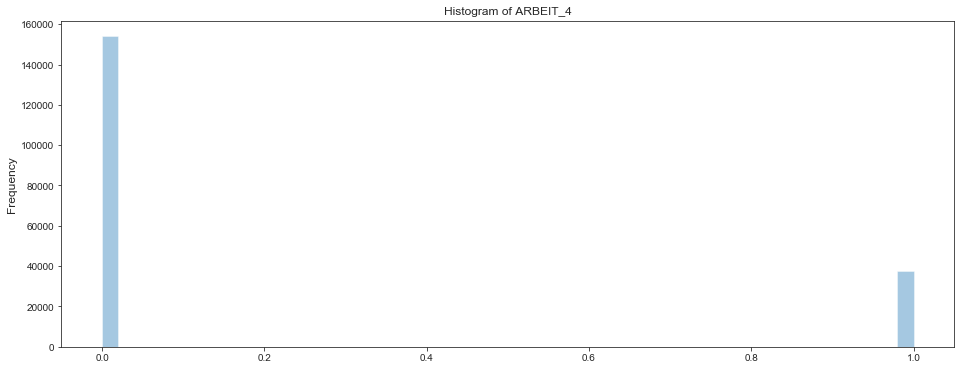

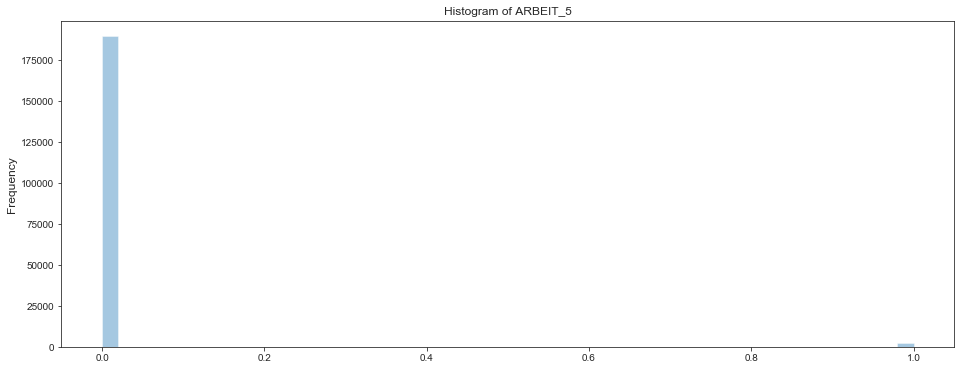

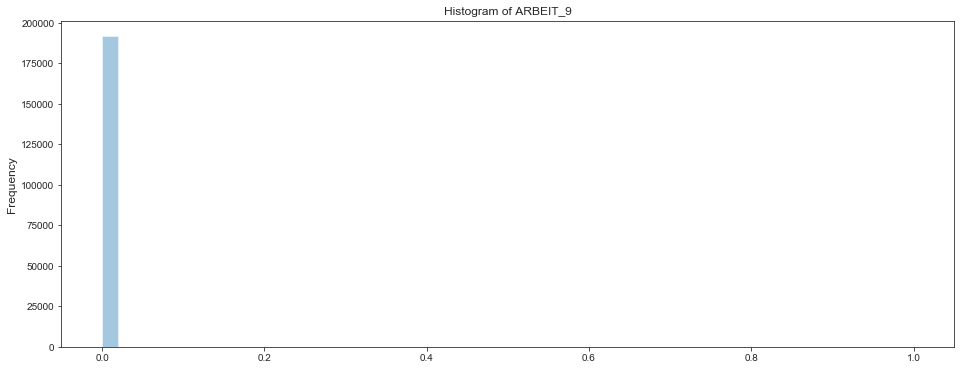

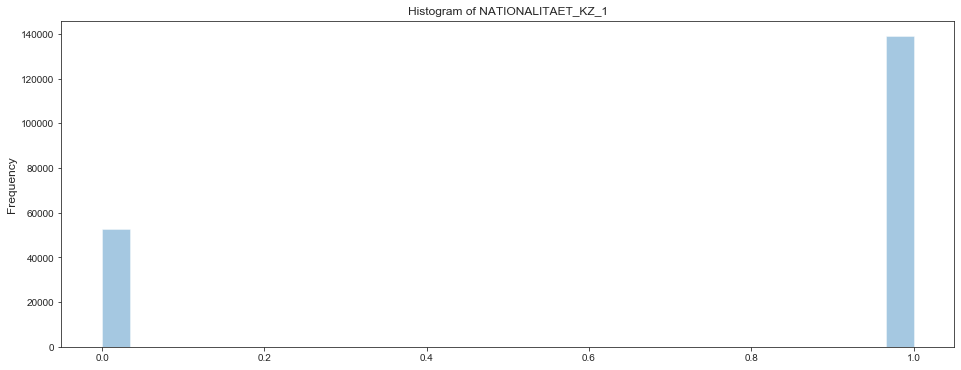

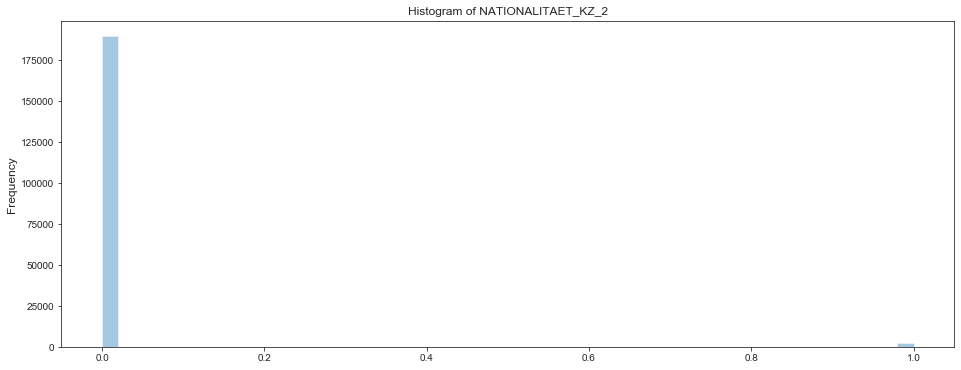

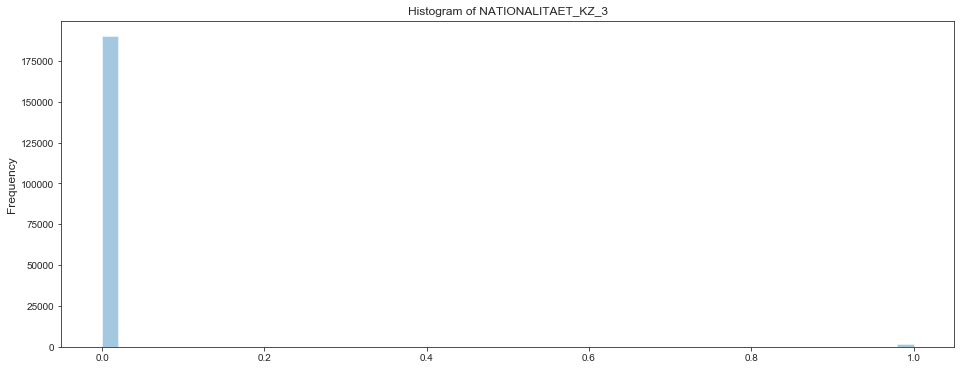

In [27]:
plot_hists(customers_clean,customers_clean.columns)

Most of these features look to have a good variance spread, they don't appear too noisy so i'm confident they'll trasform ok through PCA.

I notice that D19_BANKEN_ONLINE_QUOTE_12 is similar across azdias and customers, this could be different with respect to other features, but with both having such a high proportion at 0, I think this low variance feature is better to be dropped.

The same goes for:

* D19_VERSI_ONLINE_QUOTE_12
* UNGLEICHENN_FLAG
* D19_BANKEN_ONLINE_DATUM
* D19_TELKO_ONLINE_QUOTE_12
* D19_BANKEN_GROSS

In [28]:
cols_to_drop = [
    'D19_BANKEN_ONLINE_QUOTE_12',
    'D19_VERSI_ONLINE_QUOTE_12',
    'UNGLEICHENN_FLAG',
    'D19_BANKEN_ONLINE_DATUM',
    'D19_TELKO_ONLINE_QUOTE_12',
    'D19_BANKEN_GROSS'
]

In [29]:
for col in cols_to_drop:
    assert col in azdias_clean.columns, f'{col} mistype'

In [30]:
cols_keep = [col for col in cols_keep if col not in cols_to_drop]

In [31]:
len(cols_keep)

74

In [32]:
azdias_clean = clean_df.etl_pipeline(azdias,cols_keep=cols_keep,verbosity=v.MED)

Running etl_pipeline...
Running unknown_to_nan...
Finished unknown_to_nan...
Running onehot_encode_df...
Finished running onehot_encode_df...
Running remove_string_values...
Finished running remove_string_values.
Running binarize_nan...
Finishing binarize_nan.
Running standardise_binary_features...
Finished running standardise_binary_features.
Running bin_features_with_tails...
Finished running bin_features_with_tails
Running drop_sparse_samples.
0% of rows dropped: 0 out of 891,221
Finished running drop_sparse_samples.
Finished running etl_pipeline.

df shape before:(891221, 366), after:(891221, 81)


In [33]:
customers_clean = clean_df.etl_pipeline(customers,cols_keep=cols_keep,verbosity=v.MED)

Running etl_pipeline...
Running unknown_to_nan...
Finished unknown_to_nan...
Running onehot_encode_df...
Finished running onehot_encode_df...
Running remove_string_values...
Finished running remove_string_values.
Running binarize_nan...
Finishing binarize_nan.
Running standardise_binary_features...
Finished running standardise_binary_features.
Running bin_features_with_tails...
Finished running bin_features_with_tails
Running drop_sparse_samples.
0% of rows dropped: 0 out of 191,652
Finished running drop_sparse_samples.
Finished running etl_pipeline.

df shape before:(191652, 369), after:(191652, 81)


# Impute misisng values and normalise data

For imputation I would ideally use a knn imputer or iterative imputer or consider manually correlating features to better impute values. Unfortunately the first two methods are two computationally intensive for this dataset and the latter is too labour intensive. 

I'm going to use a simple imputer from the sklearn using a 'most_frequent' strategy

In [35]:
imputer = SimpleImputer(strategy='most_frequent')

In [42]:
pickler.dump(imputer,'SimpleImputer_model_mf')

In [40]:
azdias_clean.describe()

,ANZ_PERSONEN,CJT_TYP_6,D19_SOZIALES,CJT_TYP_4,CJT_TYP_5,CJT_TYP_3,KOMBIALTER,ONLINE_AFFINITAET,LP_FAMILIE_FEIN,ALTERSKATEGORIE_GROB,...,D19_KOSMETIK,ARBEIT_1,ARBEIT_2,ARBEIT_3,ARBEIT_4,ARBEIT_5,ARBEIT_9,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3
count,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000
mean,1.654714,3.474335,0.468105,3.345213,3.369612,3.360270,3.517955,2.694886,3.585416,2.761234,...,1.030101,0.063696,0.152220,0.286111,0.349340,0.039373,0.000178,0.767582,0.073403,0.037480
std,1.067221,1.329635,1.265255,1.374797,1.380514,1.397976,2.110462,1.518246,3.920450,1.010782,...,2.347223,0.244210,0.359235,0.451942,0.476762,0.194481,0.013356,0.422374,0.260796,0.189935
min,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,1.000000,4.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,1.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,2.000000,5.000000,0.000000,5.000000,5.000000,5.000000,4.000000,4.000000,8.000000,4.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000,11.000000,4.000000,...,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
azdias_cols = azdias_clean.columns
azdias_clean = imputer.fit_transform(azdias_clean)

In [38]:
azdias_clean = pd.DataFrame(azdias_clean,columns=azdias_cols)

In [39]:
azdias_clean.describe()

,ANZ_PERSONEN,CJT_TYP_6,D19_SOZIALES,CJT_TYP_4,CJT_TYP_5,CJT_TYP_3,KOMBIALTER,ONLINE_AFFINITAET,LP_FAMILIE_FEIN,ALTERSKATEGORIE_GROB,...,D19_KOSMETIK,ARBEIT_1,ARBEIT_2,ARBEIT_3,ARBEIT_4,ARBEIT_5,ARBEIT_9,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3
count,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000
mean,1.654714,3.474335,0.468105,3.345213,3.369612,3.360270,3.517955,2.694886,3.585416,2.761234,...,1.030101,0.063696,0.152220,0.286111,0.349340,0.039373,0.000178,0.767582,0.073403,0.037480
std,1.067221,1.329635,1.265255,1.374797,1.380514,1.397976,2.110462,1.518246,3.920450,1.010782,...,2.347223,0.244210,0.359235,0.451942,0.476762,0.194481,0.013356,0.422374,0.260796,0.189935
min,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,1.000000,4.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,1.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,2.000000,5.000000,0.000000,5.000000,5.000000,5.000000,4.000000,4.000000,8.000000,4.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000,11.000000,4.000000,...,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [41]:
customers_clean.describe()

,ANZ_PERSONEN,CJT_TYP_6,D19_SOZIALES,CJT_TYP_4,CJT_TYP_5,CJT_TYP_3,KOMBIALTER,ONLINE_AFFINITAET,LP_FAMILIE_FEIN,ALTERSKATEGORIE_GROB,...,D19_KOSMETIK,ARBEIT_1,ARBEIT_2,ARBEIT_3,ARBEIT_4,ARBEIT_5,ARBEIT_9,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3
count,145056.000000,188439.000000,143955.000000,188439.000000,188439.000000,188439.000000,191652.00000,188439.000000,188439.000000,191652.000000,...,191652.000000,191652.000000,191652.00000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,2.233144,4.538838,1.243590,4.415317,4.519956,4.516369,4.99784,2.764327,4.254448,3.054646,...,1.756110,0.088395,0.17393,0.265612,0.196163,0.012408,0.000120,0.725414,0.012637,0.007581
std,1.291864,0.886091,1.158867,1.025281,0.895371,0.874722,2.34032,1.266050,4.492807,1.066227,...,2.883393,0.283869,0.37905,0.441659,0.397094,0.110698,0.010954,0.446307,0.111704,0.086741
min,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.00000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,4.000000,1.000000,4.000000,4.000000,4.000000,4.00000,2.000000,0.000000,3.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,5.000000,1.000000,5.000000,5.000000,5.000000,4.00000,2.000000,2.000000,3.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,3.000000,5.000000,1.000000,5.000000,5.000000,5.000000,4.00000,4.000000,10.000000,4.000000,...,6.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,9.00000,5.000000,11.000000,4.000000,...,7.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [48]:
customers_clean_fail = customers_clean.drop('ANZ_PERSONEN',axis=1)

In [49]:
print(customers_clean_fail.shape)
print(customers_clean.shape)

(191652, 80)
(191652, 81)


In [50]:
# This cell generates a ValueError, it was used to determine the exception that is raised when the wrong shape X
#is passed to the SimpleImputer. Used for developing the function in the next cell. Commented out, 
#to let the notebook run without stopping at this failing cell
#_ = imputer.transform(customers_clean_fail)

ValueError: X has 80 features per sample, expected 81

In [70]:
def impute(df,*,persist=False,vp=None):
    
    imputer_name = 'SimpleImputer_model_mf'
    
    if vp == None:
        vp = v.VerbosityPrinter(v.NONE)
        
    vp.low('Running impute...')
    
    cols = df.columns
    if pickler.isfile(imputer_name):
        imputer = pickler.load(imputer_name)
        try:
            X = imputer.transform(df)
        except ValueError as err:
            vp.none(f'Warning: {err}')
            vp.none('Fitting new imputer.')
            imputer = SimpleImputer(strategy='most_frequent')
            X = imputer.fit_transform(df)
            
            if persist:
                pickler.dump(imputer,imputer_name)
    else:
        vp.none(f'{imputer_name}, not found. Fitting new transformer')
        imputer = SimpleImputer(strategy='most_frequent')
        X = imputer.fit_transform(df)
        if persist:
            pickler.dump(imputer,imputer_name)
        
    df = pd.DataFrame(X,columns=cols)
    
    vp.low('Finishing running impute.')

    return(df)

In [56]:
customers_clean = impute(customers_clean)

In [57]:
customers_clean.describe()

,ANZ_PERSONEN,CJT_TYP_6,D19_SOZIALES,CJT_TYP_4,CJT_TYP_5,CJT_TYP_3,KOMBIALTER,ONLINE_AFFINITAET,LP_FAMILIE_FEIN,ALTERSKATEGORIE_GROB,...,D19_KOSMETIK,ARBEIT_1,ARBEIT_2,ARBEIT_3,ARBEIT_4,ARBEIT_5,ARBEIT_9,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3
count,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.00000,191652.000000,191652.000000,191652.000000,...,191652.000000,191652.000000,191652.00000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,1.933332,4.546569,0.934094,4.425119,4.528004,4.524477,4.99784,2.751513,4.199888,3.054646,...,1.756110,0.088395,0.17393,0.265612,0.196163,0.012408,0.000120,0.725414,0.012637,0.007581
std,1.242166,0.880625,1.139228,1.019418,0.889971,0.869579,2.34032,1.259222,4.474538,1.066227,...,2.883393,0.283869,0.37905,0.441659,0.397094,0.110698,0.010954,0.446307,0.111704,0.086741
min,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.00000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,4.000000,0.000000,4.000000,4.000000,4.000000,4.00000,2.000000,1.000000,3.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,5.000000,1.000000,5.000000,5.000000,5.000000,4.00000,2.000000,2.000000,3.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,3.000000,5.000000,1.000000,5.000000,5.000000,5.000000,4.00000,4.000000,10.000000,4.000000,...,6.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,9.00000,5.000000,11.000000,4.000000,...,7.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Normalise

In [67]:
cols = azdias_clean.columns
scaler = StandardScaler()
X = scaler.fit_transform(azdias_clean)
azdias_clean = pd.DataFrame(X,columns=cols)

In [68]:
azdias_clean.describe()

,ANZ_PERSONEN,CJT_TYP_6,D19_SOZIALES,CJT_TYP_4,CJT_TYP_5,CJT_TYP_3,KOMBIALTER,ONLINE_AFFINITAET,LP_FAMILIE_FEIN,ALTERSKATEGORIE_GROB,...,D19_KOSMETIK,ARBEIT_1,ARBEIT_2,ARBEIT_3,ARBEIT_4,ARBEIT_5,ARBEIT_9,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3
count,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,...,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05
mean,-8.681154e-15,1.607341e-15,-1.658389e-15,-4.538802e-15,3.230243e-15,-2.301833e-15,6.014036e-15,-5.587909e-15,1.711755e-16,6.866321e-15,...,2.093908e-15,1.701918e-14,-1.522537e-14,-1.388162e-14,2.522769e-14,3.287340e-14,-1.265532e-14,-7.900033e-15,-1.637073e-14,-7.912049e-15
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.550490e+00,-1.860914e+00,-3.699692e-01,-1.705862e+00,-1.716472e+00,-1.688349e+00,-1.193083e+00,-1.775001e+00,-9.145424e-01,-1.742449e+00,...,-4.388599e-01,-2.608235e-01,-4.237356e-01,-6.330701e-01,-7.327350e-01,-2.024518e-01,-1.335810e-02,-1.817303e+00,-2.814559e-01,-1.973309e-01
25%,-6.134760e-01,-1.108827e+00,-3.699692e-01,-9.784813e-01,-9.921036e-01,-9.730284e-01,-7.192525e-01,-4.576904e-01,-6.594695e-01,-7.531149e-01,...,-4.388599e-01,-2.608235e-01,-4.237356e-01,-6.330701e-01,-7.327350e-01,-2.024518e-01,-1.335810e-02,5.502661e-01,-2.814559e-01,-1.973309e-01
50%,-6.134760e-01,3.953458e-01,-3.699692e-01,-2.511011e-01,-2.677353e-01,-2.577082e-01,-2.454225e-01,2.009650e-01,-6.594695e-01,2.362190e-01,...,-4.388599e-01,-2.608235e-01,-4.237356e-01,-6.330701e-01,-7.327350e-01,-2.024518e-01,-1.335810e-02,5.502661e-01,-2.814559e-01,-1.973309e-01
75%,3.235375e-01,1.147432e+00,-3.699692e-01,1.203659e+00,1.181001e+00,1.172932e+00,2.284076e-01,8.596203e-01,1.126041e+00,1.225553e+00,...,-4.388599e-01,-2.608235e-01,-4.237356e-01,1.579604e+00,1.364750e+00,-2.024518e-01,-1.335810e-02,5.502661e-01,-2.814559e-01,-1.973309e-01
max,3.134578e+00,1.147432e+00,3.581807e+00,1.203659e+00,1.181001e+00,1.172932e+00,2.597558e+00,1.518276e+00,1.891259e+00,1.225553e+00,...,2.543390e+00,3.834010e+00,2.359962e+00,1.579604e+00,1.364750e+00,4.939448e+00,7.486096e+01,5.502661e-01,3.552954e+00,5.067629e+00


In [69]:
pickler.dump(scaler,'standardscaler_model')

In [142]:
def scale(df,*,persist=False,vp=None):
    
    scaler_name = 'standardscaler_model'
    
    if vp == None:
        vp = v.VerbosityPrinter(v.NONE)
        
    vp.low('Running impute...')
    
    cols = df.columns
    if pickler.isfile(scaler_name):
        scaler = pickler.load(scaler_name)
        try:
            X = scaler.transform(df)
        except ValueError as err:
            vp.none(f'Warning:{err}')
            vp.none('Fitting new scaler.')            
            scaler = StandardScaler()
            X = scaler.fit_transform(df)
    else:
        vp.none(f'{scaler_name}, not found. Fitting new scaler')

        scaler = StandardScaler()
        X = scaler.fit_transform(df)
        
    df = pd.DataFrame(X,columns=cols)
    
    vp.low('Finishing running impute.')

    return(df)

In [72]:
customers_clean = scale(customers_clean)

In [73]:
customers_clean.describe()

,ANZ_PERSONEN,CJT_TYP_6,D19_SOZIALES,CJT_TYP_4,CJT_TYP_5,CJT_TYP_3,KOMBIALTER,ONLINE_AFFINITAET,LP_FAMILIE_FEIN,ALTERSKATEGORIE_GROB,...,D19_KOSMETIK,ARBEIT_1,ARBEIT_2,ARBEIT_3,ARBEIT_4,ARBEIT_5,ARBEIT_9,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3
count,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,...,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,0.261069,0.806413,0.368297,0.785503,0.839102,0.832781,0.701214,0.037298,0.156735,0.290282,...,0.309306,0.101138,0.060433,-0.045358,-0.321286,-0.138652,-0.004372,-0.099836,-0.232999,-0.157415
std,1.163927,0.662306,0.900395,0.741505,0.644666,0.622027,1.108914,0.829393,1.141333,1.054855,...,1.228428,1.162395,1.055161,0.977249,0.832899,0.569197,0.820191,1.056662,0.428320,0.456688
min,-1.550490,-1.860914,-0.369969,-1.705862,-1.716472,-1.688349,-1.193083,-1.775001,-0.914542,-1.742449,...,-0.438860,-0.260824,-0.423736,-0.633070,-0.732735,-0.202452,-0.013358,-1.817303,-0.281456,-0.197331
25%,-0.613476,0.395346,-0.369969,0.476279,0.456633,0.457612,0.228408,-0.457690,-0.659470,0.236219,...,-0.438860,-0.260824,-0.423736,-0.633070,-0.732735,-0.202452,-0.013358,-1.817303,-0.281456,-0.197331
50%,0.323538,1.147432,0.420386,1.203659,1.181001,1.172932,0.228408,-0.457690,-0.404397,0.236219,...,-0.438860,-0.260824,-0.423736,-0.633070,-0.732735,-0.202452,-0.013358,0.550266,-0.281456,-0.197331
75%,1.260551,1.147432,0.420386,1.203659,1.181001,1.172932,0.228408,0.859620,1.636186,1.225553,...,2.117354,-0.260824,-0.423736,1.579604,-0.732735,-0.202452,-0.013358,0.550266,-0.281456,-0.197331
max,3.134578,1.147432,3.581807,1.203659,1.181001,1.172932,2.597558,1.518276,1.891259,1.225553,...,2.543390,3.834010,2.359962,1.579604,1.364750,4.939448,74.860961,0.550266,3.552954,5.067629


In [112]:
def pca_eval(df):
    
    pca = PCA()
    
    pca.fit(df)
    
    for i in np.linspace(0.3,0.9,7):
        print(f'Number of dimensions:{np.searchsorted(np.cumsum(pca.explained_variance_ratio_),i)}\
         that explain variance of {int(i*100)}%')
    
    figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');

    figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

    plt.plot(pca.explained_variance_ratio_)
    plt.xticks(list(range(0,(len(df.columns)),20)))
    plt.xlabel('number of components')
    plt.ylabel('explained variance');

In [113]:
np.linspace(0.3,0.9,7)

array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

Number of dimensions:2         that explain variance of 30%
Number of dimensions:4         that explain variance of 40%
Number of dimensions:7         that explain variance of 50%
Number of dimensions:13         that explain variance of 60%
Number of dimensions:21         that explain variance of 70%
Number of dimensions:30         that explain variance of 80%
Number of dimensions:43         that explain variance of 90%


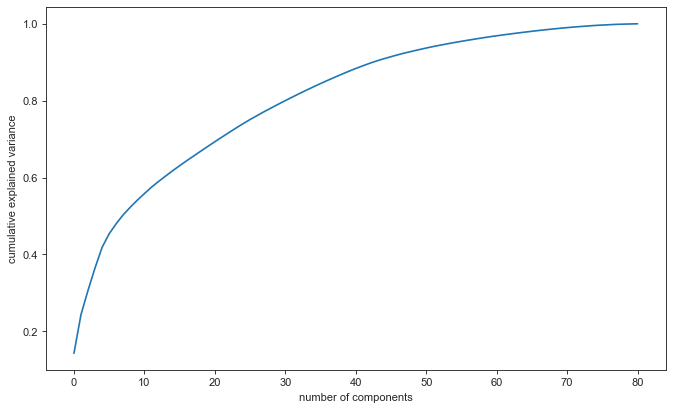

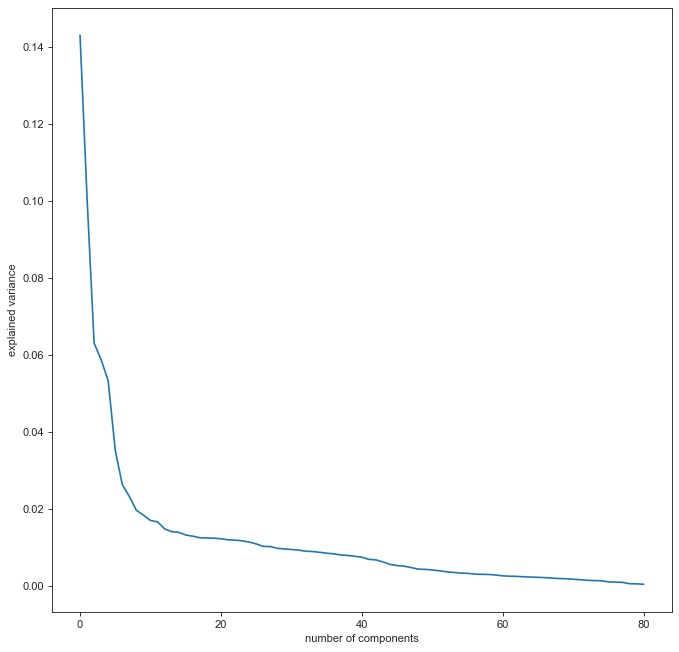

In [114]:
pca_eval(azdias_clean)

This is a good start but I think I need to reduce my dimensionality further prior to PCA. Ideally I would have above 70% variance explained but 21 dimensions is too high for Kmeans clustering. My aim would be to reduce the number of dimensions down to around 10.

# Feature Selection Part 2

In [119]:
def eval_feature_importance(azdias_clean,customers_clean):
    
    azdias_clean['RESPONSE'] = 0
    customers_clean['RESPONSE'] = 1
    labeled_azdias_and_customers = pd.concat([azdias_clean,customers_clean])
    
    y = labeled_azdias_and_customers['RESPONSE']
    X = labeled_azdias_and_customers.drop('RESPONSE',axis=1)
    
    model = XGBClassifier()
    print("Fitting model, this could take ~20 minutes+")
    model.fit(X,y)
    print("model fit!")
    
    pickler.dump(model,'model_xgb_base_model_for_feature_selection_V2')
    
    feature_importance = pd.DataFrame(np.array([X.columns.values,model.feature_importances_]).transpose(),\
    columns=['feature','importance'])
    
    feature_importance_sorted = feature_importance.loc[feature_importance.importance > 0].sort_values(by=['importance'],ascending=False)
    
    plt.figure(figsize=(15,45))
    ax = sns.barplot(y='feature',x='importance',data=feature_importance_sorted)
    
    return(feature_importance_sorted)

In [116]:
azdias_clean = clean_df.etl_pipeline(azdias,cols_keep=cols_keep)
customers_clean = clean_df.etl_pipeline(customers,cols_keep=cols_keep)

In [117]:
azdias = None
customers = None

Fitting model, this could take ~20 minutes+
model fit!


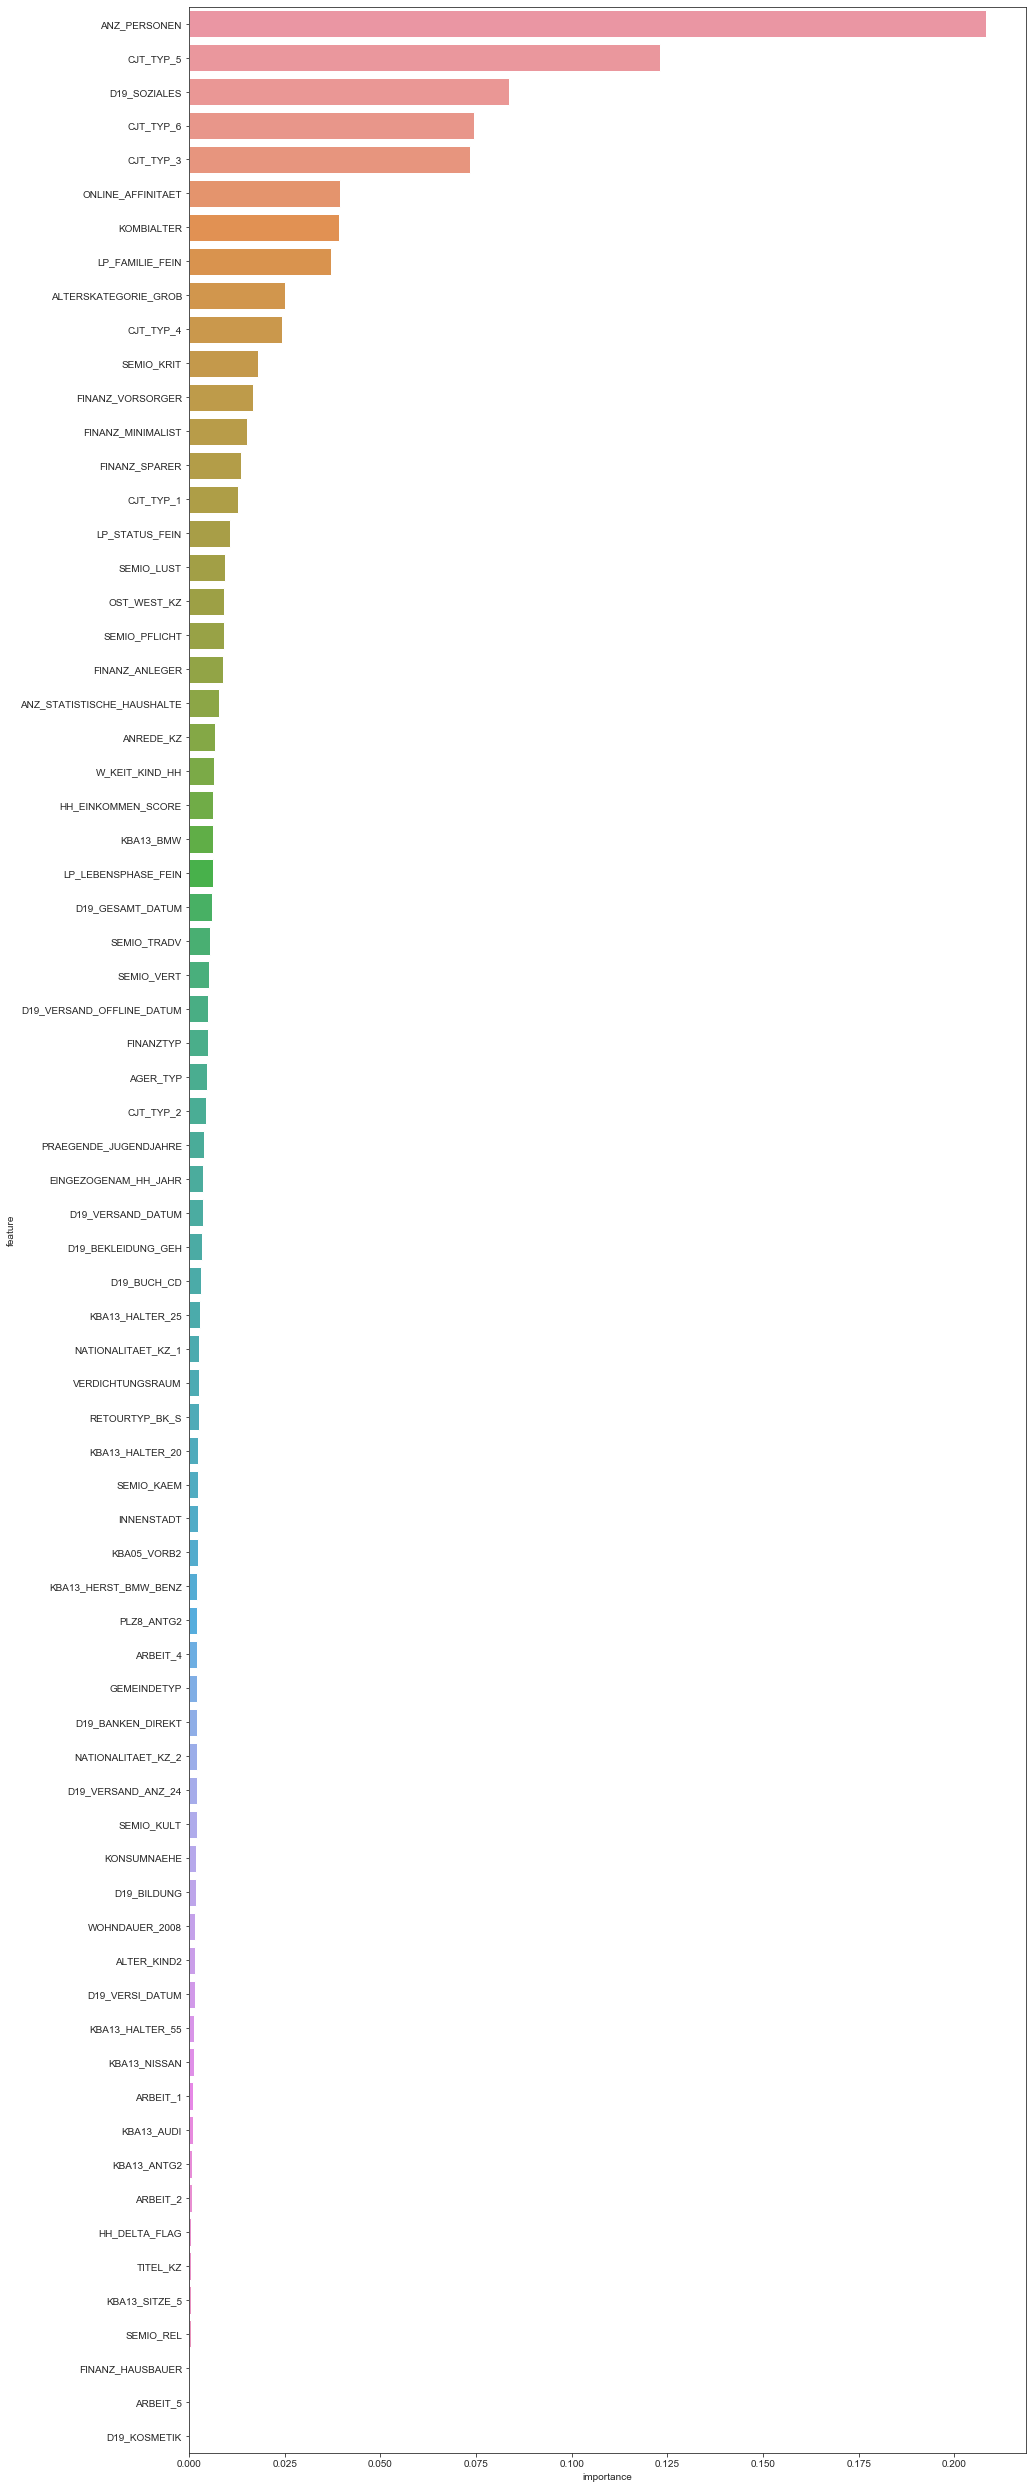

In [120]:
feature_importance_sorted = eval_feature_importance(azdias_clean,customers_clean)

In [121]:
feature_importance_sorted.shape

(72, 2)

In [122]:
azdias_clean.shape

(891221, 82)

In [125]:
feature_importance_sorted

,feature,importance
0,ANZ_PERSONEN,0.208298
4,CJT_TYP_5,0.123099
2,D19_SOZIALES,0.0836847
1,CJT_TYP_6,0.074479
5,CJT_TYP_3,0.0734363
7,ONLINE_AFFINITAET,0.0393785
6,KOMBIALTER,0.0391469
8,LP_FAMILIE_FEIN,0.0370883
9,ALTERSKATEGORIE_GROB,0.0251402
3,CJT_TYP_4,0.0242657


In [167]:
cols_keep_feature_selected_wrong = feature_importance_sorted[:-10].feature.values

In [132]:
customers = pd.read_csv('./Udacity_CUSTOMERS_052018.csv', sep=';')
for col in cols_keep_feature_selected_wrong:
    if col not in customers.columns:
        print(f"'{col}',")

'NATIONALITAET_KZ_1',
'ARBEIT_4',
'NATIONALITAET_KZ_2',
'ARBEIT_1',


In [168]:
features_oh = ['NATIONALITAET_KZ_1',
'ARBEIT_4',
'NATIONALITAET_KZ_2',
'ARBEIT_1']

features = ['ARBEIT','NATIONALITAET_KZ']

cols_keep_feature_selected = features + [col for col in cols_keep_feature_selected_wrong if col not in features_oh]

In [169]:
len(cols_keep_feature_selected)

2

In [135]:
azdias = pd.read_csv('./Udacity_AZDIAS_052018.csv', sep=';')

In [136]:
azdias_clean = clean_df.etl_pipeline(azdias,cols_keep=cols_keep_feature_selected)
customers_clean = clean_df.etl_pipeline(customers,cols_keep=cols_keep_feature_selected)

In [138]:
azdias_clean = impute(azdias_clean)

Got ValueEror: X has 67 features per sample, expected 81
Fitting new imputer.


In [143]:
azdias_clean = scale(azdias_clean)

Fitting new imputer.


Number of dimensions:2         that explain variance of 30%
Number of dimensions:4         that explain variance of 40%
Number of dimensions:6         that explain variance of 50%
Number of dimensions:11         that explain variance of 60%
Number of dimensions:17         that explain variance of 70%
Number of dimensions:25         that explain variance of 80%
Number of dimensions:35         that explain variance of 90%


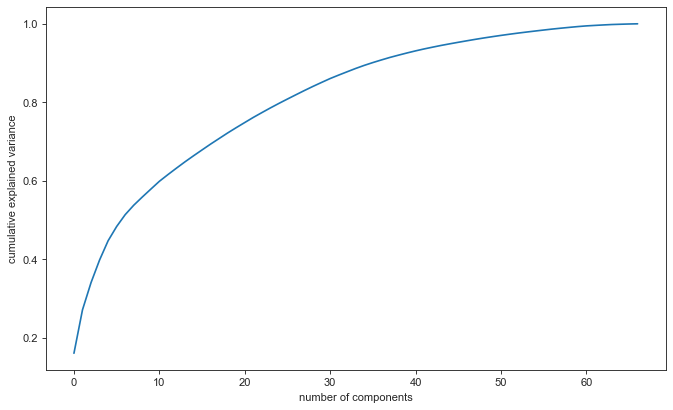

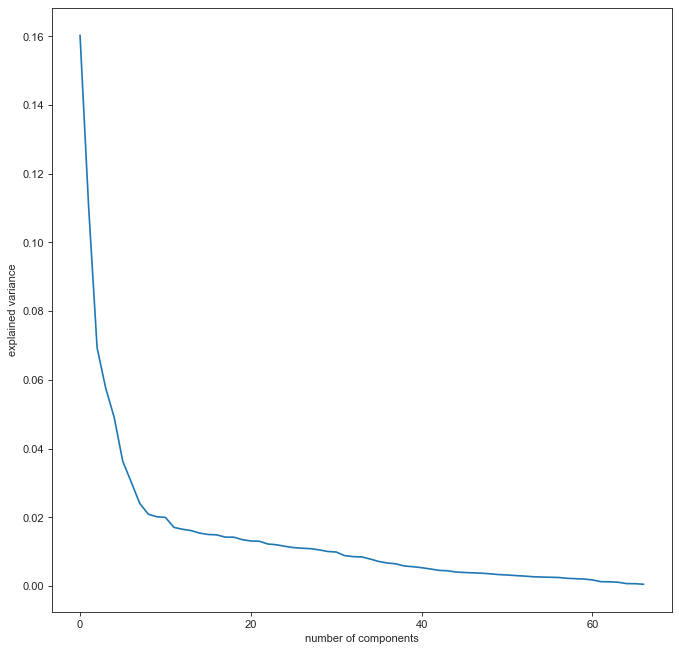

In [144]:
pca_eval(azdias_clean)

In [174]:
def reduce_features_by_n(azdias_clean,customers_clean,n):
    
    feature_importance_sorted = eval_feature_importance(azdias_clean,customers_clean)
    azdias_clean = None
    customers_clean = None
    
    cols_keep_feature_selected_wrong = feature_importance_sorted[:-n].feature.values

    features_d= {
        'NATIONALITAET_KZ':['NATIONALITAET_KZ_1','NATIONALITAET_KZ_2'],
        'ARBEIT':['ARBEIT_4','ARBEIT_1']
    }
        
    features = list({k for k,values in features_d.items() for v in values if v in cols_keep_feature_selected_wrong})
    features_oh = [v for k,values in features_d.items() for v in values]
    
    cols_keep_feature_selected = features + [col for col in cols_keep_feature_selected_wrong if col not in features_oh]
    
    azdias = pd.read_csv('./Udacity_AZDIAS_052018.csv', sep=';')
    azdias_clean = clean_df.etl_pipeline(azdias,cols_keep=cols_keep_feature_selected)

    azdias_clean = impute(azdias_clean)
    azdias_clean = scale(azdias_clean)
    
    print(f'new shape of azdias: {azdias_clean.shape}')
    
    pca_eval(azdias_clean)
    
    return(cols_keep_feature_selected)

In [175]:
azdias_clean.shape

(891221, 82)

In [172]:
azdias_clean = clean_df.etl_pipeline(azdias,cols_keep=cols_keep)
customers_clean = clean_df.etl_pipeline(customers,cols_keep=cols_keep)

In [ ]:
azdias_clean.shape

Fitting model, this could take ~20 minutes+
model fit!
cols:['ANZ_PERSONEN' 'CJT_TYP_5' 'D19_SOZIALES' 'CJT_TYP_6' 'CJT_TYP_3'
 'ONLINE_AFFINITAET' 'KOMBIALTER' 'LP_FAMILIE_FEIN' 'ALTERSKATEGORIE_GROB'
 'CJT_TYP_4' 'SEMIO_KRIT' 'FINANZ_VORSORGER' 'FINANZ_MINIMALIST'
 'FINANZ_SPARER' 'CJT_TYP_1' 'LP_STATUS_FEIN' 'SEMIO_LUST' 'OST_WEST_KZ'
 'SEMIO_PFLICHT' 'FINANZ_ANLEGER' 'ANZ_STATISTISCHE_HAUSHALTE' 'ANREDE_KZ'
 'W_KEIT_KIND_HH' 'HH_EINKOMMEN_SCORE' 'KBA13_BMW' 'LP_LEBENSPHASE_FEIN'
 'D19_GESAMT_DATUM' 'SEMIO_TRADV' 'SEMIO_VERT' 'D19_VERSAND_OFFLINE_DATUM'
 'FINANZTYP' 'AGER_TYP' 'CJT_TYP_2' 'PRAEGENDE_JUGENDJAHRE'
 'EINGEZOGENAM_HH_JAHR' 'D19_VERSAND_DATUM' 'D19_BEKLEIDUNG_GEH'
 'D19_BUCH_CD' 'KBA13_HALTER_25' 'NATIONALITAET_KZ_1' 'VERDICHTUNGSRAUM'
 'RETOURTYP_BK_S']


C:\Users\Olive\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Got ValueEror: X has 44 features per sample, expected 81
Fitting new imputer.
Fitting new imputer.
new shape of azdias: (891221, 44)
Number of dimensions:1         that explain variance of 30%
Number of dimensions:2         that explain variance of 40%
Number of dimensions:4         that explain variance of 50%
Number of dimensions:6         that explain variance of 60%
Number of dimensions:10         that explain variance of 70%
Number of dimensions:15         that explain variance of 80%
Number of dimensions:22         that explain variance of 90%


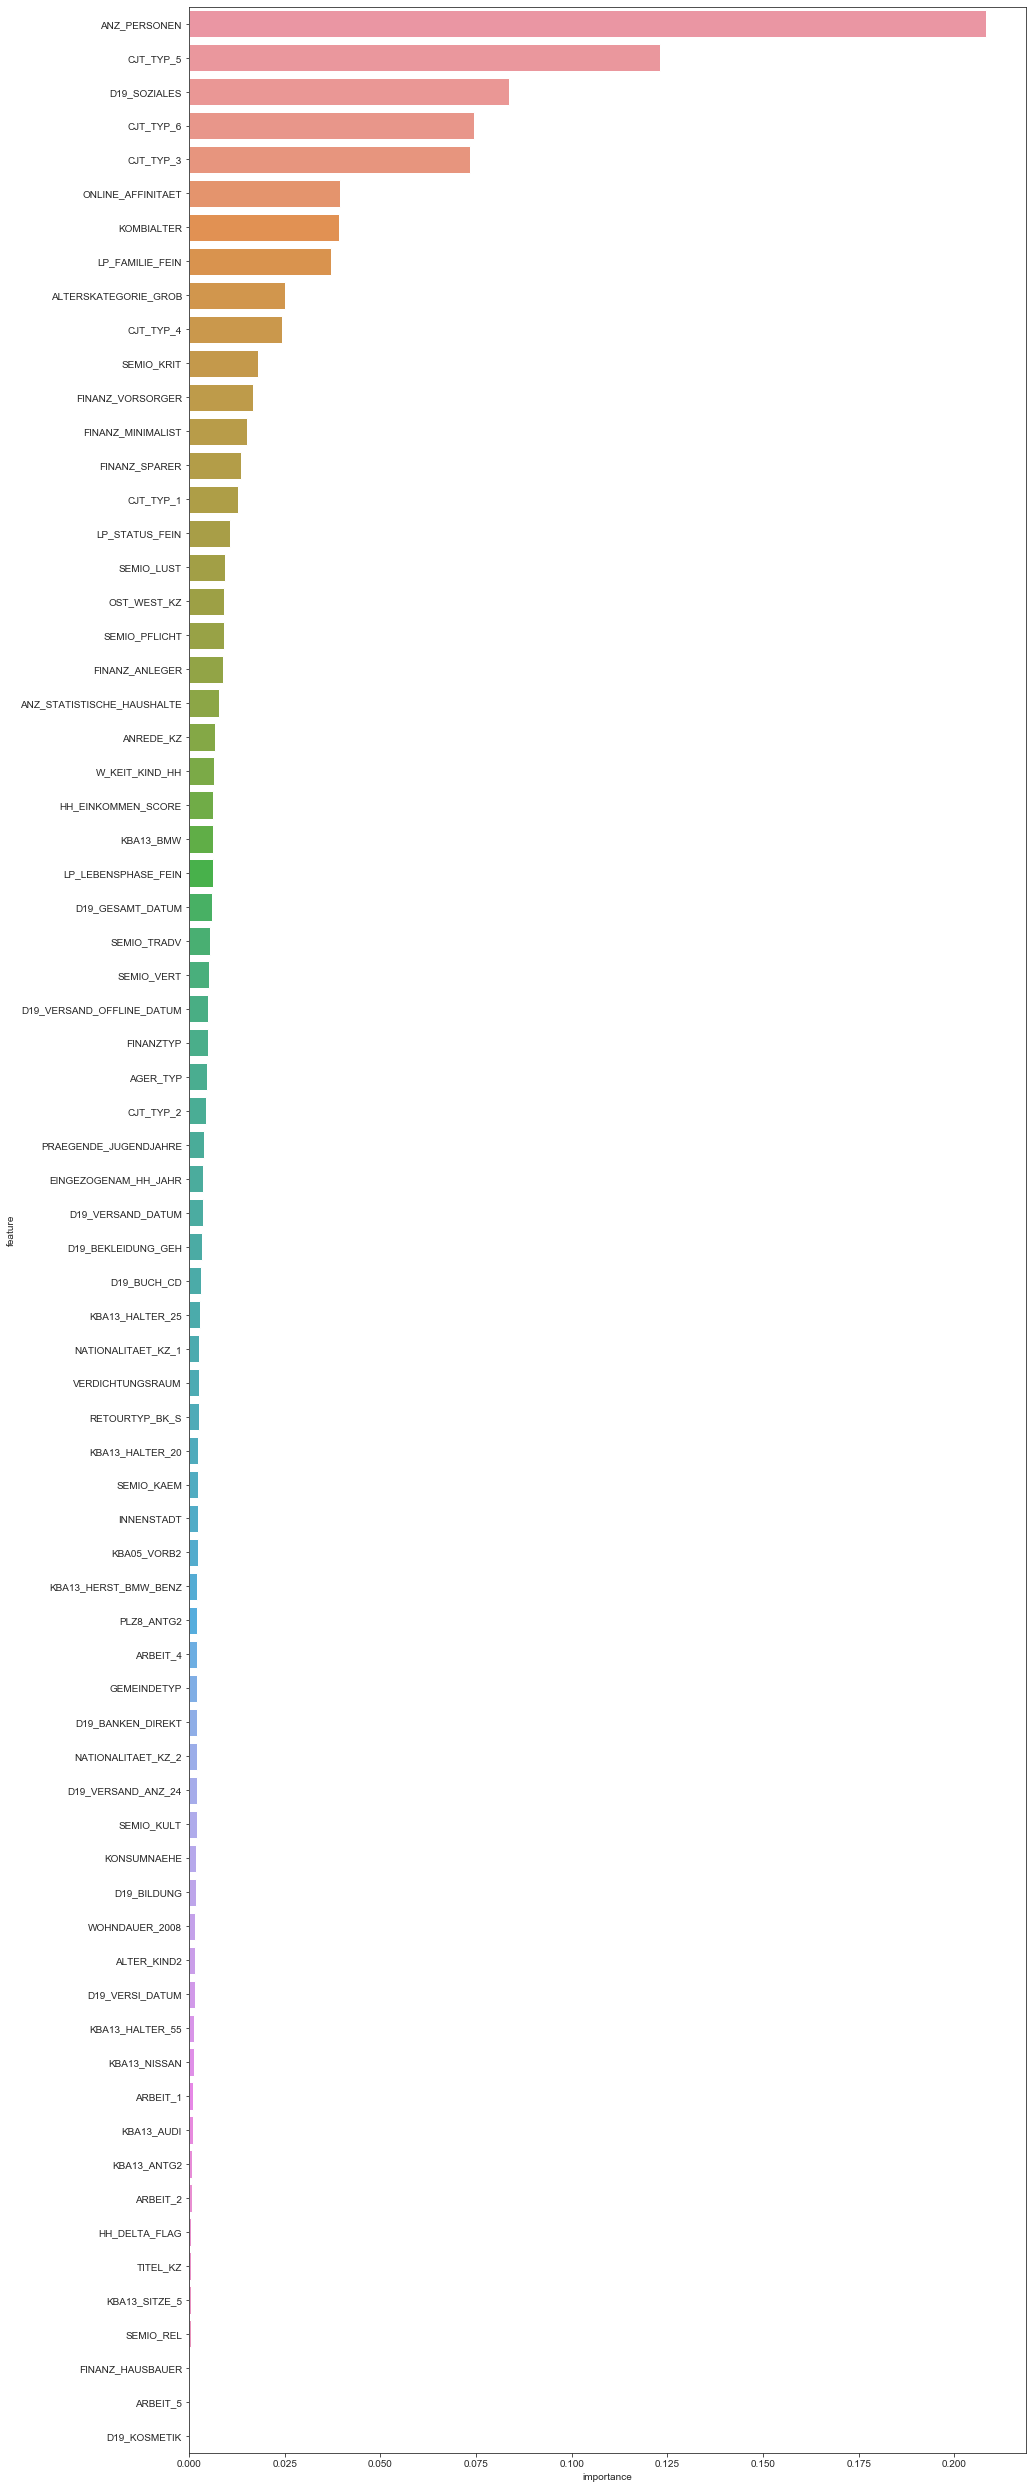

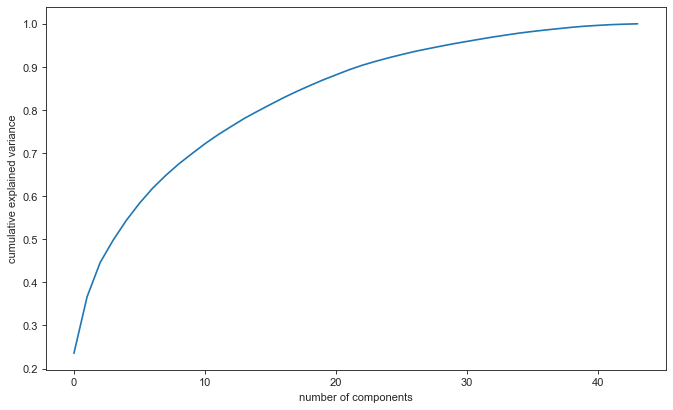

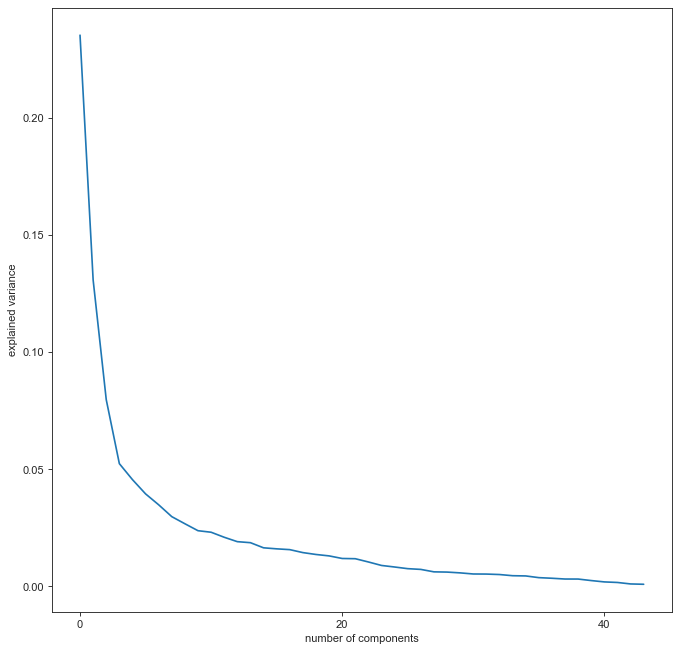

In [177]:
cols_keep_feature_selected = reduce_features_by_n(azdias_clean,customers_clean,30)

In [178]:
cols_keep_feature_selected

['NATIONALITAET_KZ',
 'ANZ_PERSONEN',
 'CJT_TYP_5',
 'D19_SOZIALES',
 'CJT_TYP_6',
 'CJT_TYP_3',
 'ONLINE_AFFINITAET',
 'KOMBIALTER',
 'LP_FAMILIE_FEIN',
 'ALTERSKATEGORIE_GROB',
 'CJT_TYP_4',
 'SEMIO_KRIT',
 'FINANZ_VORSORGER',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'CJT_TYP_1',
 'LP_STATUS_FEIN',
 'SEMIO_LUST',
 'OST_WEST_KZ',
 'SEMIO_PFLICHT',
 'FINANZ_ANLEGER',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ANREDE_KZ',
 'W_KEIT_KIND_HH',
 'HH_EINKOMMEN_SCORE',
 'KBA13_BMW',
 'LP_LEBENSPHASE_FEIN',
 'D19_GESAMT_DATUM',
 'SEMIO_TRADV',
 'SEMIO_VERT',
 'D19_VERSAND_OFFLINE_DATUM',
 'FINANZTYP',
 'AGER_TYP',
 'CJT_TYP_2',
 'PRAEGENDE_JUGENDJAHRE',
 'EINGEZOGENAM_HH_JAHR',
 'D19_VERSAND_DATUM',
 'D19_BEKLEIDUNG_GEH',
 'D19_BUCH_CD',
 'KBA13_HALTER_25',
 'VERDICHTUNGSRAUM',
 'RETOURTYP_BK_S']

With 10 Principle component dimensions explaining 70% of the variance, I think the transformed data is ready to use in clustering.

# Section 2. Clustering

In [3]:
cols_keep = config.cols_keep_notebook1_clustering

In [4]:
len(cols_keep)

42

In [5]:
azdias = pd.read_csv('./Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('./Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\Olive\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
azdias_clean = clean_df.etl_pipeline(azdias,cols_keep=cols_keep,verbosity=v.MED)

Running etl_pipeline...
Running unknown_to_nan...
Finished unknown_to_nan...
Running onehot_encode_df...
Finished running onehot_encode_df...
Running remove_string_values...
Finished running remove_string_values.
Running binarize_nan...
Finishing binarize_nan.
Running standardise_binary_features...
Finished running standardise_binary_features.
Running bin_features_with_tails...
Finished running bin_features_with_tails
Running drop_sparse_samples.
0% of rows dropped: 0 out of 891,221
Finished running drop_sparse_samples.
Finished running etl_pipeline.

df shape before:(891221, 366), after:(891221, 44)


In [11]:
customers_clean = clean_df.etl_pipeline(customers,cols_keep=cols_keep,verbosity=v.MED)

Running etl_pipeline...
Running unknown_to_nan...
Finished unknown_to_nan...
Running onehot_encode_df...
Finished running onehot_encode_df...
Running remove_string_values...
Finished running remove_string_values.
Running binarize_nan...
Finishing binarize_nan.
Running standardise_binary_features...
Finished running standardise_binary_features.
Running bin_features_with_tails...
Finished running bin_features_with_tails
Running drop_sparse_samples.
0% of rows dropped: 0 out of 191,652
Finished running drop_sparse_samples.
Finished running etl_pipeline.

df shape before:(191652, 369), after:(191652, 44)


I've made some improvements to my scale and impute functions so they no longer violate the single-responsibility principle. These functions are now maintained in the clean_df.py

In [18]:
clean_df.make_imputer_scaler_pca(azdias_clean,pca_variance=0.7,verbosity=v.HIGH)

Running  make_imputer_scaler_pca...
Running  make_imputer...
Finished running make_imputer.
Running  impute_df...
Finished running impute_df.
Running  make_scaler...
Finished running make_scaler.
Running  scale_df...
Finished running scale_df.
Running  make_pca...
Number of Principle components:10
Finished running make_pca.
Finished running make_imputer_scaler_pca.


In [24]:
azdias_clean = clean_df.impute_scale_pca_df(azdias_clean,verbosity=v.HIGH)

Running  impute_scale_pca_df...
Running  impute_df...
Finished running impute_df.
Running  scale_df...
Finished running scale_df.
Running  pca_df...
Finished running pca_df.
Finished running impute_scale_pca_df.

df shape before:(891221, 44), after:(891221, 10)


In [25]:
customers_clean = clean_df.impute_scale_pca_df(customers_clean,verbosity=v.HIGH)

Running  impute_scale_pca_df...
Running  impute_df...
Finished running impute_df.
Running  scale_df...
Finished running scale_df.
Running  pca_df...
Finished running pca_df.
Finished running impute_scale_pca_df.

df shape before:(191652, 44), after:(191652, 10)


In [26]:
def knn_elbow(df,kmax):

    distortions = [] 
    inertias = [] 
    mapping1 = {} 
    mapping2 = {} 
    K = range(2,kmax) 
  
    for k in K: 
        print("computing k:{0}".format(k))
        #Building and fitting the model 
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(df)     
      
        distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / df.shape[0]) 
        inertias.append(kmeanModel.inertia_) 
  
        mapping1[k] = sum(np.min(cdist(df, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / df.shape[0] 
        mapping2[k] = kmeanModel.inertia_ 

    figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(K, inertias, '-o', color='black')
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(K)
    plt.show()

computing k:2
computing k:3
computing k:4
computing k:5
computing k:6
computing k:7
computing k:8
computing k:9
computing k:10
computing k:11
computing k:12
computing k:13
computing k:14
computing k:15
computing k:16
computing k:17
computing k:18
computing k:19


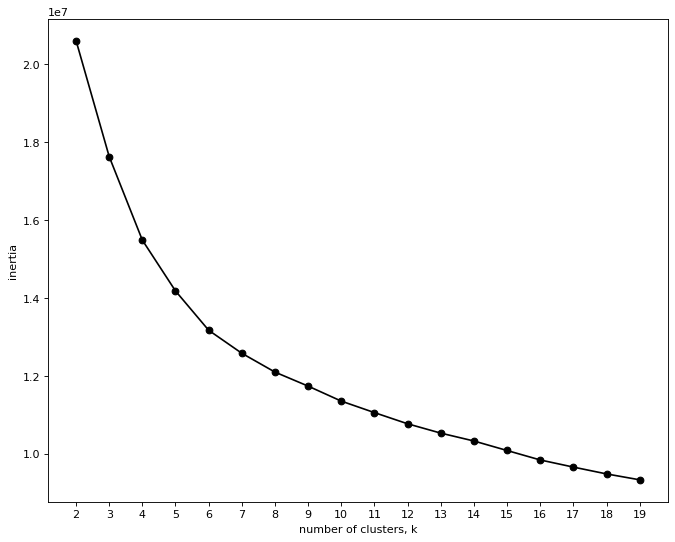

Wall time: 25min 35s


In [34]:
%%time
knn_elbow(azdias_clean,20)

It looks like my optimal K is between 5 and 7.

In [54]:
def plot_kmeans(kmodel,azdias_df,customers_df,num_clusters,azdias_clusters=None,customer_clusters=None):
    
    if azdias_clusters is None:
        azdias_clusters = kmodel.predict(azdias_df)
    if customer_clusters is None:
        customer_clusters = kmodel.predict(customers_df)
    
    labels = None
    azdias_clusters_counts = None
    customer_cluster_counts = None

    labels, azdias_cluster_counts = np.unique(azdias_clusters, return_counts=True)
    _, customer_cluster_counts = np.unique(customer_clusters, return_counts=True)
    
    
    labels = labels + 1
    azdias_cluster_per = azdias_cluster_counts*100/len(azdias_clusters)
    customer_cluster_per = customer_cluster_counts*100/len(customer_clusters)
    
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, azdias_cluster_per, width, label='General')
    rects2 = ax.bar(x + width/2, customer_cluster_per, width, label='Customers')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    figure(num=None, figsize=(8, 16), dpi=80, facecolor='w', edgecolor='k')
    ax.set_ylabel('Percent %')
    ax.set_title('Percent of cluster for k:{0}'.format(num_clusters))
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.show()
    
    return(azdias_cluster_counts,customer_cluster_counts)

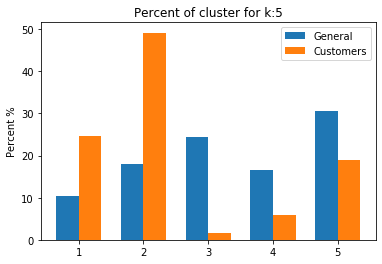

<Figure size 640x1280 with 0 Axes>

(array([ 92353, 159671, 217544, 148526, 273127], dtype=int64),
 array([47030, 94231,  2889, 11263, 36239], dtype=int64))

In [36]:
n_clusters = 5
kmeanModel = KMeans(n_clusters=n_clusters,random_state=0)
kmeanModel.fit(azdias_clean)
plot_kmeans(kmeanModel,azdias_clean,customers_clean,n_clusters)

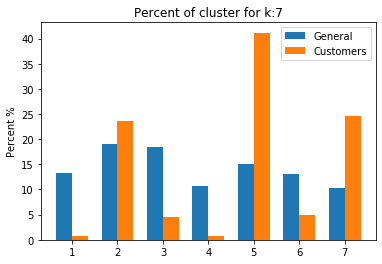

<Figure size 640x1280 with 0 Axes>

(array([118510, 169450, 165033,  95663, 134629, 115955,  91981],
       dtype=int64),
 array([ 1367, 45151,  8566,  1356, 78891,  9317, 47004], dtype=int64))

In [37]:
n_clusters = 7
kmeanModel = KMeans(n_clusters=n_clusters,random_state=0)
kmeanModel.fit(azdias_clean)
plot_kmeans(kmeanModel,azdias_clean,customers_clean,n_clusters)

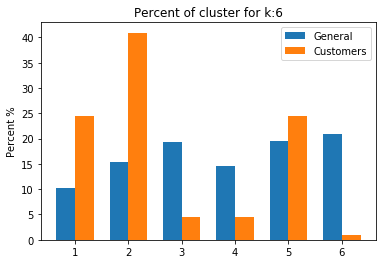

<Figure size 640x1280 with 0 Axes>

(array([ 92092, 137600, 172022, 129428, 173780, 186299], dtype=int64),
 array([47009, 78431,  8611,  8747, 46882,  1972], dtype=int64))

In [38]:
n_clusters = 6
kmeanModel = KMeans(n_clusters=n_clusters,random_state=0)
kmeanModel.fit(azdias_clean)
plot_kmeans(kmeanModel,azdias_clean,customers_clean,n_clusters)

It looks like k=7 has the most distinction between customers and the general population with about 90% of customers represented across 3 clusters, with the largest cluster representing 40% of the customer population.

# Section 3: Understanding the Demographics

In [7]:
azdias = pd.read_csv('./Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('./Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\Olive\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
cols_keep = config.cols_keep_notebook1_clustering

In [46]:
azdias_clean = clean_df.etl_pipeline(azdias,cols_keep=cols_keep)
customers_clean = clean_df.etl_pipeline(customers,cols_keep=cols_keep)

In [47]:
pca = pickler.load(config.pca_name)

In [48]:
azdias_pca = clean_df.impute_scale_pca_df(azdias_clean)
customers_pca = clean_df.impute_scale_pca_df(customers_clean)

In [49]:
n_clusters = 7
kmeanModel = KMeans(n_clusters=n_clusters,random_state=0)
kmeanModel.fit(azdias_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [50]:
print(azdias_pca.shape)
print(customers_pca.shape)

(891221, 10)
(191652, 10)


In [51]:
azdias_clusters = kmeanModel.predict(azdias_pca)
customer_clusters = kmeanModel.predict(customers_pca)

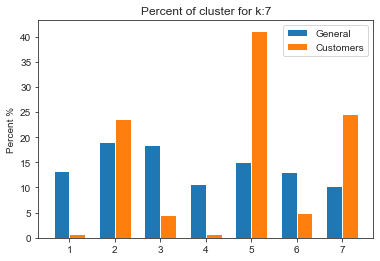

<Figure size 640x1280 with 0 Axes>

(array([118510, 169450, 165033,  95663, 134629, 115955,  91981],
       dtype=int64),
 array([ 1367, 45151,  8566,  1356, 78891,  9317, 47004], dtype=int64))

In [55]:
plot_kmeans(kmeanModel,azdias_pca,customers_pca,n_clusters,azdias_clusters=azdias_clusters,customer_clusters=customer_clusters)

In [56]:
azdias_pca['RESPONSE'] = 0
azdias_pca['CLUSTER'] = azdias_clusters
customers_pca['RESPONSE'] = 1
customers_pca['CLUSTER'] = customer_clusters

azdias_customer_df = pd.concat([azdias_pca,customers_pca])

In [57]:
azdias_customer_df.shape

(1082873, 12)

In [60]:
print('x')

x


In [67]:
customer_clusters = (5,7,2)
non_customer_clusters = (1,3,4,6)

In [65]:
def plt_hist(series,title):
    sns.set_style("darkgrid")
    sns.set_style("ticks")
    plt.figure(figsize=(16,6))
    plt.title(title)
    sns.distplot(series.values,kde=False)
    plt.ylabel('Frequency',fontsize=12)
    plt.show()      

In [70]:
def plt_cluster_comp(df,pc):
    for cluster in customer_clusters:
        plt_hist(
            df.loc[df.CLUSTER == cluster-1][pc],
            f"Customer - Histogram of PC:{pc} for cluster:{cluster}"
        )

    for cluster in non_customer_clusters:
        plt_hist(
            azdias_customer_df.loc[df.CLUSTER == cluster-1][pc],
            f"Non Customer - Histogram of PC:{pc} for cluster:{cluster}"
        )

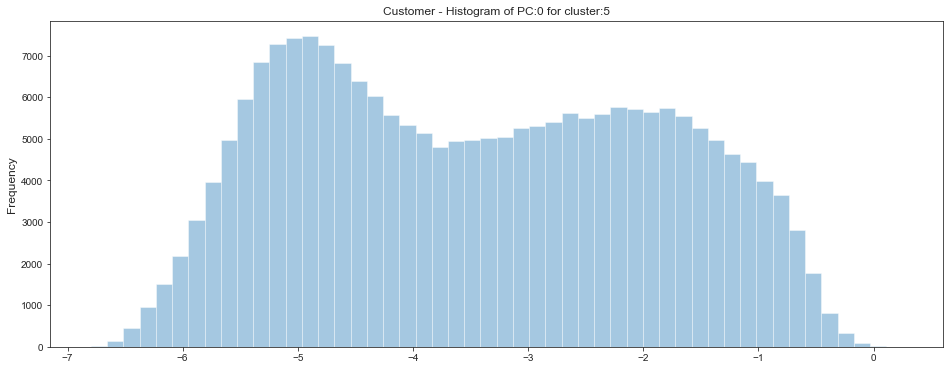

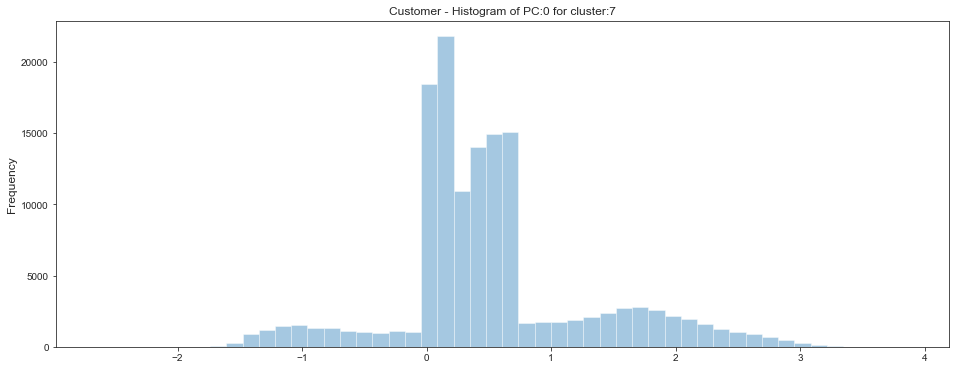

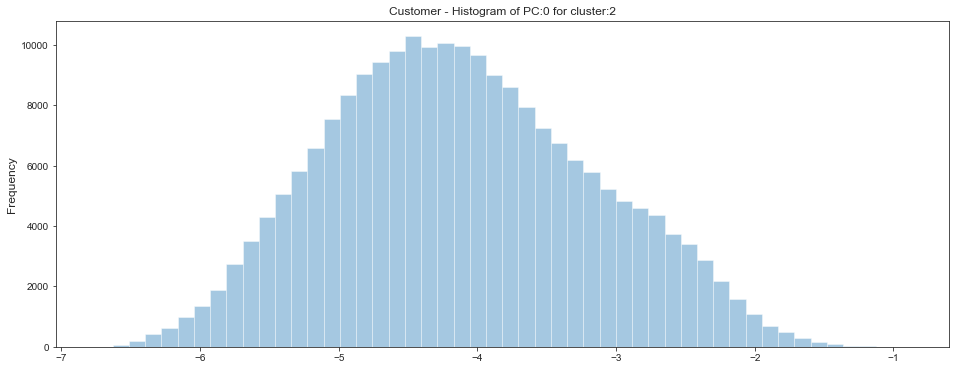

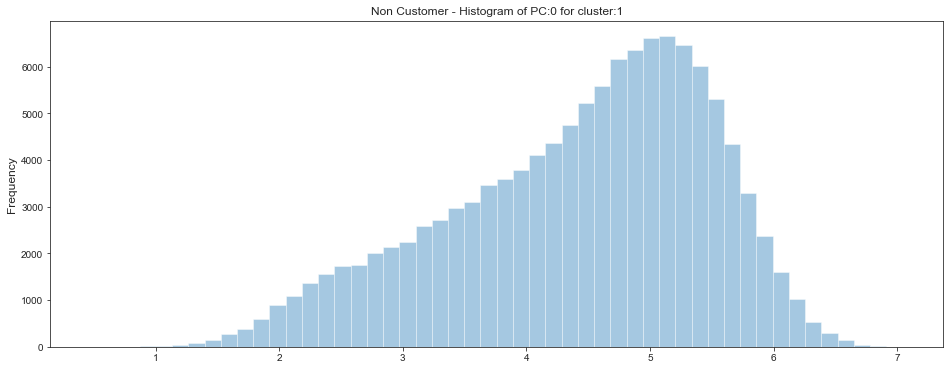

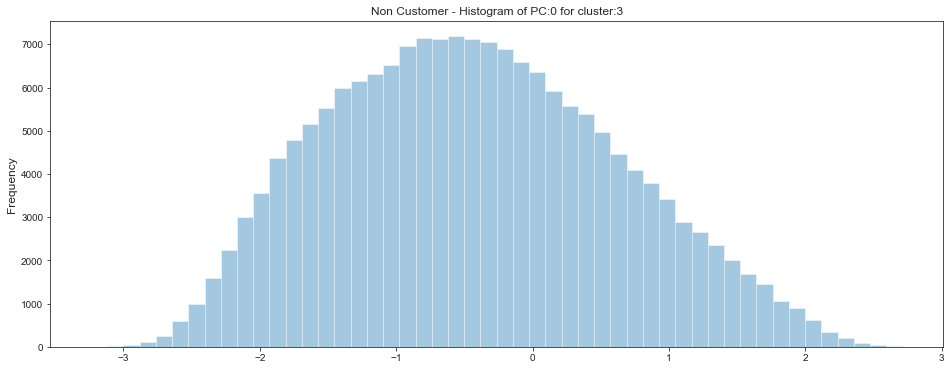

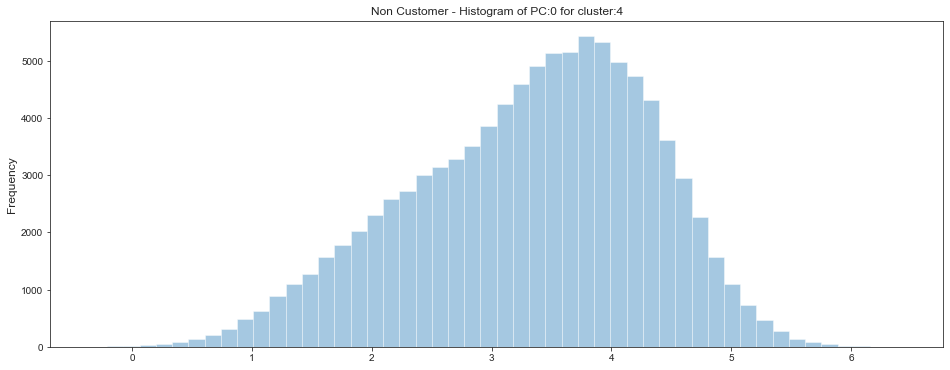

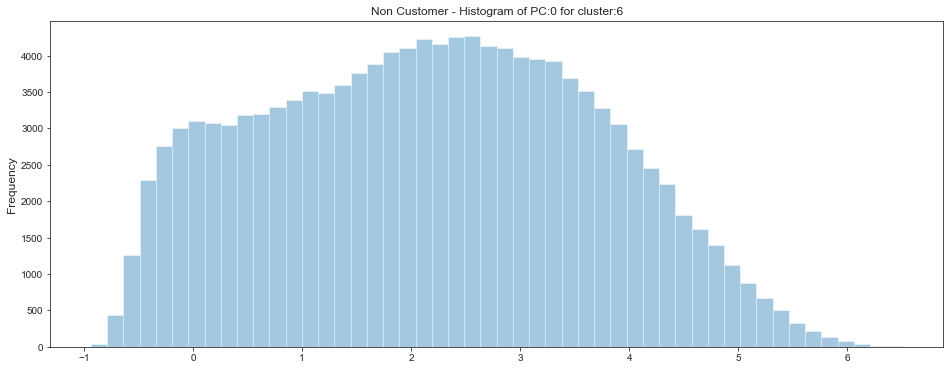

In [71]:
plt_cluster_comp(azdias_customer_df,0)

From the histogram plots above I can observe that the customer clusters values for principle component 1 are largely negative in contrast to the non-customer clusters. 

This means when analysing the feature weights, there is an inverse correlation for customers and a positive correlation for non-customers

In [72]:
def display_component(v, feature_list, component_num, n_weights=10):
    
    row_idx = component_num
    
    v_1_row = v[row_idx]
    v_1 = np.squeeze(v_1_row)
    
    comps = pd.DataFrame(list(zip(v_1, feature_list)),
                        columns=['weights','features'])
    
    comps['abs_weights'] = comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights',ascending=False).head(n_weights)
    
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data,
                  x="weights",
                  y="features",
                  palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

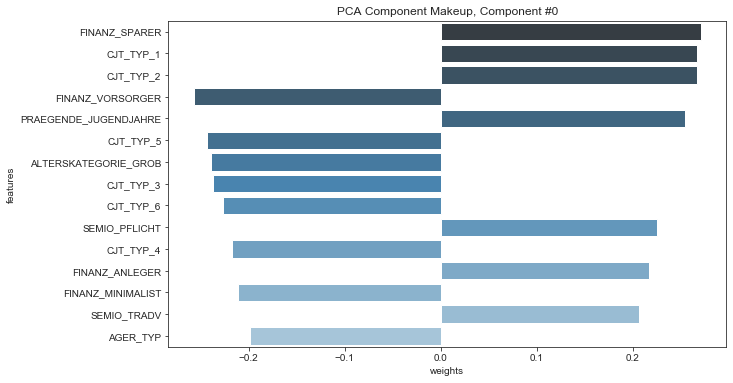

In [73]:
display_component(pca.components_,azdias_clean.columns.values,component_num=0,n_weights=15)

Analysis of the first principle component shows positive correlation between:

* FINANZ_SPARER
* CJT_TYP_1
* CJT_TYP_2
* PRAEGENDE_JUGENGJAHRE
* SEMIO_PFLICHT
* FINANZ_ANLEGER
* SEMIO_TRADV

negative correlation between:

* FINANZ_VORSORGER
* CJT_TYP_5
* ALTERSKATEGORIE_GROB
* CJT_TYP_3
* CJT_TYP_6
* SEMIO_PFLICHT
* CJT_TYP_4
* FINANZ_MINIMALIST
* AGER_TYP

The principle component represents the highest variance, 30%, so these are the features to analyse first with respect to the clusters.


Therefore I can evaluate that customers will have low values for features with positive correlations and high values for negative correlated features, and vice versa for

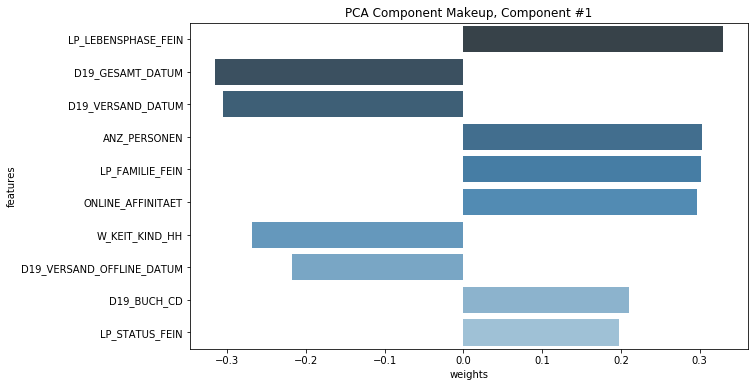

In [20]:
display_component(pca.components_,azdias_clean.columns.values,component_num=1,n_weights=10)

Analysis of the 2nd component shows:

positive correlation between:

* LB_LEBENSPHASE_FEIN
* ANZ_PERSONEN
* LB_FAMILIE_FEIN
* ONLINE_AFFINITAET
* D19_BUCH_CD
* LP_STATUS_FEIN

negative correlation between:

* D19_GESAMT_DATUM
* D19_VERSAND_DATUM
* W_KEIT_KIND_HH
* D19_VERSAND_DATUM
* W_KEIT_KIND_HH
* D19_VERSAND_OFFLINE_DATUM

The second componenent represents a variance of 10% in the dataset

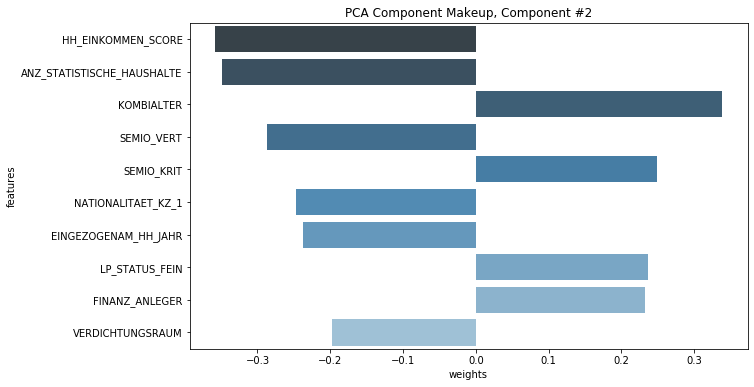

In [21]:
display_component(pca.components_,azdias_clean.columns.values,component_num=2,n_weights=10)